In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, Bidirectional, Reshape, Conv1D, GaussianNoise, BatchNormalization
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.8)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [8]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [10]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    lstm = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal'))
    lstm_1 = lstm(inputs)
    batch_norm1 = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1)
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal'))
    lstm_2_output = lstm_2(lstm_1_droput)
    batch_norm2 = BatchNormalization()(lstm_2_output)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model


## Discriminator

In [11]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [12]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [13]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        # Threshhold
#         if(cur_gen_loss > 0.8):
#                 break;

    return history, history_val

## Visualization

In [14]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [15]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [16]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [17]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [18]:
stock_code = "IBM"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10  112.093689  114.125237  110.301147  112.810707   64.370781   
6    2000-01-11  112.691208  115.798279  111.496178  113.766731   64.916283   
7    2000-01-12  114.364243  116.634796  113.049713  114.244743   65.189041   
8    2000-01-13  114.663002  115.678780  110.659653  113.049713   64.507149   
9    2000-01-14  115.619026  117.889580  112.332695  114.364243   65.257233   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  118.432121  119.703636  118.298279  118.451241  106.144394   
5279 2020-12-24  119.502869  119.598473  118.747612  119.206497  106.821182   
5280 2020-12-28  119.598473  121.032501  118.986618  119.330788  106.932571   
5281 2020-12-29  119.837479  119.961761  117.820267  118.355644  106.058723   
5282 2020-12-30  118.355644  119.359467  118.193115  118.871895  106.521347   

        Volume          Ma  
5      8933363  109.285373  
6      8235472  109.667783  
7      7116775  110.994264  
8      8880226  111.663481  
9     11460604  112.476100  
...        ...         ...  
5278   2817819  119.302103  
5279   1842111  118.986615  
5280   3781499  118.822179  
5281   3647402  118.625238  
5282   3535794  118.703633  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 20)             0         
                                                                 
 dropout (Dropout)           (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.9457411766052246 sec Generator Loss: 0.7927007079124451,  Discriminator_loss: 1.3595895767211914
Time for epoch 53 is 0.9414854049682617 sec Generator Loss: 0.7803720235824585,  Discriminator_loss: 1.3626346588134766
Time for epoch 54 is 0.9327144622802734 sec Generator Loss: 0.7912588715553284,  Discriminator_loss: 1.3580071926116943
Time for epoch 55 is 0.9205904006958008 sec Generator Loss: 0.7858408689498901,  Discriminator_loss: 1.3580901622772217
Time for epoch 56 is 0.9157702922821045 sec Generator Loss: 0.7802634835243225,  Discriminator_loss: 1.364109992980957
Time for epoch 57 is 0.9722626209259033 sec Generator Loss: 0.792089581489563,  Discriminator_loss: 1.3633995056152344
Time for epoch 58 is 0.9401793479919434 sec Generator Loss: 0.7876116633415222,  Discriminator_loss: 1.3648316860198975
Time for epoch 59 is 1.0069620609283447 sec Generator Loss: 0.7869018316268921,  Discriminator_loss: 1.3690160512924194
Time for epoch 60 is 0.8962864875793457 se

Time for epoch 121 is 1.024993658065796 sec Generator Loss: 0.7707762718200684,  Discriminator_loss: 1.3684754371643066
Time for epoch 122 is 0.939063549041748 sec Generator Loss: 0.7786566019058228,  Discriminator_loss: 1.366500973701477
Time for epoch 123 is 0.9489405155181885 sec Generator Loss: 0.7742772698402405,  Discriminator_loss: 1.3650788068771362
Time for epoch 124 is 0.9305458068847656 sec Generator Loss: 0.7684380412101746,  Discriminator_loss: 1.3651013374328613
Time for epoch 125 is 0.937345027923584 sec Generator Loss: 0.7688471674919128,  Discriminator_loss: 1.3691916465759277
Time for epoch 126 is 0.9764542579650879 sec Generator Loss: 0.765164315700531,  Discriminator_loss: 1.3714638948440552
Time for epoch 127 is 1.038994312286377 sec Generator Loss: 0.7717718482017517,  Discriminator_loss: 1.3657389879226685
Time for epoch 128 is 0.9743201732635498 sec Generator Loss: 0.7727635502815247,  Discriminator_loss: 1.3629646301269531
Time for epoch 129 is 1.08335804939270

Time for epoch 190 is 1.07906174659729 sec Generator Loss: 0.767949104309082,  Discriminator_loss: 1.3687540292739868
Time for epoch 191 is 1.1283831596374512 sec Generator Loss: 0.7758198976516724,  Discriminator_loss: 1.360676884651184
Time for epoch 192 is 1.1130459308624268 sec Generator Loss: 0.7649155259132385,  Discriminator_loss: 1.366237759590149
Time for epoch 193 is 1.0218119621276855 sec Generator Loss: 0.7737915515899658,  Discriminator_loss: 1.3682247400283813
Time for epoch 194 is 0.9557051658630371 sec Generator Loss: 0.7724825143814087,  Discriminator_loss: 1.3663756847381592
Time for epoch 195 is 0.9547665119171143 sec Generator Loss: 0.7735445499420166,  Discriminator_loss: 1.3619751930236816
Time for epoch 196 is 1.0080995559692383 sec Generator Loss: 0.7717021703720093,  Discriminator_loss: 1.3673015832901
Time for epoch 197 is 1.09814453125 sec Generator Loss: 0.7735600471496582,  Discriminator_loss: 1.3610501289367676
Time for epoch 198 is 0.9834115505218506 sec 

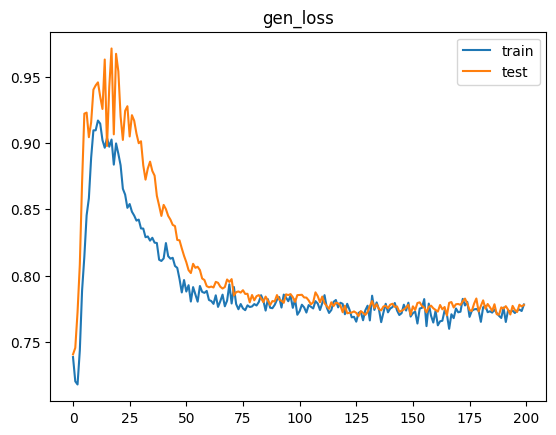

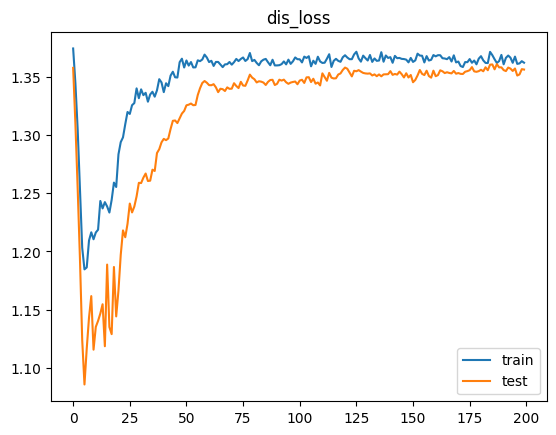

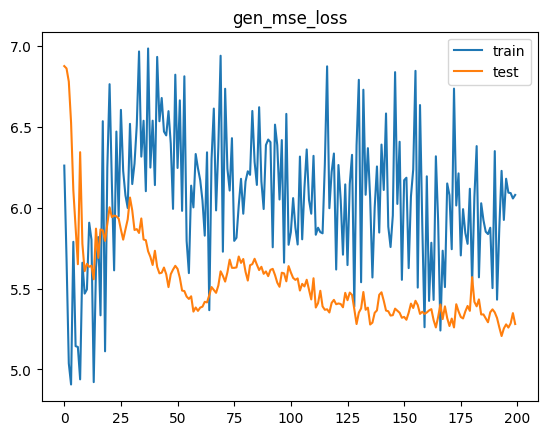

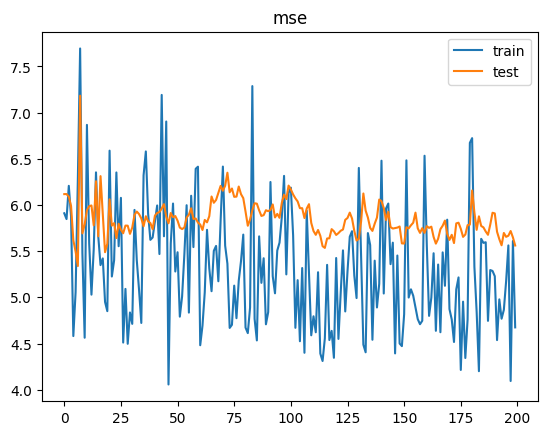

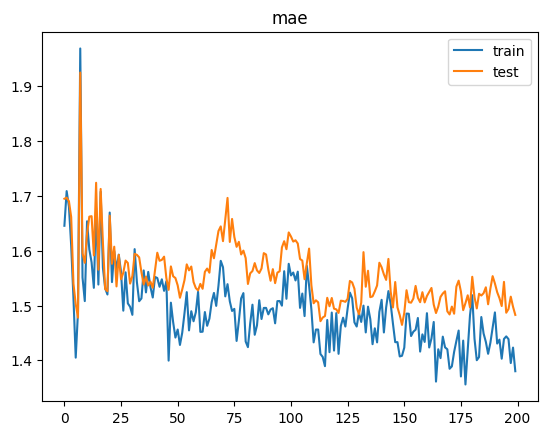

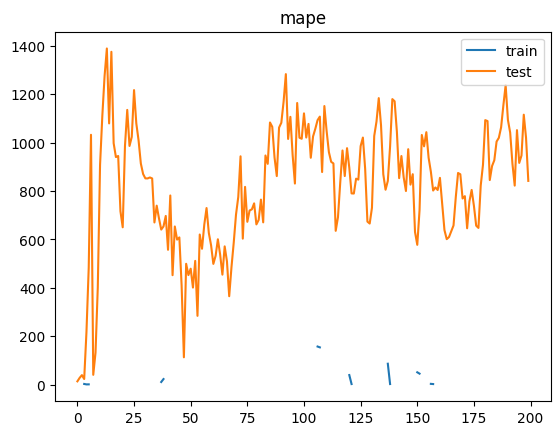

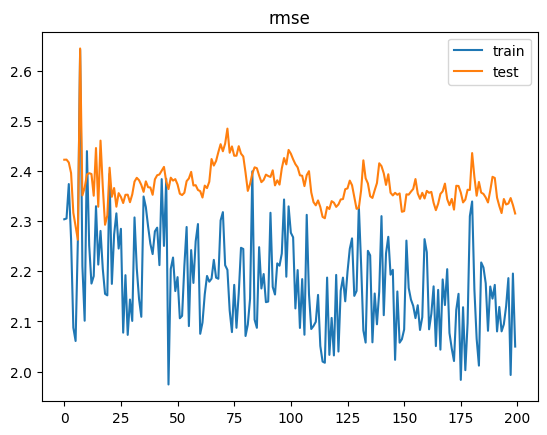

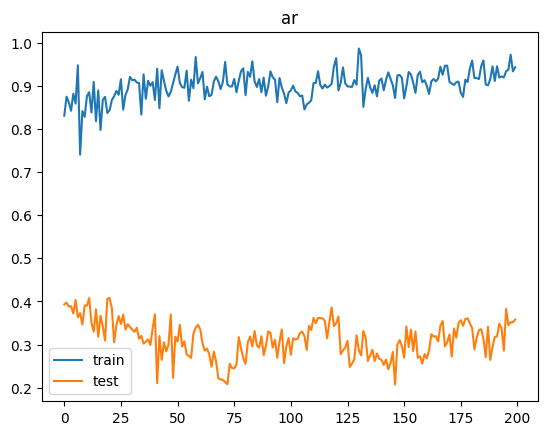

2/2 [==============================] - 1s 3ms/step


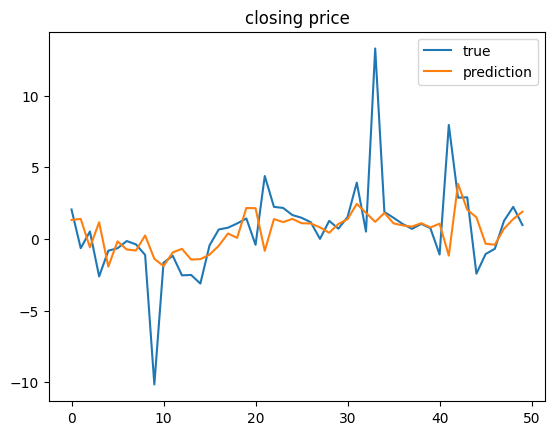

[MSE Baseline] train: 3.8793362963174918  test: 4.988566607603537
Delta time with epochs = 200: 0:03:31.225112
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 20)             0         
              

Time for epoch 51 is 0.9758331775665283 sec Generator Loss: 0.7884154915809631,  Discriminator_loss: 1.366174578666687
Time for epoch 52 is 0.9690301418304443 sec Generator Loss: 0.7937104105949402,  Discriminator_loss: 1.3631047010421753
Time for epoch 53 is 1.0720350742340088 sec Generator Loss: 0.7911725640296936,  Discriminator_loss: 1.3626164197921753
Time for epoch 54 is 0.9890539646148682 sec Generator Loss: 0.7955135703086853,  Discriminator_loss: 1.3642250299453735
Time for epoch 55 is 1.0532631874084473 sec Generator Loss: 0.7932114005088806,  Discriminator_loss: 1.3605281114578247
Time for epoch 56 is 0.9935688972473145 sec Generator Loss: 0.7851341366767883,  Discriminator_loss: 1.360379695892334
Time for epoch 57 is 0.9802677631378174 sec Generator Loss: 0.7815855145454407,  Discriminator_loss: 1.3618037700653076
Time for epoch 58 is 1.0163817405700684 sec Generator Loss: 0.787693202495575,  Discriminator_loss: 1.3629335165023804
Time for epoch 59 is 0.9922783374786377 sec

Time for epoch 120 is 0.9330480098724365 sec Generator Loss: 0.7793988585472107,  Discriminator_loss: 1.3666880130767822
Time for epoch 121 is 1.0321342945098877 sec Generator Loss: 0.7808526158332825,  Discriminator_loss: 1.3640981912612915
Time for epoch 122 is 1.0361003875732422 sec Generator Loss: 0.775864839553833,  Discriminator_loss: 1.3640552759170532
Time for epoch 123 is 1.034691333770752 sec Generator Loss: 0.7739710211753845,  Discriminator_loss: 1.3688673973083496
Time for epoch 124 is 1.0332512855529785 sec Generator Loss: 0.7789391875267029,  Discriminator_loss: 1.3633229732513428
Time for epoch 125 is 1.0219547748565674 sec Generator Loss: 0.7639483213424683,  Discriminator_loss: 1.3695603609085083
Time for epoch 126 is 1.0613164901733398 sec Generator Loss: 0.7758471369743347,  Discriminator_loss: 1.3618415594100952
Time for epoch 127 is 0.9700675010681152 sec Generator Loss: 0.7730415463447571,  Discriminator_loss: 1.3650190830230713
Time for epoch 128 is 0.9350082874

Time for epoch 188 is 0.937361478805542 sec Generator Loss: 0.7801865935325623,  Discriminator_loss: 1.3636143207550049
Time for epoch 189 is 0.9455966949462891 sec Generator Loss: 0.7702712416648865,  Discriminator_loss: 1.372241735458374
Time for epoch 190 is 0.9313092231750488 sec Generator Loss: 0.7751450538635254,  Discriminator_loss: 1.3671578168869019
Time for epoch 191 is 0.9885227680206299 sec Generator Loss: 0.7769569754600525,  Discriminator_loss: 1.3673409223556519
Time for epoch 192 is 0.9759752750396729 sec Generator Loss: 0.7710838913917542,  Discriminator_loss: 1.3691941499710083
Time for epoch 193 is 0.9363036155700684 sec Generator Loss: 0.767659604549408,  Discriminator_loss: 1.3662775754928589
Time for epoch 194 is 0.939922571182251 sec Generator Loss: 0.7796128392219543,  Discriminator_loss: 1.3645648956298828
Time for epoch 195 is 0.9290759563446045 sec Generator Loss: 0.7721455097198486,  Discriminator_loss: 1.3646526336669922
Time for epoch 196 is 0.988117218017

Time for epoch 257 is 0.9370768070220947 sec Generator Loss: 0.7790172696113586,  Discriminator_loss: 1.360487461090088
Time for epoch 258 is 0.9445924758911133 sec Generator Loss: 0.77245032787323,  Discriminator_loss: 1.3648995161056519
Time for epoch 259 is 1.0283787250518799 sec Generator Loss: 0.7883849740028381,  Discriminator_loss: 1.3633244037628174
Time for epoch 260 is 0.973703145980835 sec Generator Loss: 0.7705332040786743,  Discriminator_loss: 1.3651840686798096
Time for epoch 261 is 0.963371753692627 sec Generator Loss: 0.7838636636734009,  Discriminator_loss: 1.3608359098434448
Time for epoch 262 is 0.9565107822418213 sec Generator Loss: 0.7842662334442139,  Discriminator_loss: 1.3563306331634521
Time for epoch 263 is 0.9364051818847656 sec Generator Loss: 0.7792948484420776,  Discriminator_loss: 1.3589037656784058
Time for epoch 264 is 0.9813077449798584 sec Generator Loss: 0.7727683186531067,  Discriminator_loss: 1.360864520072937
Time for epoch 265 is 0.95700716972351

Time for epoch 326 is 1.013782024383545 sec Generator Loss: 0.783311665058136,  Discriminator_loss: 1.3538587093353271
Time for epoch 327 is 0.9801719188690186 sec Generator Loss: 0.776964545249939,  Discriminator_loss: 1.3569872379302979
Time for epoch 328 is 0.9776897430419922 sec Generator Loss: 0.7868286967277527,  Discriminator_loss: 1.354007363319397
Time for epoch 329 is 0.9535367488861084 sec Generator Loss: 0.7861440181732178,  Discriminator_loss: 1.3608660697937012
Time for epoch 330 is 0.9670696258544922 sec Generator Loss: 0.7860418558120728,  Discriminator_loss: 1.352586030960083
Time for epoch 331 is 1.004479169845581 sec Generator Loss: 0.7916566133499146,  Discriminator_loss: 1.356752872467041
Time for epoch 332 is 0.971879243850708 sec Generator Loss: 0.7904303669929504,  Discriminator_loss: 1.3516309261322021
Time for epoch 333 is 0.96736741065979 sec Generator Loss: 0.7818816304206848,  Discriminator_loss: 1.3553775548934937
Time for epoch 334 is 0.9423480033874512 s

Time for epoch 395 is 0.9447565078735352 sec Generator Loss: 0.7907797694206238,  Discriminator_loss: 1.3478535413742065
Time for epoch 396 is 0.948552131652832 sec Generator Loss: 0.7936387658119202,  Discriminator_loss: 1.3491151332855225
Time for epoch 397 is 0.9905002117156982 sec Generator Loss: 0.7970660924911499,  Discriminator_loss: 1.3489423990249634
Time for epoch 398 is 0.9871554374694824 sec Generator Loss: 0.7922030687332153,  Discriminator_loss: 1.3539425134658813
Time for epoch 399 is 0.9549932479858398 sec Generator Loss: 0.7846464514732361,  Discriminator_loss: 1.351086139678955
Time for epoch 400 is 0.9565038681030273 sec Generator Loss: 0.787990927696228,  Discriminator_loss: 1.3571964502334595
Time for epoch 401 is 0.9093775749206543 sec Generator Loss: 0.7924467325210571,  Discriminator_loss: 1.3466590642929077
Time for epoch 402 is 0.9218049049377441 sec Generator Loss: 0.7880741953849792,  Discriminator_loss: 1.3515199422836304
Time for epoch 403 is 0.95372438430

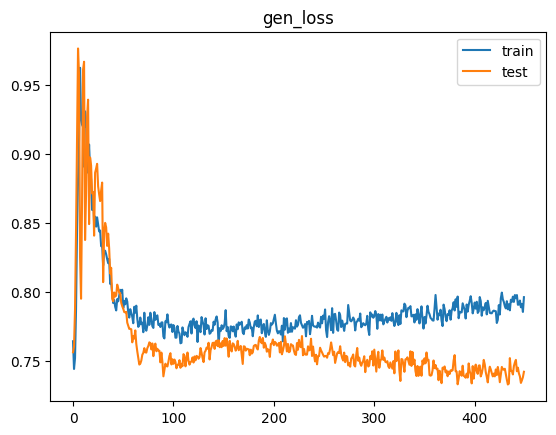

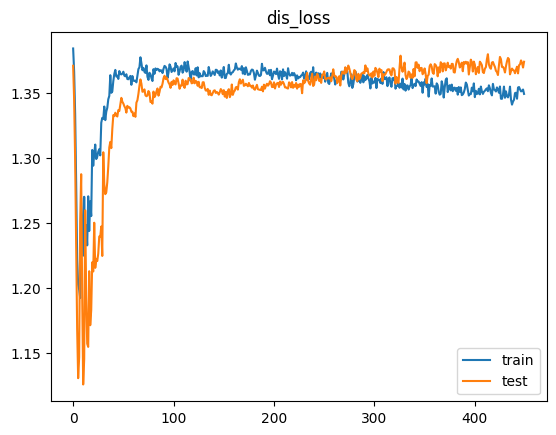

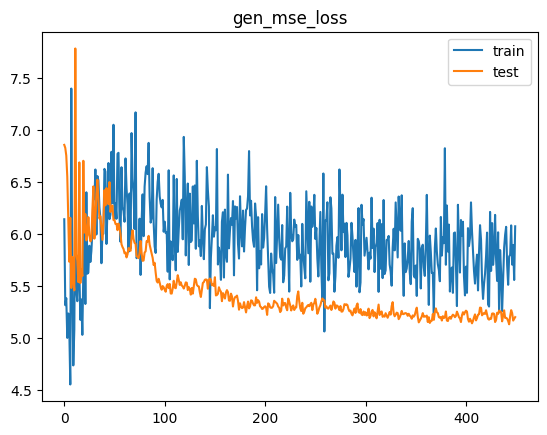

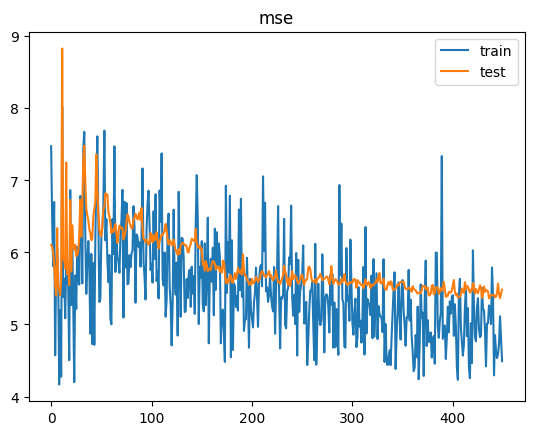

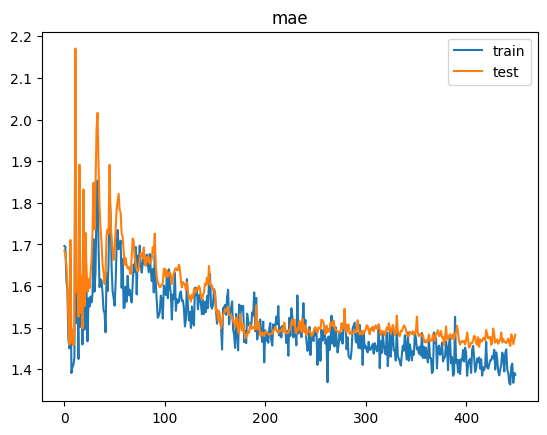

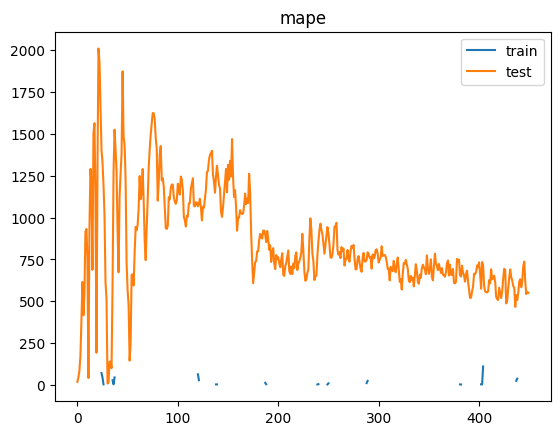

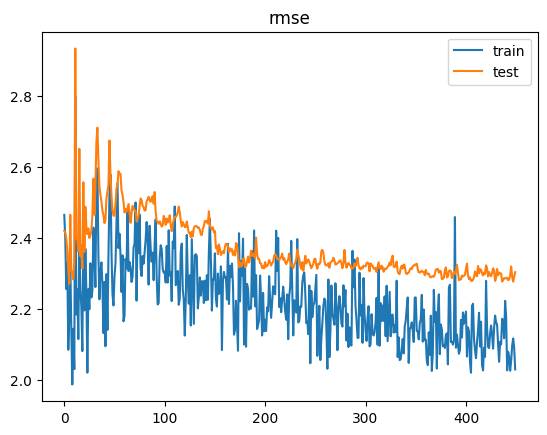

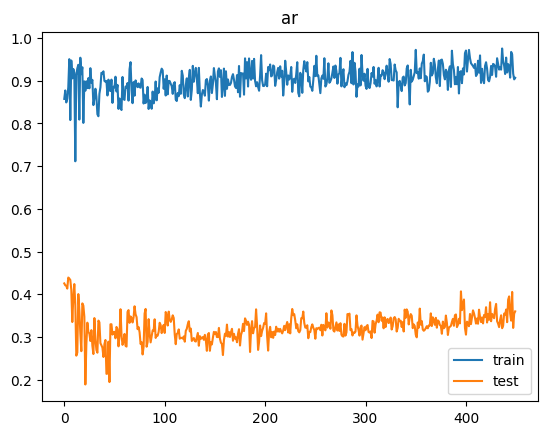

2/2 [==============================] - 1s 3ms/step


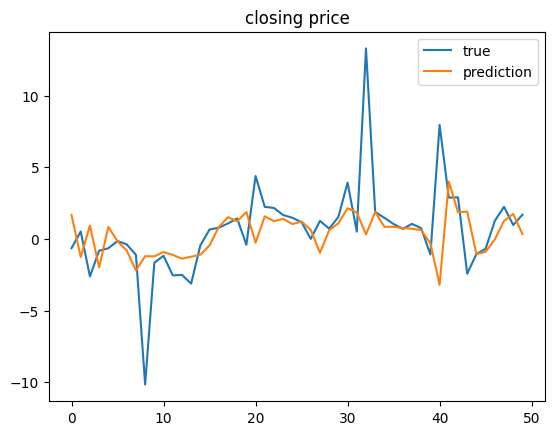

[MSE Baseline] train: 3.6533681513131713  test: 5.002352560408067
Delta time with epochs = 450: 0:07:53.597676
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 0.9452841281890869 sec Generator Loss: 0.7966286540031433,  Discriminator_loss: 1.3554155826568604
Time for epoch 52 is 0.9605674743652344 sec Generator Loss: 0.7885887026786804,  Discriminator_loss: 1.3541615009307861
Time for epoch 53 is 0.9468023777008057 sec Generator Loss: 0.7914147973060608,  Discriminator_loss: 1.3513810634613037
Time for epoch 54 is 0.990807294845581 sec Generator Loss: 0.785297691822052,  Discriminator_loss: 1.3539198637008667
Time for epoch 55 is 0.9267134666442871 sec Generator Loss: 0.7830762267112732,  Discriminator_loss: 1.3601678609848022
Time for epoch 56 is 0.9282963275909424 sec Generator Loss: 0.7829962968826294,  Discriminator_loss: 1.3530644178390503
Time for epoch 57 is 0.9557950496673584 sec Generator Loss: 0.8026770353317261,  Discriminator_loss: 1.3565421104431152
Time for epoch 58 is 0.951737642288208 sec Generator Loss: 0.7889658808708191,  Discriminator_loss: 1.3580615520477295
Time for epoch 59 is 0.9759426116943359 sec

Time for epoch 120 is 0.9811513423919678 sec Generator Loss: 0.778867244720459,  Discriminator_loss: 1.3612759113311768
Time for epoch 121 is 1.0206334590911865 sec Generator Loss: 0.7776816487312317,  Discriminator_loss: 1.3605934381484985
Time for epoch 122 is 1.00872802734375 sec Generator Loss: 0.772341787815094,  Discriminator_loss: 1.3608518838882446
Time for epoch 123 is 0.9900100231170654 sec Generator Loss: 0.7784528136253357,  Discriminator_loss: 1.3582062721252441
Time for epoch 124 is 0.9990906715393066 sec Generator Loss: 0.7756844758987427,  Discriminator_loss: 1.3625693321228027
Time for epoch 125 is 0.9635524749755859 sec Generator Loss: 0.7847495675086975,  Discriminator_loss: 1.3634004592895508
Time for epoch 126 is 0.9963197708129883 sec Generator Loss: 0.7820823192596436,  Discriminator_loss: 1.3639142513275146
Time for epoch 127 is 0.9755361080169678 sec Generator Loss: 0.775855302810669,  Discriminator_loss: 1.3632396459579468
Time for epoch 128 is 0.9898869991302

Time for epoch 189 is 1.0208015441894531 sec Generator Loss: 0.78066486120224,  Discriminator_loss: 1.3627793788909912
Time for epoch 190 is 1.0606541633605957 sec Generator Loss: 0.7762058973312378,  Discriminator_loss: 1.3641433715820312
Time for epoch 191 is 1.2328152656555176 sec Generator Loss: 0.7782549262046814,  Discriminator_loss: 1.3606338500976562
Time for epoch 192 is 1.2452754974365234 sec Generator Loss: 0.7739505171775818,  Discriminator_loss: 1.366219162940979
Time for epoch 193 is 1.1347322463989258 sec Generator Loss: 0.7767683267593384,  Discriminator_loss: 1.36309015750885
Time for epoch 194 is 1.1154906749725342 sec Generator Loss: 0.7746250033378601,  Discriminator_loss: 1.3662267923355103
Time for epoch 195 is 1.101804494857788 sec Generator Loss: 0.7715457677841187,  Discriminator_loss: 1.3664897680282593
Time for epoch 196 is 1.2203445434570312 sec Generator Loss: 0.7736520171165466,  Discriminator_loss: 1.3668638467788696
Time for epoch 197 is 1.04817771911621

Time for epoch 258 is 0.9466872215270996 sec Generator Loss: 0.7716819047927856,  Discriminator_loss: 1.3652112483978271
Time for epoch 259 is 1.018286943435669 sec Generator Loss: 0.7710960507392883,  Discriminator_loss: 1.367680549621582
Time for epoch 260 is 0.9451999664306641 sec Generator Loss: 0.7864748239517212,  Discriminator_loss: 1.3631809949874878
Time for epoch 261 is 0.938086986541748 sec Generator Loss: 0.7767744660377502,  Discriminator_loss: 1.3661993741989136
Time for epoch 262 is 1.0017588138580322 sec Generator Loss: 0.7684933543205261,  Discriminator_loss: 1.362845778465271
Time for epoch 263 is 0.9464974403381348 sec Generator Loss: 0.7776801586151123,  Discriminator_loss: 1.3593336343765259
Time for epoch 264 is 0.9691810607910156 sec Generator Loss: 0.7840577363967896,  Discriminator_loss: 1.3555911779403687
Time for epoch 265 is 0.93979811668396 sec Generator Loss: 0.7801259756088257,  Discriminator_loss: 1.360792636871338
Time for epoch 266 is 0.951241016387939

Time for epoch 327 is 0.9472613334655762 sec Generator Loss: 0.7676962614059448,  Discriminator_loss: 1.3604093790054321
Time for epoch 328 is 1.0482947826385498 sec Generator Loss: 0.7740301489830017,  Discriminator_loss: 1.3625067472457886
Time for epoch 329 is 0.9679920673370361 sec Generator Loss: 0.7863516211509705,  Discriminator_loss: 1.3562365770339966
Time for epoch 330 is 1.0087361335754395 sec Generator Loss: 0.780802309513092,  Discriminator_loss: 1.360408067703247
Time for epoch 331 is 0.9795589447021484 sec Generator Loss: 0.7819562554359436,  Discriminator_loss: 1.357835292816162
Time for epoch 332 is 0.9592323303222656 sec Generator Loss: 0.7769432663917542,  Discriminator_loss: 1.3572388887405396
Time for epoch 333 is 1.020075798034668 sec Generator Loss: 0.7792678475379944,  Discriminator_loss: 1.3597015142440796
Time for epoch 334 is 0.9961013793945312 sec Generator Loss: 0.7766695022583008,  Discriminator_loss: 1.3618574142456055
Time for epoch 335 is 1.035564899444

Time for epoch 395 is 0.9895427227020264 sec Generator Loss: 0.776195228099823,  Discriminator_loss: 1.3618100881576538
Time for epoch 396 is 1.0188519954681396 sec Generator Loss: 0.7853000164031982,  Discriminator_loss: 1.359238624572754
Time for epoch 397 is 0.9941701889038086 sec Generator Loss: 0.7775670886039734,  Discriminator_loss: 1.3597891330718994
Time for epoch 398 is 0.9842901229858398 sec Generator Loss: 0.7818750143051147,  Discriminator_loss: 1.3591902256011963
Time for epoch 399 is 1.0634503364562988 sec Generator Loss: 0.7731618881225586,  Discriminator_loss: 1.3602937459945679
Time for epoch 400 is 0.9813215732574463 sec Generator Loss: 0.7808208465576172,  Discriminator_loss: 1.360791802406311
Time for epoch 401 is 0.9821836948394775 sec Generator Loss: 0.7744500041007996,  Discriminator_loss: 1.361680030822754
Time for epoch 402 is 0.9718625545501709 sec Generator Loss: 0.7710243463516235,  Discriminator_loss: 1.3639070987701416
Time for epoch 403 is 0.975982189178

Time for epoch 464 is 1.0304269790649414 sec Generator Loss: 0.7765812277793884,  Discriminator_loss: 1.3591362237930298
Time for epoch 465 is 0.9975440502166748 sec Generator Loss: 0.7769082188606262,  Discriminator_loss: 1.3575316667556763
Time for epoch 466 is 1.003877878189087 sec Generator Loss: 0.7703230381011963,  Discriminator_loss: 1.3645259141921997
Time for epoch 467 is 1.1142053604125977 sec Generator Loss: 0.7756254076957703,  Discriminator_loss: 1.3591705560684204
Time for epoch 468 is 1.0275774002075195 sec Generator Loss: 0.7765737771987915,  Discriminator_loss: 1.3572672605514526
Time for epoch 469 is 0.9977271556854248 sec Generator Loss: 0.7765071392059326,  Discriminator_loss: 1.3578523397445679
Time for epoch 470 is 0.9839212894439697 sec Generator Loss: 0.7873954772949219,  Discriminator_loss: 1.3534647226333618
Time for epoch 471 is 1.0108070373535156 sec Generator Loss: 0.78905189037323,  Discriminator_loss: 1.3586199283599854
Time for epoch 472 is 0.97824454307

Time for epoch 532 is 0.9925622940063477 sec Generator Loss: 0.7817568182945251,  Discriminator_loss: 1.3548182249069214
Time for epoch 533 is 0.9678652286529541 sec Generator Loss: 0.7734666466712952,  Discriminator_loss: 1.3585261106491089
Time for epoch 534 is 0.9888956546783447 sec Generator Loss: 0.7854198217391968,  Discriminator_loss: 1.3543519973754883
Time for epoch 535 is 0.9624536037445068 sec Generator Loss: 0.782597005367279,  Discriminator_loss: 1.3597854375839233
Time for epoch 536 is 0.9919724464416504 sec Generator Loss: 0.7845900058746338,  Discriminator_loss: 1.3575043678283691
Time for epoch 537 is 0.9615466594696045 sec Generator Loss: 0.7793460488319397,  Discriminator_loss: 1.3562363386154175
Time for epoch 538 is 0.9636485576629639 sec Generator Loss: 0.7766294479370117,  Discriminator_loss: 1.354891300201416
Time for epoch 539 is 1.0152771472930908 sec Generator Loss: 0.7899742722511292,  Discriminator_loss: 1.3538479804992676
Time for epoch 540 is 0.9591345787

Time for epoch 600 is 1.026365041732788 sec Generator Loss: 0.7907455563545227,  Discriminator_loss: 1.351967453956604
Time for epoch 601 is 0.9787333011627197 sec Generator Loss: 0.7839282751083374,  Discriminator_loss: 1.3588893413543701
Time for epoch 602 is 1.0038559436798096 sec Generator Loss: 0.7814047336578369,  Discriminator_loss: 1.3562148809432983
Time for epoch 603 is 0.9618167877197266 sec Generator Loss: 0.7861048579216003,  Discriminator_loss: 1.3520328998565674
Time for epoch 604 is 0.9869725704193115 sec Generator Loss: 0.7880097031593323,  Discriminator_loss: 1.353870153427124
Time for epoch 605 is 1.0091638565063477 sec Generator Loss: 0.7815130352973938,  Discriminator_loss: 1.3583893775939941
Time for epoch 606 is 0.97379469871521 sec Generator Loss: 0.7882522940635681,  Discriminator_loss: 1.3548754453659058
Time for epoch 607 is 0.9484212398529053 sec Generator Loss: 0.7795656323432922,  Discriminator_loss: 1.3565571308135986
Time for epoch 608 is 0.9534754753112

Time for epoch 669 is 0.9773404598236084 sec Generator Loss: 0.7864994406700134,  Discriminator_loss: 1.3507572412490845
Time for epoch 670 is 0.970015287399292 sec Generator Loss: 0.7807652354240417,  Discriminator_loss: 1.3521493673324585
Time for epoch 671 is 0.9408574104309082 sec Generator Loss: 0.794677197933197,  Discriminator_loss: 1.3489192724227905
Time for epoch 672 is 0.9466922283172607 sec Generator Loss: 0.788730263710022,  Discriminator_loss: 1.3582448959350586
Time for epoch 673 is 0.9938347339630127 sec Generator Loss: 0.7890105247497559,  Discriminator_loss: 1.3497804403305054
Time for epoch 674 is 1.0082120895385742 sec Generator Loss: 0.795680820941925,  Discriminator_loss: 1.3545572757720947
Time for epoch 675 is 1.0090694427490234 sec Generator Loss: 0.7898165583610535,  Discriminator_loss: 1.3565332889556885
Time for epoch 676 is 1.0058495998382568 sec Generator Loss: 0.784253716468811,  Discriminator_loss: 1.3499884605407715
Time for epoch 677 is 1.0066061019897

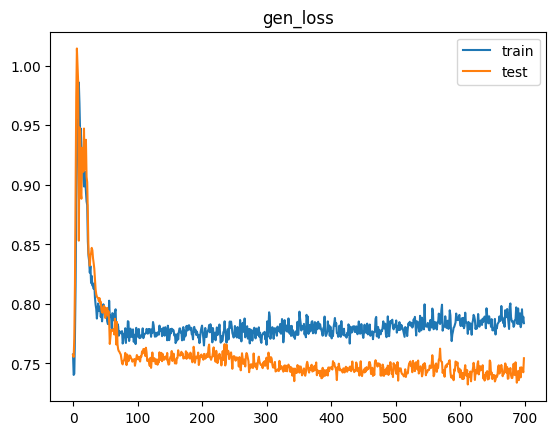

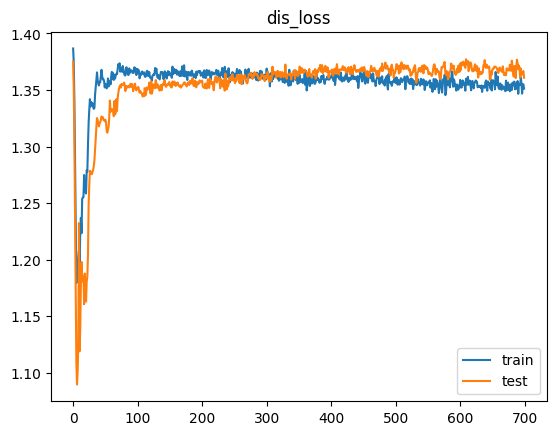

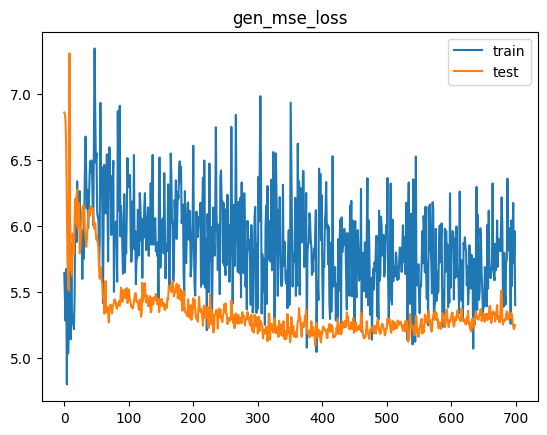

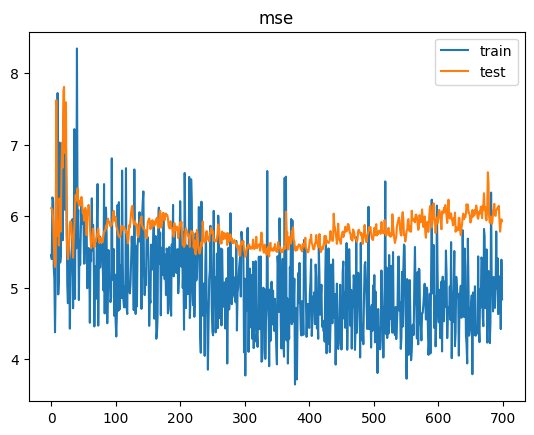

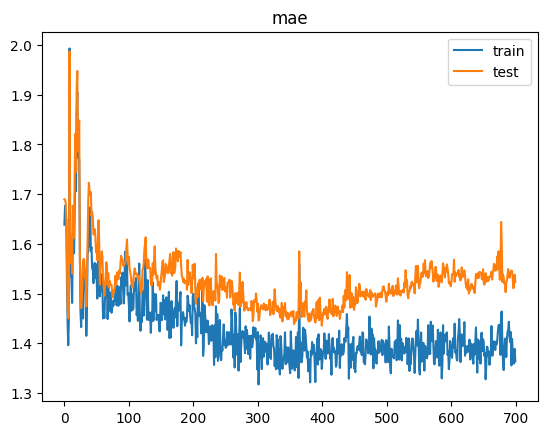

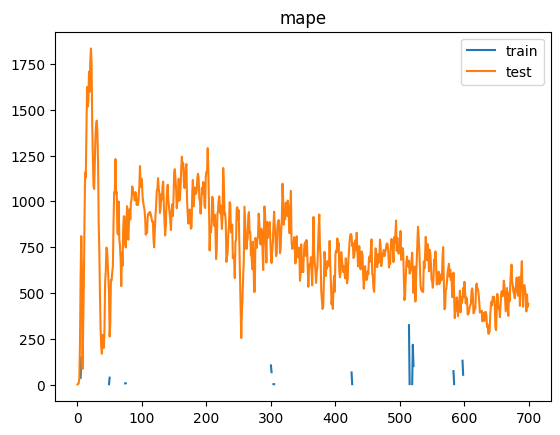

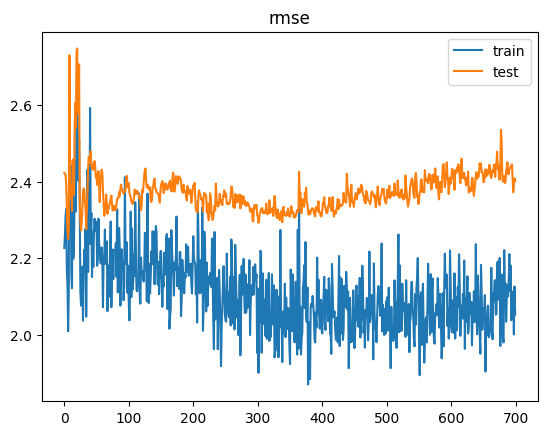

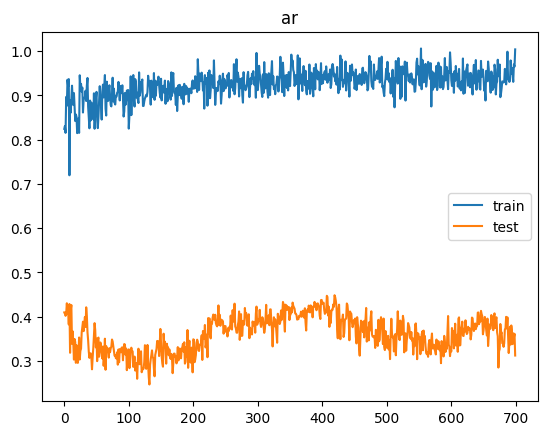

2/2 [==============================] - 1s 4ms/step


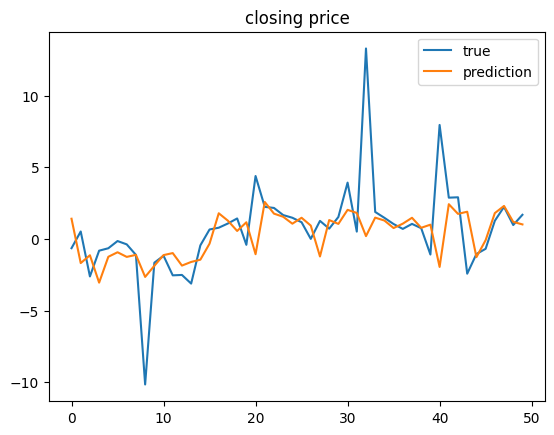

[MSE Baseline] train: 4.4549394718421045  test: 5.002352560408067
Delta time with epochs = 700: 0:12:16.487976
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 1.0046274662017822 sec Generator Loss: 0.8128125667572021,  Discriminator_loss: 1.3611582517623901
Time for epoch 52 is 1.0280811786651611 sec Generator Loss: 0.8071134686470032,  Discriminator_loss: 1.359779953956604
Time for epoch 53 is 1.0557608604431152 sec Generator Loss: 0.8031376004219055,  Discriminator_loss: 1.3584047555923462
Time for epoch 54 is 0.9907703399658203 sec Generator Loss: 0.8164862394332886,  Discriminator_loss: 1.3471660614013672
Time for epoch 55 is 1.0440788269042969 sec Generator Loss: 0.7968794703483582,  Discriminator_loss: 1.3592712879180908
Time for epoch 56 is 1.0142707824707031 sec Generator Loss: 0.7963102459907532,  Discriminator_loss: 1.3559399843215942
Time for epoch 57 is 1.0391771793365479 sec Generator Loss: 0.7858655452728271,  Discriminator_loss: 1.3515170812606812
Time for epoch 58 is 1.0295414924621582 sec Generator Loss: 0.7861019372940063,  Discriminator_loss: 1.3528295755386353
Time for epoch 59 is 1.006242275238037 se

Time for epoch 120 is 0.9974043369293213 sec Generator Loss: 0.7780535221099854,  Discriminator_loss: 1.371440052986145
Time for epoch 121 is 1.1047990322113037 sec Generator Loss: 0.7783789038658142,  Discriminator_loss: 1.365921139717102
Time for epoch 122 is 1.0185518264770508 sec Generator Loss: 0.7765359282493591,  Discriminator_loss: 1.374106526374817
Time for epoch 123 is 0.9626345634460449 sec Generator Loss: 0.7758415341377258,  Discriminator_loss: 1.3677979707717896
Time for epoch 124 is 1.0339007377624512 sec Generator Loss: 0.7712972164154053,  Discriminator_loss: 1.372736930847168
Time for epoch 125 is 1.090205430984497 sec Generator Loss: 0.7696285247802734,  Discriminator_loss: 1.368338942527771
Time for epoch 126 is 1.0340754985809326 sec Generator Loss: 0.7637379765510559,  Discriminator_loss: 1.369857668876648
Time for epoch 127 is 1.073347568511963 sec Generator Loss: 0.7711251974105835,  Discriminator_loss: 1.3688127994537354
Time for epoch 128 is 1.0440053939819336

Time for epoch 189 is 1.082486867904663 sec Generator Loss: 0.772360622882843,  Discriminator_loss: 1.3694348335266113
Time for epoch 190 is 1.0700325965881348 sec Generator Loss: 0.7717451453208923,  Discriminator_loss: 1.3611646890640259
Time for epoch 191 is 1.0400710105895996 sec Generator Loss: 0.7737843990325928,  Discriminator_loss: 1.3680751323699951
Time for epoch 192 is 1.043283224105835 sec Generator Loss: 0.7773677110671997,  Discriminator_loss: 1.3678090572357178
Time for epoch 193 is 1.0885183811187744 sec Generator Loss: 0.7672028541564941,  Discriminator_loss: 1.3680022954940796
Time for epoch 194 is 1.048415184020996 sec Generator Loss: 0.7721271514892578,  Discriminator_loss: 1.3667083978652954
Time for epoch 195 is 1.036214828491211 sec Generator Loss: 0.7799477577209473,  Discriminator_loss: 1.3661442995071411
Time for epoch 196 is 1.0359570980072021 sec Generator Loss: 0.770783007144928,  Discriminator_loss: 1.3677574396133423
Time for epoch 197 is 1.02456974983215

Time for epoch 258 is 1.0852594375610352 sec Generator Loss: 0.7714747190475464,  Discriminator_loss: 1.3663485050201416
Time for epoch 259 is 1.055030345916748 sec Generator Loss: 0.7772050499916077,  Discriminator_loss: 1.361338496208191
Time for epoch 260 is 1.1638507843017578 sec Generator Loss: 0.7740990519523621,  Discriminator_loss: 1.3636568784713745
Time for epoch 261 is 1.0874443054199219 sec Generator Loss: 0.7757127285003662,  Discriminator_loss: 1.3597538471221924
Time for epoch 262 is 1.0621705055236816 sec Generator Loss: 0.7753851413726807,  Discriminator_loss: 1.3631771802902222
Time for epoch 263 is 1.0816824436187744 sec Generator Loss: 0.7746595740318298,  Discriminator_loss: 1.361393928527832
Time for epoch 264 is 1.0547606945037842 sec Generator Loss: 0.7810490727424622,  Discriminator_loss: 1.3645646572113037
Time for epoch 265 is 1.0553677082061768 sec Generator Loss: 0.7759535312652588,  Discriminator_loss: 1.3609626293182373
Time for epoch 266 is 1.02633523941

Time for epoch 327 is 0.9694714546203613 sec Generator Loss: 0.7816375494003296,  Discriminator_loss: 1.3578448295593262
Time for epoch 328 is 0.9746613502502441 sec Generator Loss: 0.7835835814476013,  Discriminator_loss: 1.356071949005127
Time for epoch 329 is 0.9759848117828369 sec Generator Loss: 0.7764279842376709,  Discriminator_loss: 1.3584309816360474
Time for epoch 330 is 1.0422568321228027 sec Generator Loss: 0.7841166257858276,  Discriminator_loss: 1.356903314590454
Time for epoch 331 is 0.9675412178039551 sec Generator Loss: 0.7832033038139343,  Discriminator_loss: 1.3533251285552979
Time for epoch 332 is 0.9768269062042236 sec Generator Loss: 0.7813294529914856,  Discriminator_loss: 1.3529784679412842
Time for epoch 333 is 0.9703884124755859 sec Generator Loss: 0.7940581440925598,  Discriminator_loss: 1.349153757095337
Time for epoch 334 is 0.9512360095977783 sec Generator Loss: 0.7800930738449097,  Discriminator_loss: 1.3544307947158813
Time for epoch 335 is 1.06569218635

Time for epoch 396 is 0.9514122009277344 sec Generator Loss: 0.7829234600067139,  Discriminator_loss: 1.350930094718933
Time for epoch 397 is 0.9550151824951172 sec Generator Loss: 0.783201277256012,  Discriminator_loss: 1.356455683708191
Time for epoch 398 is 0.9414610862731934 sec Generator Loss: 0.7944076061248779,  Discriminator_loss: 1.3502774238586426
Time for epoch 399 is 0.9815924167633057 sec Generator Loss: 0.7866525650024414,  Discriminator_loss: 1.360125184059143
Time for epoch 400 is 0.9631557464599609 sec Generator Loss: 0.7909549474716187,  Discriminator_loss: 1.348109483718872
Time for epoch 401 is 0.9296026229858398 sec Generator Loss: 0.7873903512954712,  Discriminator_loss: 1.34874427318573
Time for epoch 402 is 0.9259607791900635 sec Generator Loss: 0.788031816482544,  Discriminator_loss: 1.352054238319397
Time for epoch 403 is 0.9373948574066162 sec Generator Loss: 0.7939538359642029,  Discriminator_loss: 1.3574408292770386
Time for epoch 404 is 0.9996893405914307 

Time for epoch 465 is 1.113771915435791 sec Generator Loss: 0.7887575626373291,  Discriminator_loss: 1.3475751876831055
Time for epoch 466 is 1.2246654033660889 sec Generator Loss: 0.7936633825302124,  Discriminator_loss: 1.3446991443634033
Time for epoch 467 is 1.2181758880615234 sec Generator Loss: 0.7900891900062561,  Discriminator_loss: 1.3479061126708984
Time for epoch 468 is 1.1272406578063965 sec Generator Loss: 0.785743236541748,  Discriminator_loss: 1.3530598878860474
Time for epoch 469 is 1.0532500743865967 sec Generator Loss: 0.7839719653129578,  Discriminator_loss: 1.3588042259216309
Time for epoch 470 is 1.2253427505493164 sec Generator Loss: 0.7926070690155029,  Discriminator_loss: 1.3505735397338867
Time for epoch 471 is 1.3221819400787354 sec Generator Loss: 0.8030152320861816,  Discriminator_loss: 1.3453376293182373
Time for epoch 472 is 1.3606774806976318 sec Generator Loss: 0.7901397347450256,  Discriminator_loss: 1.3509745597839355
Time for epoch 473 is 1.4794912338

Time for epoch 533 is 1.1744000911712646 sec Generator Loss: 0.801079511642456,  Discriminator_loss: 1.3396449089050293
Time for epoch 534 is 1.2680246829986572 sec Generator Loss: 0.798419177532196,  Discriminator_loss: 1.3483779430389404
Time for epoch 535 is 1.1437783241271973 sec Generator Loss: 0.7955179810523987,  Discriminator_loss: 1.3496280908584595
Time for epoch 536 is 1.0689568519592285 sec Generator Loss: 0.7996282577514648,  Discriminator_loss: 1.3459231853485107
Time for epoch 537 is 1.0782406330108643 sec Generator Loss: 0.8056415915489197,  Discriminator_loss: 1.3388750553131104
Time for epoch 538 is 1.1186988353729248 sec Generator Loss: 0.7945520281791687,  Discriminator_loss: 1.3437438011169434
Time for epoch 539 is 1.0513873100280762 sec Generator Loss: 0.7942614555358887,  Discriminator_loss: 1.346144437789917
Time for epoch 540 is 1.005622148513794 sec Generator Loss: 0.8017935752868652,  Discriminator_loss: 1.342486023902893
Time for epoch 541 is 0.9869790077209

Time for epoch 602 is 1.4180269241333008 sec Generator Loss: 0.7962382435798645,  Discriminator_loss: 1.3516077995300293
Time for epoch 603 is 1.1507978439331055 sec Generator Loss: 0.8032882213592529,  Discriminator_loss: 1.3473553657531738
Time for epoch 604 is 1.1694200038909912 sec Generator Loss: 0.8022913336753845,  Discriminator_loss: 1.341985821723938
Time for epoch 605 is 1.1339223384857178 sec Generator Loss: 0.7947709560394287,  Discriminator_loss: 1.3429884910583496
Time for epoch 606 is 1.0306482315063477 sec Generator Loss: 0.7878466248512268,  Discriminator_loss: 1.350456714630127
Time for epoch 607 is 1.1557528972625732 sec Generator Loss: 0.7916879057884216,  Discriminator_loss: 1.3475823402404785
Time for epoch 608 is 1.2785542011260986 sec Generator Loss: 0.7994046211242676,  Discriminator_loss: 1.3447948694229126
Time for epoch 609 is 1.2160189151763916 sec Generator Loss: 0.7927502989768982,  Discriminator_loss: 1.3463618755340576
Time for epoch 610 is 1.1360113620

Time for epoch 671 is 0.9474050998687744 sec Generator Loss: 0.8019545078277588,  Discriminator_loss: 1.342892050743103
Time for epoch 672 is 0.9898669719696045 sec Generator Loss: 0.7975634932518005,  Discriminator_loss: 1.344773769378662
Time for epoch 673 is 0.9673290252685547 sec Generator Loss: 0.8069273233413696,  Discriminator_loss: 1.3351348638534546
Time for epoch 674 is 0.9509422779083252 sec Generator Loss: 0.7998087406158447,  Discriminator_loss: 1.3433632850646973
Time for epoch 675 is 0.9766879081726074 sec Generator Loss: 0.8031633496284485,  Discriminator_loss: 1.3465988636016846
Time for epoch 676 is 0.9334180355072021 sec Generator Loss: 0.8121774196624756,  Discriminator_loss: 1.3409709930419922
Time for epoch 677 is 0.9676339626312256 sec Generator Loss: 0.8015540242195129,  Discriminator_loss: 1.3464972972869873
Time for epoch 678 is 0.9427528381347656 sec Generator Loss: 0.7995780110359192,  Discriminator_loss: 1.3509986400604248
Time for epoch 679 is 0.9500534534

Time for epoch 740 is 1.0484087467193604 sec Generator Loss: 0.7972968220710754,  Discriminator_loss: 1.3493434190750122
Time for epoch 741 is 1.0450749397277832 sec Generator Loss: 0.8070520162582397,  Discriminator_loss: 1.3482403755187988
Time for epoch 742 is 1.0196809768676758 sec Generator Loss: 0.8072797060012817,  Discriminator_loss: 1.3446630239486694
Time for epoch 743 is 1.116112232208252 sec Generator Loss: 0.8036601543426514,  Discriminator_loss: 1.3488234281539917
Time for epoch 744 is 1.3119759559631348 sec Generator Loss: 0.8015272617340088,  Discriminator_loss: 1.3465280532836914
Time for epoch 745 is 1.0597927570343018 sec Generator Loss: 0.8004869818687439,  Discriminator_loss: 1.3404033184051514
Time for epoch 746 is 1.0037691593170166 sec Generator Loss: 0.7996865510940552,  Discriminator_loss: 1.3458329439163208
Time for epoch 747 is 0.9848198890686035 sec Generator Loss: 0.801543653011322,  Discriminator_loss: 1.3422788381576538
Time for epoch 748 is 1.1581614017

Time for epoch 809 is 1.1149122714996338 sec Generator Loss: 0.794751763343811,  Discriminator_loss: 1.350244402885437
Time for epoch 810 is 1.0481581687927246 sec Generator Loss: 0.7881827354431152,  Discriminator_loss: 1.3500491380691528
Time for epoch 811 is 1.1658649444580078 sec Generator Loss: 0.8093608617782593,  Discriminator_loss: 1.345189094543457
Time for epoch 812 is 1.1295888423919678 sec Generator Loss: 0.7981756925582886,  Discriminator_loss: 1.3494110107421875
Time for epoch 813 is 1.074671745300293 sec Generator Loss: 0.8071218729019165,  Discriminator_loss: 1.351366639137268
Time for epoch 814 is 1.0304391384124756 sec Generator Loss: 0.8001874685287476,  Discriminator_loss: 1.351851224899292
Time for epoch 815 is 1.0953576564788818 sec Generator Loss: 0.806281328201294,  Discriminator_loss: 1.3442758321762085
Time for epoch 816 is 1.0533926486968994 sec Generator Loss: 0.8077958226203918,  Discriminator_loss: 1.3416600227355957
Time for epoch 817 is 1.001113653182983

Time for epoch 878 is 1.1014988422393799 sec Generator Loss: 0.7950770854949951,  Discriminator_loss: 1.3457473516464233
Time for epoch 879 is 1.0635030269622803 sec Generator Loss: 0.8049862384796143,  Discriminator_loss: 1.3494374752044678
Time for epoch 880 is 1.1261935234069824 sec Generator Loss: 0.7957000732421875,  Discriminator_loss: 1.348779559135437
Time for epoch 881 is 1.134310245513916 sec Generator Loss: 0.803493857383728,  Discriminator_loss: 1.3436232805252075
Time for epoch 882 is 1.0778346061706543 sec Generator Loss: 0.8046023845672607,  Discriminator_loss: 1.3430538177490234
Time for epoch 883 is 1.075303316116333 sec Generator Loss: 0.806220293045044,  Discriminator_loss: 1.3399831056594849
Time for epoch 884 is 1.1453309059143066 sec Generator Loss: 0.7973142862319946,  Discriminator_loss: 1.3442891836166382
Time for epoch 885 is 1.4628221988677979 sec Generator Loss: 0.7989078760147095,  Discriminator_loss: 1.3448656797409058
Time for epoch 886 is 1.2616589069366

Time for epoch 946 is 0.9487850666046143 sec Generator Loss: 0.7914390563964844,  Discriminator_loss: 1.3507791757583618
Time for epoch 947 is 0.9672625064849854 sec Generator Loss: 0.8007645606994629,  Discriminator_loss: 1.3415048122406006
Time for epoch 948 is 0.8697030544281006 sec Generator Loss: 0.7999621629714966,  Discriminator_loss: 1.354482889175415
Time for epoch 949 is 0.8688604831695557 sec Generator Loss: 0.8035257458686829,  Discriminator_loss: 1.3533756732940674
Time for epoch 950 is 0.9710304737091064 sec Generator Loss: 0.8025506138801575,  Discriminator_loss: 1.3436578512191772


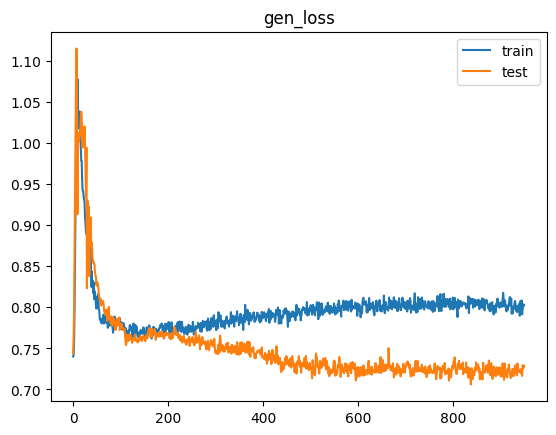

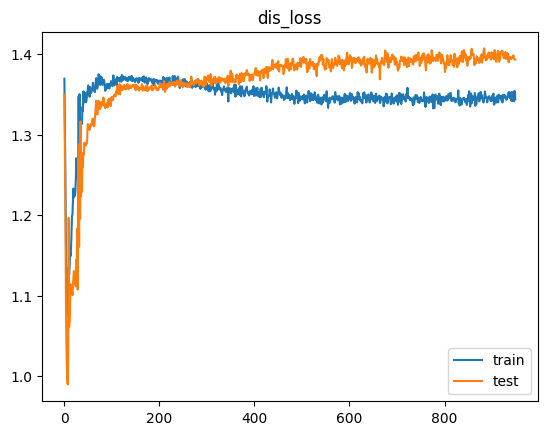

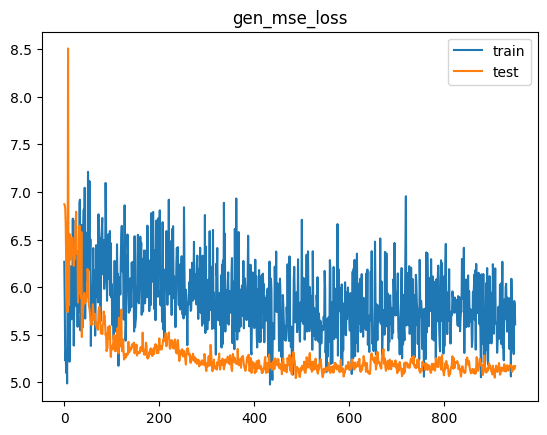

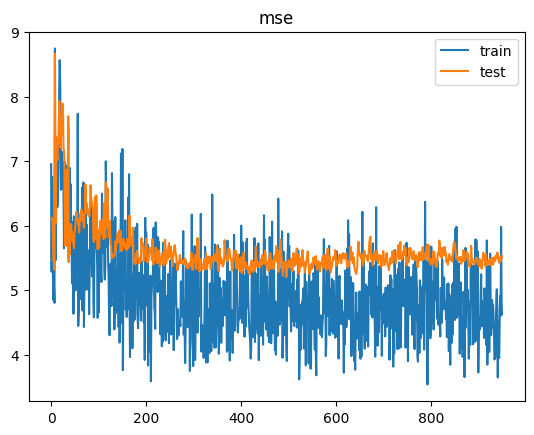

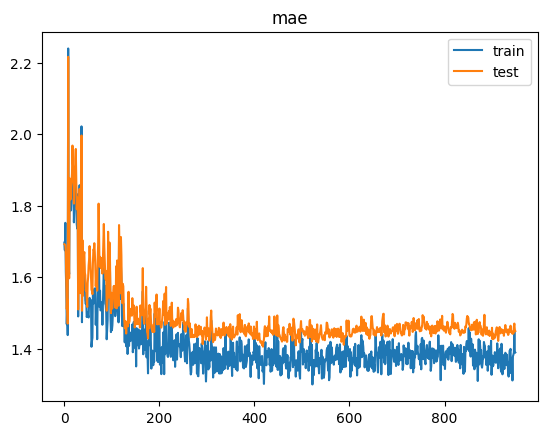

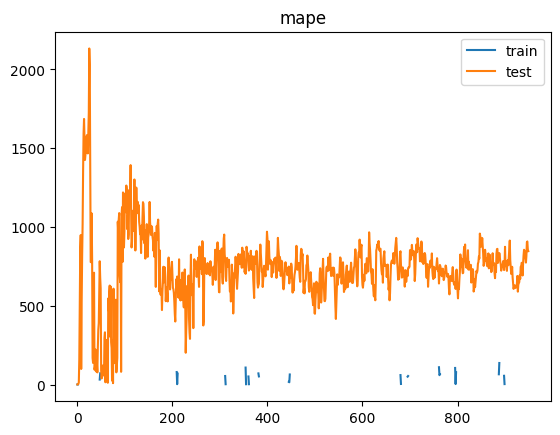

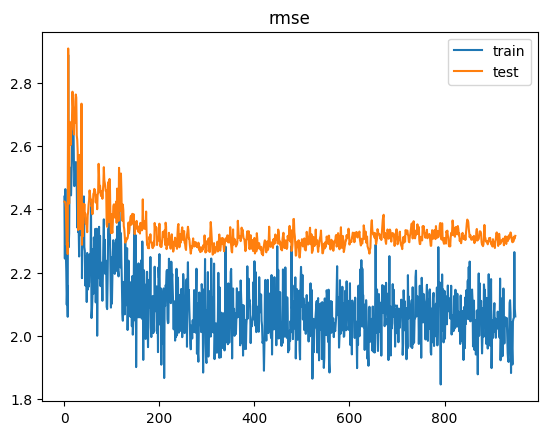

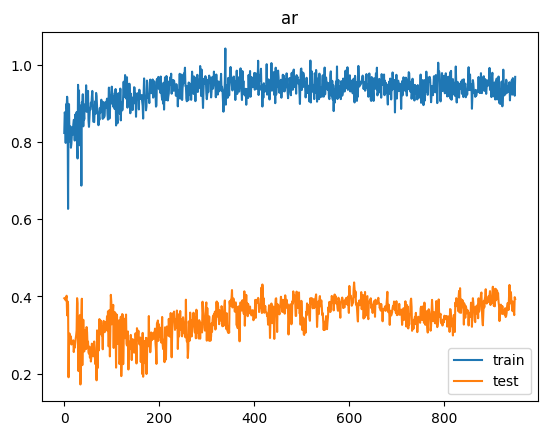

2/2 [==============================] - 0s 3ms/step


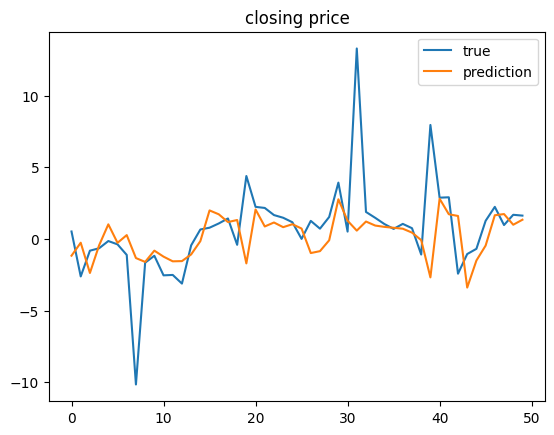

[MSE Baseline] train: 5.762781403871957  test: 5.010967196008289
Delta time with epochs = 950: 0:17:12.078086
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 20)             0         
               

Time for epoch 51 is 0.9916853904724121 sec Generator Loss: 0.8073534965515137,  Discriminator_loss: 1.3531794548034668
Time for epoch 52 is 1.0448353290557861 sec Generator Loss: 0.8134920001029968,  Discriminator_loss: 1.350285530090332
Time for epoch 53 is 1.008988857269287 sec Generator Loss: 0.8104603290557861,  Discriminator_loss: 1.348199725151062
Time for epoch 54 is 0.9816694259643555 sec Generator Loss: 0.8059263825416565,  Discriminator_loss: 1.3452855348587036
Time for epoch 55 is 0.9958674907684326 sec Generator Loss: 0.8012670278549194,  Discriminator_loss: 1.349450707435608
Time for epoch 56 is 1.000577688217163 sec Generator Loss: 0.8009660243988037,  Discriminator_loss: 1.3499739170074463
Time for epoch 57 is 0.9761018753051758 sec Generator Loss: 0.7858450412750244,  Discriminator_loss: 1.3560240268707275
Time for epoch 58 is 1.0251147747039795 sec Generator Loss: 0.7906846404075623,  Discriminator_loss: 1.3600488901138306
Time for epoch 59 is 0.9625334739685059 sec G

Time for epoch 120 is 1.1532847881317139 sec Generator Loss: 0.7835907936096191,  Discriminator_loss: 1.3522523641586304
Time for epoch 121 is 1.0715446472167969 sec Generator Loss: 0.7821080684661865,  Discriminator_loss: 1.3536509275436401
Time for epoch 122 is 1.1029980182647705 sec Generator Loss: 0.7852849364280701,  Discriminator_loss: 1.3492965698242188
Time for epoch 123 is 1.0712499618530273 sec Generator Loss: 0.7841612100601196,  Discriminator_loss: 1.3483043909072876
Time for epoch 124 is 1.0823771953582764 sec Generator Loss: 0.7828783988952637,  Discriminator_loss: 1.3533121347427368
Time for epoch 125 is 1.0995151996612549 sec Generator Loss: 0.7851435542106628,  Discriminator_loss: 1.3510998487472534
Time for epoch 126 is 1.1331017017364502 sec Generator Loss: 0.785956859588623,  Discriminator_loss: 1.3553102016448975
Time for epoch 127 is 1.0879456996917725 sec Generator Loss: 0.7856919765472412,  Discriminator_loss: 1.3519965410232544
Time for epoch 128 is 1.100923538

Time for epoch 189 is 1.0242111682891846 sec Generator Loss: 0.7844128012657166,  Discriminator_loss: 1.3596093654632568
Time for epoch 190 is 1.0019893646240234 sec Generator Loss: 0.7873362898826599,  Discriminator_loss: 1.3623164892196655
Time for epoch 191 is 1.0712471008300781 sec Generator Loss: 0.7830455899238586,  Discriminator_loss: 1.359227180480957
Time for epoch 192 is 1.0427930355072021 sec Generator Loss: 0.785654604434967,  Discriminator_loss: 1.3597310781478882
Time for epoch 193 is 1.048041820526123 sec Generator Loss: 0.7818856835365295,  Discriminator_loss: 1.3633350133895874
Time for epoch 194 is 1.0127630233764648 sec Generator Loss: 0.7735546231269836,  Discriminator_loss: 1.3615607023239136
Time for epoch 195 is 1.0036544799804688 sec Generator Loss: 0.7770025134086609,  Discriminator_loss: 1.3677459955215454
Time for epoch 196 is 1.0405378341674805 sec Generator Loss: 0.7866721749305725,  Discriminator_loss: 1.3625414371490479
Time for epoch 197 is 1.06048154830

Time for epoch 258 is 1.0569915771484375 sec Generator Loss: 0.7829750180244446,  Discriminator_loss: 1.3570990562438965
Time for epoch 259 is 1.0762624740600586 sec Generator Loss: 0.779320478439331,  Discriminator_loss: 1.3604754209518433
Time for epoch 260 is 1.048006534576416 sec Generator Loss: 0.7825964689254761,  Discriminator_loss: 1.3544014692306519
Time for epoch 261 is 1.0723717212677002 sec Generator Loss: 0.7912574410438538,  Discriminator_loss: 1.3488563299179077
Time for epoch 262 is 1.0262773036956787 sec Generator Loss: 0.787756085395813,  Discriminator_loss: 1.3582550287246704
Time for epoch 263 is 1.0527987480163574 sec Generator Loss: 0.7783229947090149,  Discriminator_loss: 1.3609538078308105
Time for epoch 264 is 1.0574243068695068 sec Generator Loss: 0.7737693190574646,  Discriminator_loss: 1.3642127513885498
Time for epoch 265 is 1.0028126239776611 sec Generator Loss: 0.7808852791786194,  Discriminator_loss: 1.3583734035491943
Time for epoch 266 is 1.14679384231

Time for epoch 327 is 1.047743320465088 sec Generator Loss: 0.793934166431427,  Discriminator_loss: 1.3476136922836304
Time for epoch 328 is 1.0412342548370361 sec Generator Loss: 0.7855651378631592,  Discriminator_loss: 1.354052186012268
Time for epoch 329 is 1.0390284061431885 sec Generator Loss: 0.78745436668396,  Discriminator_loss: 1.3485804796218872
Time for epoch 330 is 1.0048837661743164 sec Generator Loss: 0.7930099368095398,  Discriminator_loss: 1.3537578582763672
Time for epoch 331 is 1.0773639678955078 sec Generator Loss: 0.7913796901702881,  Discriminator_loss: 1.3499244451522827
Time for epoch 332 is 0.9950723648071289 sec Generator Loss: 0.7861539721488953,  Discriminator_loss: 1.347146987915039
Time for epoch 333 is 0.9927973747253418 sec Generator Loss: 0.7831627130508423,  Discriminator_loss: 1.3529425859451294
Time for epoch 334 is 1.021911859512329 sec Generator Loss: 0.782039999961853,  Discriminator_loss: 1.3518999814987183
Time for epoch 335 is 1.0284192562103271

Time for epoch 396 is 1.1381826400756836 sec Generator Loss: 0.7974244952201843,  Discriminator_loss: 1.3435605764389038
Time for epoch 397 is 1.0745487213134766 sec Generator Loss: 0.7944599390029907,  Discriminator_loss: 1.3486002683639526
Time for epoch 398 is 1.1041512489318848 sec Generator Loss: 0.7948684692382812,  Discriminator_loss: 1.3499449491500854
Time for epoch 399 is 1.1154913902282715 sec Generator Loss: 0.7906931638717651,  Discriminator_loss: 1.3468164205551147
Time for epoch 400 is 1.085038185119629 sec Generator Loss: 0.7931657433509827,  Discriminator_loss: 1.3476589918136597
Time for epoch 401 is 1.0373530387878418 sec Generator Loss: 0.7924362421035767,  Discriminator_loss: 1.3495216369628906
Time for epoch 402 is 1.0583112239837646 sec Generator Loss: 0.7867735624313354,  Discriminator_loss: 1.3503159284591675
Time for epoch 403 is 1.0761990547180176 sec Generator Loss: 0.7972226738929749,  Discriminator_loss: 1.3463679552078247
Time for epoch 404 is 1.100115776

Time for epoch 464 is 1.1067798137664795 sec Generator Loss: 0.7917256355285645,  Discriminator_loss: 1.3525270223617554
Time for epoch 465 is 1.065399169921875 sec Generator Loss: 0.7862370014190674,  Discriminator_loss: 1.3471879959106445
Time for epoch 466 is 1.1325056552886963 sec Generator Loss: 0.7912347316741943,  Discriminator_loss: 1.3544297218322754
Time for epoch 467 is 1.1395246982574463 sec Generator Loss: 0.7937960624694824,  Discriminator_loss: 1.350022315979004
Time for epoch 468 is 1.1058824062347412 sec Generator Loss: 0.7910840511322021,  Discriminator_loss: 1.3414337635040283
Time for epoch 469 is 1.130364179611206 sec Generator Loss: 0.7858429551124573,  Discriminator_loss: 1.3513356447219849
Time for epoch 470 is 1.0826804637908936 sec Generator Loss: 0.7897902131080627,  Discriminator_loss: 1.3455034494400024
Time for epoch 471 is 1.1002311706542969 sec Generator Loss: 0.7989596128463745,  Discriminator_loss: 1.3459583520889282
Time for epoch 472 is 1.04428339004

Time for epoch 533 is 1.075495958328247 sec Generator Loss: 0.7909212708473206,  Discriminator_loss: 1.3466154336929321
Time for epoch 534 is 1.04660964012146 sec Generator Loss: 0.7906253933906555,  Discriminator_loss: 1.345823884010315
Time for epoch 535 is 1.0386645793914795 sec Generator Loss: 0.791971743106842,  Discriminator_loss: 1.348417043685913
Time for epoch 536 is 1.1081359386444092 sec Generator Loss: 0.7896216511726379,  Discriminator_loss: 1.3500561714172363
Time for epoch 537 is 1.0299053192138672 sec Generator Loss: 0.7938446402549744,  Discriminator_loss: 1.345872402191162
Time for epoch 538 is 1.078742265701294 sec Generator Loss: 0.8005017638206482,  Discriminator_loss: 1.3471041917800903
Time for epoch 539 is 1.0618820190429688 sec Generator Loss: 0.794355034828186,  Discriminator_loss: 1.3454170227050781
Time for epoch 540 is 1.0625059604644775 sec Generator Loss: 0.7970776557922363,  Discriminator_loss: 1.3471314907073975
Time for epoch 541 is 1.095827341079712 s

Time for epoch 602 is 1.0205028057098389 sec Generator Loss: 0.7954167127609253,  Discriminator_loss: 1.3489934206008911
Time for epoch 603 is 1.0160741806030273 sec Generator Loss: 0.7919288873672485,  Discriminator_loss: 1.3461289405822754
Time for epoch 604 is 1.0220634937286377 sec Generator Loss: 0.7912711501121521,  Discriminator_loss: 1.3476920127868652
Time for epoch 605 is 1.0470552444458008 sec Generator Loss: 0.7995573282241821,  Discriminator_loss: 1.3479981422424316
Time for epoch 606 is 1.0411934852600098 sec Generator Loss: 0.7911354303359985,  Discriminator_loss: 1.3495306968688965
Time for epoch 607 is 1.0331144332885742 sec Generator Loss: 0.7984560132026672,  Discriminator_loss: 1.3407691717147827
Time for epoch 608 is 1.0416209697723389 sec Generator Loss: 0.7952525615692139,  Discriminator_loss: 1.34602952003479
Time for epoch 609 is 1.0327301025390625 sec Generator Loss: 0.789827287197113,  Discriminator_loss: 1.3428997993469238
Time for epoch 610 is 1.10056519508

Time for epoch 671 is 1.3033785820007324 sec Generator Loss: 0.7942755818367004,  Discriminator_loss: 1.3489484786987305
Time for epoch 672 is 1.1340525150299072 sec Generator Loss: 0.802787184715271,  Discriminator_loss: 1.3466955423355103
Time for epoch 673 is 1.2119925022125244 sec Generator Loss: 0.7963322401046753,  Discriminator_loss: 1.3461854457855225
Time for epoch 674 is 1.2659118175506592 sec Generator Loss: 0.8010187745094299,  Discriminator_loss: 1.3456865549087524
Time for epoch 675 is 1.2636775970458984 sec Generator Loss: 0.7979708313941956,  Discriminator_loss: 1.3444106578826904
Time for epoch 676 is 1.1669847965240479 sec Generator Loss: 0.7976402044296265,  Discriminator_loss: 1.3447539806365967
Time for epoch 677 is 1.1800105571746826 sec Generator Loss: 0.8040400147438049,  Discriminator_loss: 1.341306209564209
Time for epoch 678 is 1.2047080993652344 sec Generator Loss: 0.8030639886856079,  Discriminator_loss: 1.338844895362854
Time for epoch 679 is 1.05818080902

Time for epoch 740 is 1.1152994632720947 sec Generator Loss: 0.8019775748252869,  Discriminator_loss: 1.344754695892334
Time for epoch 741 is 1.0891809463500977 sec Generator Loss: 0.7927594184875488,  Discriminator_loss: 1.3479888439178467
Time for epoch 742 is 1.0754947662353516 sec Generator Loss: 0.7925323247909546,  Discriminator_loss: 1.3486130237579346
Time for epoch 743 is 1.0821070671081543 sec Generator Loss: 0.7935081124305725,  Discriminator_loss: 1.348793864250183
Time for epoch 744 is 1.1290662288665771 sec Generator Loss: 0.8022105097770691,  Discriminator_loss: 1.3462975025177002
Time for epoch 745 is 1.1065216064453125 sec Generator Loss: 0.800441324710846,  Discriminator_loss: 1.3406137228012085
Time for epoch 746 is 1.038116216659546 sec Generator Loss: 0.801124095916748,  Discriminator_loss: 1.3440754413604736
Time for epoch 747 is 1.0759656429290771 sec Generator Loss: 0.7980912327766418,  Discriminator_loss: 1.3480119705200195
Time for epoch 748 is 1.0823645591735

Time for epoch 809 is 1.010622262954712 sec Generator Loss: 0.7982887029647827,  Discriminator_loss: 1.3441107273101807
Time for epoch 810 is 1.0000252723693848 sec Generator Loss: 0.7957873940467834,  Discriminator_loss: 1.3446887731552124
Time for epoch 811 is 0.9637312889099121 sec Generator Loss: 0.8048877120018005,  Discriminator_loss: 1.3430900573730469
Time for epoch 812 is 1.0239298343658447 sec Generator Loss: 0.7944396734237671,  Discriminator_loss: 1.3484644889831543
Time for epoch 813 is 1.0083017349243164 sec Generator Loss: 0.7951637506484985,  Discriminator_loss: 1.3442723751068115
Time for epoch 814 is 1.0088884830474854 sec Generator Loss: 0.7953248023986816,  Discriminator_loss: 1.3478318452835083
Time for epoch 815 is 1.0251805782318115 sec Generator Loss: 0.8020626902580261,  Discriminator_loss: 1.3442015647888184
Time for epoch 816 is 0.9908080101013184 sec Generator Loss: 0.7926611304283142,  Discriminator_loss: 1.3508110046386719
Time for epoch 817 is 1.042752504

Time for epoch 878 is 1.0035550594329834 sec Generator Loss: 0.7998100519180298,  Discriminator_loss: 1.3469544649124146
Time for epoch 879 is 1.013913869857788 sec Generator Loss: 0.8072103261947632,  Discriminator_loss: 1.3406749963760376
Time for epoch 880 is 1.02793288230896 sec Generator Loss: 0.7950029373168945,  Discriminator_loss: 1.346282958984375
Time for epoch 881 is 1.007171630859375 sec Generator Loss: 0.8078286051750183,  Discriminator_loss: 1.3488587141036987
Time for epoch 882 is 1.0444378852844238 sec Generator Loss: 0.7983561158180237,  Discriminator_loss: 1.3477156162261963
Time for epoch 883 is 1.0267057418823242 sec Generator Loss: 0.7920181751251221,  Discriminator_loss: 1.3476722240447998
Time for epoch 884 is 0.9930999279022217 sec Generator Loss: 0.7951316833496094,  Discriminator_loss: 1.3501367568969727
Time for epoch 885 is 1.0470843315124512 sec Generator Loss: 0.8010908961296082,  Discriminator_loss: 1.3402516841888428
Time for epoch 886 is 1.0265619754791

Time for epoch 947 is 1.2481093406677246 sec Generator Loss: 0.8107434511184692,  Discriminator_loss: 1.3479225635528564
Time for epoch 948 is 1.2066824436187744 sec Generator Loss: 0.7979545593261719,  Discriminator_loss: 1.3450942039489746
Time for epoch 949 is 1.0594079494476318 sec Generator Loss: 0.7958267331123352,  Discriminator_loss: 1.3453724384307861
Time for epoch 950 is 1.0578861236572266 sec Generator Loss: 0.8053845167160034,  Discriminator_loss: 1.3485137224197388
Time for epoch 951 is 1.1050591468811035 sec Generator Loss: 0.795081615447998,  Discriminator_loss: 1.350890040397644
Time for epoch 952 is 1.0531914234161377 sec Generator Loss: 0.7953157424926758,  Discriminator_loss: 1.3507603406906128
Time for epoch 953 is 1.0488126277923584 sec Generator Loss: 0.794259786605835,  Discriminator_loss: 1.3522917032241821
Time for epoch 954 is 1.060525894165039 sec Generator Loss: 0.798643946647644,  Discriminator_loss: 1.3402695655822754
Time for epoch 955 is 1.0515754222869

Time for epoch 1016 is 1.0282063484191895 sec Generator Loss: 0.7989130020141602,  Discriminator_loss: 1.348745584487915
Time for epoch 1017 is 1.0382039546966553 sec Generator Loss: 0.8024519681930542,  Discriminator_loss: 1.344586730003357
Time for epoch 1018 is 1.0331628322601318 sec Generator Loss: 0.7953694462776184,  Discriminator_loss: 1.3462969064712524
Time for epoch 1019 is 1.0332660675048828 sec Generator Loss: 0.7992171049118042,  Discriminator_loss: 1.3482908010482788
Time for epoch 1020 is 1.1344401836395264 sec Generator Loss: 0.8019504547119141,  Discriminator_loss: 1.3452115058898926
Time for epoch 1021 is 1.0397703647613525 sec Generator Loss: 0.7893387079238892,  Discriminator_loss: 1.3498739004135132
Time for epoch 1022 is 1.1484158039093018 sec Generator Loss: 0.7964511513710022,  Discriminator_loss: 1.344882607460022
Time for epoch 1023 is 1.1273934841156006 sec Generator Loss: 0.8079385161399841,  Discriminator_loss: 1.343462586402893
Time for epoch 1024 is 1.202

Time for epoch 1084 is 1.02964448928833 sec Generator Loss: 0.8023790121078491,  Discriminator_loss: 1.350803017616272
Time for epoch 1085 is 1.0000190734863281 sec Generator Loss: 0.7896134853363037,  Discriminator_loss: 1.3506219387054443
Time for epoch 1086 is 0.9736814498901367 sec Generator Loss: 0.8006747961044312,  Discriminator_loss: 1.3388571739196777
Time for epoch 1087 is 0.9976930618286133 sec Generator Loss: 0.798096776008606,  Discriminator_loss: 1.344446063041687
Time for epoch 1088 is 1.0054645538330078 sec Generator Loss: 0.8032420873641968,  Discriminator_loss: 1.3469425439834595
Time for epoch 1089 is 1.0118811130523682 sec Generator Loss: 0.789882242679596,  Discriminator_loss: 1.3548648357391357
Time for epoch 1090 is 1.006819725036621 sec Generator Loss: 0.7954959869384766,  Discriminator_loss: 1.351365566253662
Time for epoch 1091 is 0.9791820049285889 sec Generator Loss: 0.7984386086463928,  Discriminator_loss: 1.3513002395629883
Time for epoch 1092 is 1.0054781

Time for epoch 1152 is 1.0218427181243896 sec Generator Loss: 0.7997856736183167,  Discriminator_loss: 1.3475126028060913
Time for epoch 1153 is 0.9969820976257324 sec Generator Loss: 0.8032369017601013,  Discriminator_loss: 1.3452218770980835
Time for epoch 1154 is 1.0253558158874512 sec Generator Loss: 0.8032389283180237,  Discriminator_loss: 1.347535252571106
Time for epoch 1155 is 1.055516242980957 sec Generator Loss: 0.799368143081665,  Discriminator_loss: 1.347605586051941
Time for epoch 1156 is 1.0140011310577393 sec Generator Loss: 0.8009722232818604,  Discriminator_loss: 1.3461296558380127
Time for epoch 1157 is 1.0900499820709229 sec Generator Loss: 0.8009607195854187,  Discriminator_loss: 1.3522614240646362
Time for epoch 1158 is 1.1697947978973389 sec Generator Loss: 0.7928009629249573,  Discriminator_loss: 1.3473933935165405
Time for epoch 1159 is 1.2365922927856445 sec Generator Loss: 0.791163444519043,  Discriminator_loss: 1.35197114944458
Time for epoch 1160 is 1.155881

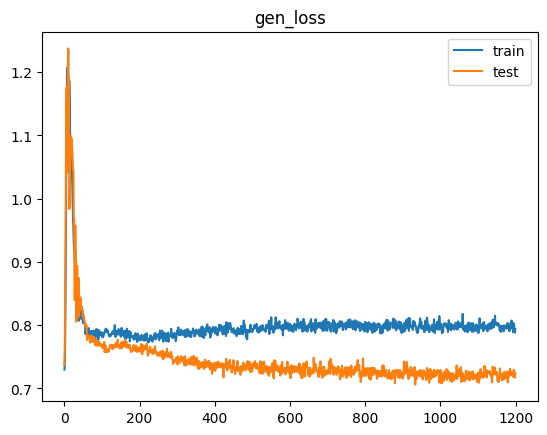

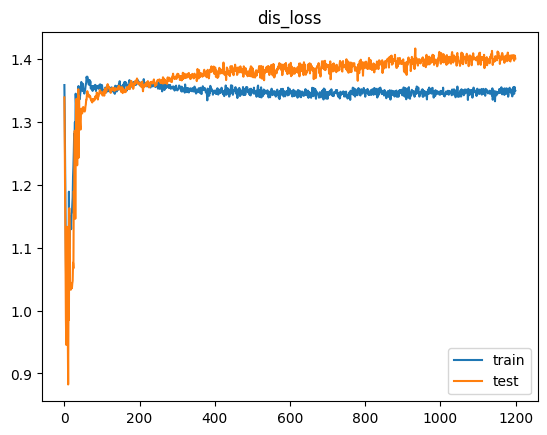

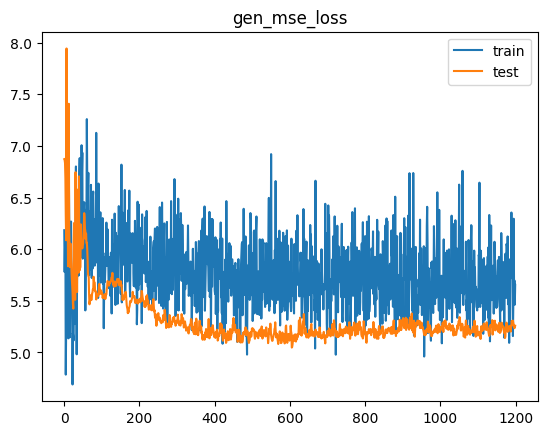

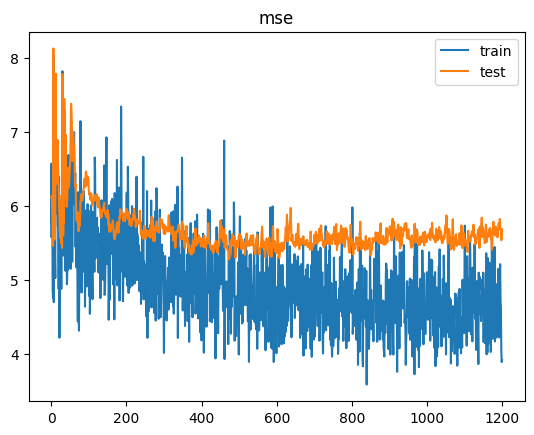

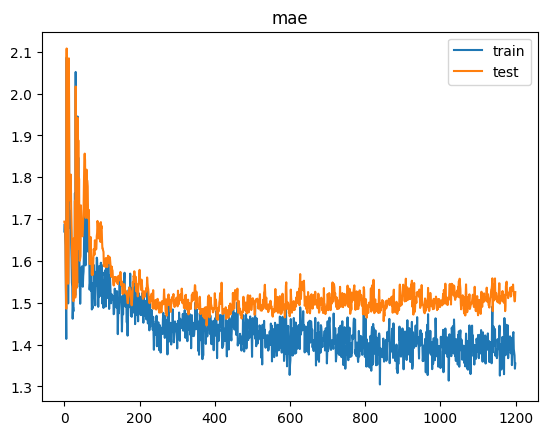

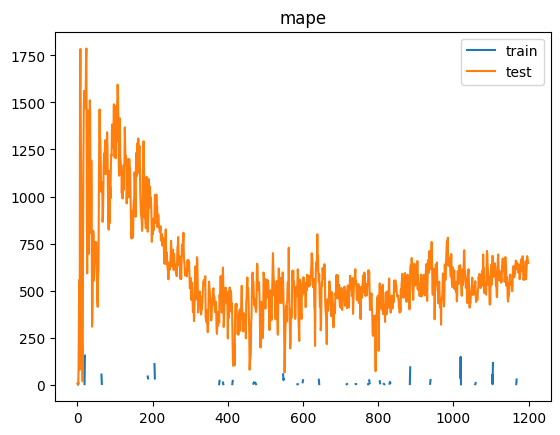

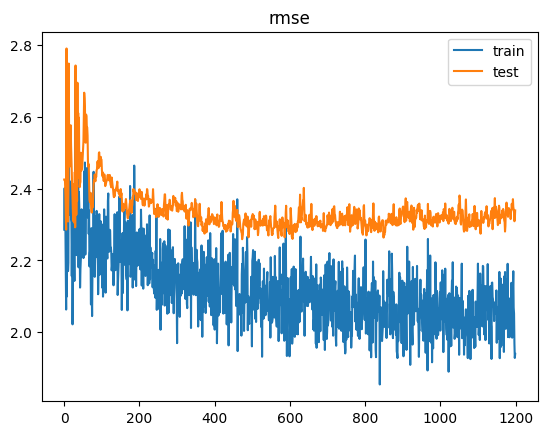

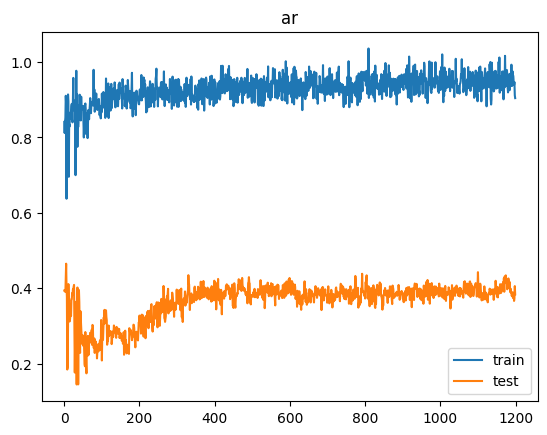

2/2 [==============================] - 1s 4ms/step


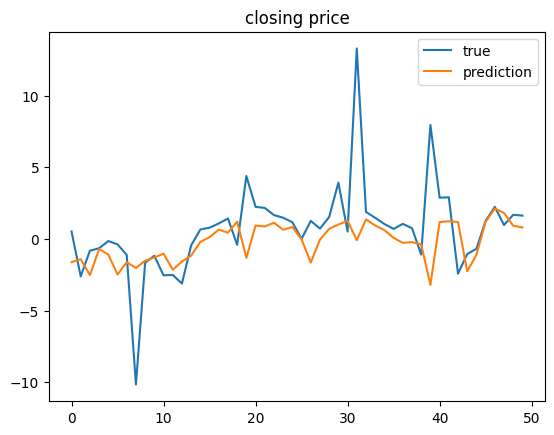

[MSE Baseline] train: 4.765007652822704  test: 5.010967196008289
Delta time with epochs = 1200: 0:21:59.140431
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 5, 20)            1440      
 onal)                                                           
                                                                 
 batch_normalization_10 (Bat  (None, 5, 20)            80        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 20)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 20)             0         
              

Time for epoch 51 is 1.0261471271514893 sec Generator Loss: 0.7955905199050903,  Discriminator_loss: 1.3550242185592651
Time for epoch 52 is 1.0360901355743408 sec Generator Loss: 0.790257453918457,  Discriminator_loss: 1.3524200916290283
Time for epoch 53 is 1.1460785865783691 sec Generator Loss: 0.7884599566459656,  Discriminator_loss: 1.3560433387756348
Time for epoch 54 is 1.2383534908294678 sec Generator Loss: 0.7981406450271606,  Discriminator_loss: 1.3495557308197021
Time for epoch 55 is 1.043276071548462 sec Generator Loss: 0.7875914573669434,  Discriminator_loss: 1.3604363203048706
Time for epoch 56 is 1.0468873977661133 sec Generator Loss: 0.7936859130859375,  Discriminator_loss: 1.3603918552398682
Time for epoch 57 is 1.1111693382263184 sec Generator Loss: 0.7911765575408936,  Discriminator_loss: 1.3723057508468628
Time for epoch 58 is 1.123047113418579 sec Generator Loss: 0.7821172475814819,  Discriminator_loss: 1.370997428894043
Time for epoch 59 is 1.0766816139221191 sec 

Time for epoch 120 is 1.0839869976043701 sec Generator Loss: 0.780197262763977,  Discriminator_loss: 1.3620247840881348
Time for epoch 121 is 1.1028482913970947 sec Generator Loss: 0.7723456621170044,  Discriminator_loss: 1.3601257801055908
Time for epoch 122 is 1.1121232509613037 sec Generator Loss: 0.7771288752555847,  Discriminator_loss: 1.3605549335479736
Time for epoch 123 is 1.0671136379241943 sec Generator Loss: 0.7721595168113708,  Discriminator_loss: 1.3659932613372803
Time for epoch 124 is 1.096092939376831 sec Generator Loss: 0.7750170230865479,  Discriminator_loss: 1.367842674255371
Time for epoch 125 is 1.0977451801300049 sec Generator Loss: 0.7833385467529297,  Discriminator_loss: 1.3650444746017456
Time for epoch 126 is 1.083000898361206 sec Generator Loss: 0.7685776948928833,  Discriminator_loss: 1.3653312921524048
Time for epoch 127 is 1.0814952850341797 sec Generator Loss: 0.7715558409690857,  Discriminator_loss: 1.3669240474700928
Time for epoch 128 is 1.118743896484

Time for epoch 189 is 1.0874848365783691 sec Generator Loss: 0.7793638706207275,  Discriminator_loss: 1.3584661483764648
Time for epoch 190 is 1.0832750797271729 sec Generator Loss: 0.7807987928390503,  Discriminator_loss: 1.3641425371170044
Time for epoch 191 is 1.042184591293335 sec Generator Loss: 0.7772826552391052,  Discriminator_loss: 1.3659461736679077
Time for epoch 192 is 1.0106945037841797 sec Generator Loss: 0.7799518704414368,  Discriminator_loss: 1.3602408170700073
Time for epoch 193 is 1.0210456848144531 sec Generator Loss: 0.7689842581748962,  Discriminator_loss: 1.3614684343338013
Time for epoch 194 is 1.025014877319336 sec Generator Loss: 0.7709871530532837,  Discriminator_loss: 1.3634765148162842
Time for epoch 195 is 1.051903486251831 sec Generator Loss: 0.7800957560539246,  Discriminator_loss: 1.3570547103881836
Time for epoch 196 is 1.04677152633667 sec Generator Loss: 0.7849107980728149,  Discriminator_loss: 1.3619353771209717
Time for epoch 197 is 0.9950735569000

Time for epoch 258 is 1.062546730041504 sec Generator Loss: 0.7821678519248962,  Discriminator_loss: 1.3566051721572876
Time for epoch 259 is 1.0333433151245117 sec Generator Loss: 0.777539849281311,  Discriminator_loss: 1.3546743392944336
Time for epoch 260 is 0.9991405010223389 sec Generator Loss: 0.7853450775146484,  Discriminator_loss: 1.3567090034484863
Time for epoch 261 is 1.0508012771606445 sec Generator Loss: 0.7784046530723572,  Discriminator_loss: 1.3590985536575317
Time for epoch 262 is 1.022228717803955 sec Generator Loss: 0.7833569049835205,  Discriminator_loss: 1.3589046001434326
Time for epoch 263 is 1.0498530864715576 sec Generator Loss: 0.7800658941268921,  Discriminator_loss: 1.3629251718521118
Time for epoch 264 is 1.0325891971588135 sec Generator Loss: 0.7848705649375916,  Discriminator_loss: 1.3543264865875244
Time for epoch 265 is 0.9866619110107422 sec Generator Loss: 0.7859674096107483,  Discriminator_loss: 1.3561646938323975
Time for epoch 266 is 0.99138641357

Time for epoch 327 is 1.3017191886901855 sec Generator Loss: 0.7931982278823853,  Discriminator_loss: 1.3529679775238037
Time for epoch 328 is 1.2127845287322998 sec Generator Loss: 0.7832015752792358,  Discriminator_loss: 1.3500380516052246
Time for epoch 329 is 1.2229228019714355 sec Generator Loss: 0.7852163314819336,  Discriminator_loss: 1.3505346775054932
Time for epoch 330 is 1.1973085403442383 sec Generator Loss: 0.788409948348999,  Discriminator_loss: 1.3563321828842163
Time for epoch 331 is 1.1814308166503906 sec Generator Loss: 0.7835814952850342,  Discriminator_loss: 1.3508797883987427
Time for epoch 332 is 1.2974853515625 sec Generator Loss: 0.7877610325813293,  Discriminator_loss: 1.3526155948638916
Time for epoch 333 is 1.1377711296081543 sec Generator Loss: 0.7849370241165161,  Discriminator_loss: 1.3500381708145142
Time for epoch 334 is 1.1670105457305908 sec Generator Loss: 0.7875388264656067,  Discriminator_loss: 1.3477892875671387
Time for epoch 335 is 1.165166139602

Time for epoch 396 is 1.206167459487915 sec Generator Loss: 0.797858715057373,  Discriminator_loss: 1.352392315864563
Time for epoch 397 is 1.2085835933685303 sec Generator Loss: 0.7915390133857727,  Discriminator_loss: 1.3487781286239624
Time for epoch 398 is 1.1839721202850342 sec Generator Loss: 0.7901330590248108,  Discriminator_loss: 1.3522785902023315
Time for epoch 399 is 1.2014331817626953 sec Generator Loss: 0.7860369086265564,  Discriminator_loss: 1.3487884998321533
Time for epoch 400 is 1.197420358657837 sec Generator Loss: 0.7934505343437195,  Discriminator_loss: 1.348768949508667
Time for epoch 401 is 1.1886956691741943 sec Generator Loss: 0.7919790744781494,  Discriminator_loss: 1.347481369972229
Time for epoch 402 is 1.1574311256408691 sec Generator Loss: 0.7886704206466675,  Discriminator_loss: 1.354938268661499
Time for epoch 403 is 1.1677875518798828 sec Generator Loss: 0.79136061668396,  Discriminator_loss: 1.3499194383621216
Time for epoch 404 is 1.1351549625396729 

Time for epoch 465 is 1.1009790897369385 sec Generator Loss: 0.7930402755737305,  Discriminator_loss: 1.3467708826065063
Time for epoch 466 is 1.177398920059204 sec Generator Loss: 0.7943906188011169,  Discriminator_loss: 1.349679708480835
Time for epoch 467 is 1.1133184432983398 sec Generator Loss: 0.7988559603691101,  Discriminator_loss: 1.3446385860443115
Time for epoch 468 is 1.003547191619873 sec Generator Loss: 0.795440673828125,  Discriminator_loss: 1.345910906791687
Time for epoch 469 is 1.1731250286102295 sec Generator Loss: 0.7910680174827576,  Discriminator_loss: 1.3485667705535889
Time for epoch 470 is 1.0990712642669678 sec Generator Loss: 0.7939640283584595,  Discriminator_loss: 1.349045991897583
Time for epoch 471 is 0.9908125400543213 sec Generator Loss: 0.7949156165122986,  Discriminator_loss: 1.3478049039840698
Time for epoch 472 is 1.0112180709838867 sec Generator Loss: 0.7887201905250549,  Discriminator_loss: 1.3506289720535278
Time for epoch 473 is 0.98761272430419

Time for epoch 534 is 0.9756276607513428 sec Generator Loss: 0.7931064367294312,  Discriminator_loss: 1.347877860069275
Time for epoch 535 is 0.9900307655334473 sec Generator Loss: 0.790917158126831,  Discriminator_loss: 1.3513087034225464
Time for epoch 536 is 1.006133794784546 sec Generator Loss: 0.7955290675163269,  Discriminator_loss: 1.3475090265274048
Time for epoch 537 is 0.9520618915557861 sec Generator Loss: 0.799514889717102,  Discriminator_loss: 1.3453079462051392
Time for epoch 538 is 0.9768602848052979 sec Generator Loss: 0.8003664016723633,  Discriminator_loss: 1.3521572351455688
Time for epoch 539 is 1.0583267211914062 sec Generator Loss: 0.797414243221283,  Discriminator_loss: 1.3502185344696045
Time for epoch 540 is 1.0090575218200684 sec Generator Loss: 0.7960348129272461,  Discriminator_loss: 1.3465853929519653
Time for epoch 541 is 1.1919615268707275 sec Generator Loss: 0.7944757342338562,  Discriminator_loss: 1.347604751586914
Time for epoch 542 is 1.15228867530822

Time for epoch 603 is 1.0096428394317627 sec Generator Loss: 0.7998315095901489,  Discriminator_loss: 1.346396565437317
Time for epoch 604 is 1.0022647380828857 sec Generator Loss: 0.7882255911827087,  Discriminator_loss: 1.349705457687378
Time for epoch 605 is 1.0118134021759033 sec Generator Loss: 0.784980058670044,  Discriminator_loss: 1.3484346866607666
Time for epoch 606 is 1.0421032905578613 sec Generator Loss: 0.7903598546981812,  Discriminator_loss: 1.3518109321594238
Time for epoch 607 is 0.9986522197723389 sec Generator Loss: 0.796951949596405,  Discriminator_loss: 1.3441771268844604
Time for epoch 608 is 0.9982273578643799 sec Generator Loss: 0.8015080690383911,  Discriminator_loss: 1.3426640033721924
Time for epoch 609 is 1.0411593914031982 sec Generator Loss: 0.795015811920166,  Discriminator_loss: 1.3464583158493042
Time for epoch 610 is 1.0233979225158691 sec Generator Loss: 0.7894358038902283,  Discriminator_loss: 1.355655550956726
Time for epoch 611 is 0.98452019691467

Time for epoch 672 is 0.986161470413208 sec Generator Loss: 0.7849149107933044,  Discriminator_loss: 1.3538049459457397
Time for epoch 673 is 1.011565923690796 sec Generator Loss: 0.7931787967681885,  Discriminator_loss: 1.35293447971344
Time for epoch 674 is 0.9990277290344238 sec Generator Loss: 0.7859227061271667,  Discriminator_loss: 1.3467949628829956
Time for epoch 675 is 1.0254881381988525 sec Generator Loss: 0.7943591475486755,  Discriminator_loss: 1.3534681797027588
Time for epoch 676 is 0.9971389770507812 sec Generator Loss: 0.7893999218940735,  Discriminator_loss: 1.347968339920044
Time for epoch 677 is 0.988849401473999 sec Generator Loss: 0.7903265953063965,  Discriminator_loss: 1.3524686098098755
Time for epoch 678 is 1.005356788635254 sec Generator Loss: 0.7877534031867981,  Discriminator_loss: 1.3500264883041382
Time for epoch 679 is 1.0382554531097412 sec Generator Loss: 0.7928615212440491,  Discriminator_loss: 1.3458609580993652
Time for epoch 680 is 1.190145015716552

Time for epoch 741 is 1.0304172039031982 sec Generator Loss: 0.7926897406578064,  Discriminator_loss: 1.3505854606628418
Time for epoch 742 is 1.04010009765625 sec Generator Loss: 0.7930673956871033,  Discriminator_loss: 1.3466919660568237
Time for epoch 743 is 1.0453298091888428 sec Generator Loss: 0.7925589680671692,  Discriminator_loss: 1.354312777519226
Time for epoch 744 is 1.0367956161499023 sec Generator Loss: 0.7959728837013245,  Discriminator_loss: 1.3459138870239258
Time for epoch 745 is 1.0116302967071533 sec Generator Loss: 0.788214921951294,  Discriminator_loss: 1.3491218090057373
Time for epoch 746 is 1.0825681686401367 sec Generator Loss: 0.7997075319290161,  Discriminator_loss: 1.3422664403915405
Time for epoch 747 is 1.1805734634399414 sec Generator Loss: 0.796139657497406,  Discriminator_loss: 1.3499473333358765
Time for epoch 748 is 1.0494415760040283 sec Generator Loss: 0.7923448085784912,  Discriminator_loss: 1.345393180847168
Time for epoch 749 is 1.18702697753906

Time for epoch 809 is 1.18571138381958 sec Generator Loss: 0.7915400862693787,  Discriminator_loss: 1.348686933517456
Time for epoch 810 is 1.3635458946228027 sec Generator Loss: 0.8041471242904663,  Discriminator_loss: 1.3431535959243774
Time for epoch 811 is 1.2408649921417236 sec Generator Loss: 0.7955068349838257,  Discriminator_loss: 1.3462821245193481
Time for epoch 812 is 1.147895097732544 sec Generator Loss: 0.795707106590271,  Discriminator_loss: 1.3513776063919067
Time for epoch 813 is 1.114820957183838 sec Generator Loss: 0.8006905317306519,  Discriminator_loss: 1.347367525100708
Time for epoch 814 is 1.0159406661987305 sec Generator Loss: 0.7868258953094482,  Discriminator_loss: 1.3526703119277954
Time for epoch 815 is 1.070730447769165 sec Generator Loss: 0.7982149124145508,  Discriminator_loss: 1.3483093976974487
Time for epoch 816 is 1.1729555130004883 sec Generator Loss: 0.7830126881599426,  Discriminator_loss: 1.3527498245239258
Time for epoch 817 is 1.199493646621704 

Time for epoch 878 is 1.091233253479004 sec Generator Loss: 0.7912483215332031,  Discriminator_loss: 1.3489265441894531
Time for epoch 879 is 1.0943315029144287 sec Generator Loss: 0.7886658310890198,  Discriminator_loss: 1.3595308065414429
Time for epoch 880 is 1.1424808502197266 sec Generator Loss: 0.7929220199584961,  Discriminator_loss: 1.3466242551803589
Time for epoch 881 is 1.135951042175293 sec Generator Loss: 0.7904165983200073,  Discriminator_loss: 1.3515808582305908
Time for epoch 882 is 1.0833027362823486 sec Generator Loss: 0.7974382638931274,  Discriminator_loss: 1.348673939704895
Time for epoch 883 is 1.2287800312042236 sec Generator Loss: 0.7958421111106873,  Discriminator_loss: 1.3485050201416016
Time for epoch 884 is 1.0740973949432373 sec Generator Loss: 0.7885903120040894,  Discriminator_loss: 1.3474221229553223
Time for epoch 885 is 1.073150634765625 sec Generator Loss: 0.7984180450439453,  Discriminator_loss: 1.3488236665725708
Time for epoch 886 is 1.062584161758

Time for epoch 947 is 1.084155797958374 sec Generator Loss: 0.7881770730018616,  Discriminator_loss: 1.3514446020126343
Time for epoch 948 is 1.0818800926208496 sec Generator Loss: 0.8004695773124695,  Discriminator_loss: 1.3488085269927979
Time for epoch 949 is 1.0292885303497314 sec Generator Loss: 0.79853355884552,  Discriminator_loss: 1.3498042821884155
Time for epoch 950 is 1.1181025505065918 sec Generator Loss: 0.7920689582824707,  Discriminator_loss: 1.3530857563018799
Time for epoch 951 is 1.0689349174499512 sec Generator Loss: 0.7899479866027832,  Discriminator_loss: 1.352433681488037
Time for epoch 952 is 1.089954137802124 sec Generator Loss: 0.7908423542976379,  Discriminator_loss: 1.348720669746399
Time for epoch 953 is 1.0758159160614014 sec Generator Loss: 0.7973554134368896,  Discriminator_loss: 1.3521817922592163
Time for epoch 954 is 1.0789852142333984 sec Generator Loss: 0.7990736961364746,  Discriminator_loss: 1.347166895866394
Time for epoch 955 is 1.016973972320556

In [ ]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 20)             0         
                                                                 
 dropout (Dropout)           (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.9804985523223877 sec Generator Loss: 0.7821410894393921,  Discriminator_loss: 1.367116928100586
Time for epoch 53 is 0.9699828624725342 sec Generator Loss: 0.7874091863632202,  Discriminator_loss: 1.375981092453003
Time for epoch 54 is 1.0046699047088623 sec Generator Loss: 0.7776205539703369,  Discriminator_loss: 1.3780096769332886
Time for epoch 55 is 1.0531251430511475 sec Generator Loss: 0.7751550674438477,  Discriminator_loss: 1.3678606748580933
Time for epoch 56 is 0.9795105457305908 sec Generator Loss: 0.7778711915016174,  Discriminator_loss: 1.36697256565094
Time for epoch 57 is 1.0017926692962646 sec Generator Loss: 0.7777397632598877,  Discriminator_loss: 1.3661733865737915
Time for epoch 58 is 0.9647700786590576 sec Generator Loss: 0.7758328318595886,  Discriminator_loss: 1.367815613746643
Time for epoch 59 is 0.960200309753418 sec Generator Loss: 0.7824961543083191,  Discriminator_loss: 1.361476182937622
Time for epoch 60 is 0.9919114112854004 sec Gen

Time for epoch 121 is 0.9651892185211182 sec Generator Loss: 0.7708953619003296,  Discriminator_loss: 1.3687992095947266
Time for epoch 122 is 0.9906089305877686 sec Generator Loss: 0.7734947800636292,  Discriminator_loss: 1.3709087371826172
Time for epoch 123 is 1.002485990524292 sec Generator Loss: 0.7686442732810974,  Discriminator_loss: 1.3670337200164795
Time for epoch 124 is 0.9865293502807617 sec Generator Loss: 0.772193968296051,  Discriminator_loss: 1.3676621913909912
Time for epoch 125 is 0.9858696460723877 sec Generator Loss: 0.7686823010444641,  Discriminator_loss: 1.3746024370193481
Time for epoch 126 is 0.9842655658721924 sec Generator Loss: 0.7679958343505859,  Discriminator_loss: 1.3697097301483154
Time for epoch 127 is 0.993842601776123 sec Generator Loss: 0.7705181241035461,  Discriminator_loss: 1.366303563117981
Time for epoch 128 is 1.1115100383758545 sec Generator Loss: 0.7656611800193787,  Discriminator_loss: 1.3695590496063232
Time for epoch 129 is 0.999502658843

Time for epoch 190 is 1.0078403949737549 sec Generator Loss: 0.7683659791946411,  Discriminator_loss: 1.3681886196136475
Time for epoch 191 is 0.9499545097351074 sec Generator Loss: 0.7706096172332764,  Discriminator_loss: 1.3693472146987915
Time for epoch 192 is 0.9552905559539795 sec Generator Loss: 0.7744959592819214,  Discriminator_loss: 1.3694356679916382
Time for epoch 193 is 0.9650239944458008 sec Generator Loss: 0.7723976969718933,  Discriminator_loss: 1.3678984642028809
Time for epoch 194 is 0.9941461086273193 sec Generator Loss: 0.7748488783836365,  Discriminator_loss: 1.3656995296478271
Time for epoch 195 is 1.0746819972991943 sec Generator Loss: 0.771551251411438,  Discriminator_loss: 1.364305019378662
Time for epoch 196 is 1.1808192729949951 sec Generator Loss: 0.767004668712616,  Discriminator_loss: 1.3707636594772339
Time for epoch 197 is 1.12369966506958 sec Generator Loss: 0.7702977061271667,  Discriminator_loss: 1.3696032762527466
Time for epoch 198 is 1.2479319572448

Time for epoch 258 is 0.9677078723907471 sec Generator Loss: 0.7638784050941467,  Discriminator_loss: 1.364648461341858
Time for epoch 259 is 0.9322645664215088 sec Generator Loss: 0.771723747253418,  Discriminator_loss: 1.3602228164672852
Time for epoch 260 is 0.927727222442627 sec Generator Loss: 0.7708351612091064,  Discriminator_loss: 1.367339849472046
Time for epoch 261 is 0.928668737411499 sec Generator Loss: 0.7694310545921326,  Discriminator_loss: 1.3675191402435303
Time for epoch 262 is 0.9311113357543945 sec Generator Loss: 0.7758980393409729,  Discriminator_loss: 1.363267183303833
Time for epoch 263 is 0.9466209411621094 sec Generator Loss: 0.7752236127853394,  Discriminator_loss: 1.3630517721176147
Time for epoch 264 is 0.9486298561096191 sec Generator Loss: 0.7681524753570557,  Discriminator_loss: 1.3636460304260254
Time for epoch 265 is 0.9326417446136475 sec Generator Loss: 0.7732346057891846,  Discriminator_loss: 1.364047646522522
Time for epoch 266 is 0.934069395065307

Time for epoch 327 is 0.9249131679534912 sec Generator Loss: 0.7808758616447449,  Discriminator_loss: 1.3590975999832153
Time for epoch 328 is 0.9146482944488525 sec Generator Loss: 0.779345691204071,  Discriminator_loss: 1.3632968664169312
Time for epoch 329 is 0.9080450534820557 sec Generator Loss: 0.7747929692268372,  Discriminator_loss: 1.3589801788330078
Time for epoch 330 is 0.9527015686035156 sec Generator Loss: 0.7751227021217346,  Discriminator_loss: 1.3590346574783325
Time for epoch 331 is 0.9475429058074951 sec Generator Loss: 0.7782194018363953,  Discriminator_loss: 1.3552523851394653
Time for epoch 332 is 0.9517059326171875 sec Generator Loss: 0.7796590924263,  Discriminator_loss: 1.3611209392547607
Time for epoch 333 is 0.918083906173706 sec Generator Loss: 0.7760478854179382,  Discriminator_loss: 1.3634947538375854
Time for epoch 334 is 0.9269857406616211 sec Generator Loss: 0.7794782519340515,  Discriminator_loss: 1.3590341806411743
Time for epoch 335 is 0.9179952144622

Time for epoch 396 is 0.9233198165893555 sec Generator Loss: 0.7884835600852966,  Discriminator_loss: 1.3529679775238037
Time for epoch 397 is 0.9382820129394531 sec Generator Loss: 0.7820219397544861,  Discriminator_loss: 1.3492510318756104
Time for epoch 398 is 0.9598381519317627 sec Generator Loss: 0.786143958568573,  Discriminator_loss: 1.3528292179107666
Time for epoch 399 is 0.9300546646118164 sec Generator Loss: 0.785385251045227,  Discriminator_loss: 1.3552018404006958
Time for epoch 400 is 0.9374737739562988 sec Generator Loss: 0.7861907482147217,  Discriminator_loss: 1.3446522951126099
Time for epoch 401 is 0.9353711605072021 sec Generator Loss: 0.7770015001296997,  Discriminator_loss: 1.3576844930648804
Time for epoch 402 is 0.9129259586334229 sec Generator Loss: 0.7773612141609192,  Discriminator_loss: 1.3602417707443237
Time for epoch 403 is 0.9157333374023438 sec Generator Loss: 0.7872022390365601,  Discriminator_loss: 1.3545849323272705
Time for epoch 404 is 0.9590909481

Time for epoch 464 is 0.9516994953155518 sec Generator Loss: 0.7849929928779602,  Discriminator_loss: 1.3517061471939087
Time for epoch 465 is 0.9454784393310547 sec Generator Loss: 0.7937326431274414,  Discriminator_loss: 1.3541442155838013
Time for epoch 466 is 0.9489579200744629 sec Generator Loss: 0.7865379452705383,  Discriminator_loss: 1.3523774147033691
Time for epoch 467 is 0.9349031448364258 sec Generator Loss: 0.7889917492866516,  Discriminator_loss: 1.3479087352752686
Time for epoch 468 is 0.9075312614440918 sec Generator Loss: 0.7968698740005493,  Discriminator_loss: 1.3487310409545898
Time for epoch 469 is 0.9545142650604248 sec Generator Loss: 0.786888062953949,  Discriminator_loss: 1.3511128425598145
Time for epoch 470 is 0.9598550796508789 sec Generator Loss: 0.7893169522285461,  Discriminator_loss: 1.347224473953247
Time for epoch 471 is 0.944019079208374 sec Generator Loss: 0.7929645776748657,  Discriminator_loss: 1.350224494934082
Time for epoch 472 is 0.935328722000

Time for epoch 533 is 0.9249062538146973 sec Generator Loss: 0.7918340563774109,  Discriminator_loss: 1.3431671857833862
Time for epoch 534 is 0.9464623928070068 sec Generator Loss: 0.7841097116470337,  Discriminator_loss: 1.3519628047943115
Time for epoch 535 is 0.9318618774414062 sec Generator Loss: 0.7845897674560547,  Discriminator_loss: 1.3485207557678223
Time for epoch 536 is 0.9476840496063232 sec Generator Loss: 0.7947844862937927,  Discriminator_loss: 1.345261812210083
Time for epoch 537 is 0.9474611282348633 sec Generator Loss: 0.7888559103012085,  Discriminator_loss: 1.3526387214660645
Time for epoch 538 is 0.9490633010864258 sec Generator Loss: 0.789723813533783,  Discriminator_loss: 1.3511111736297607
Time for epoch 539 is 0.9442968368530273 sec Generator Loss: 0.7888777256011963,  Discriminator_loss: 1.3520245552062988
Time for epoch 540 is 0.9262521266937256 sec Generator Loss: 0.7924565076828003,  Discriminator_loss: 1.34852933883667
Time for epoch 541 is 0.917304992675

Time for epoch 601 is 0.9214553833007812 sec Generator Loss: 0.7956270575523376,  Discriminator_loss: 1.3486686944961548
Time for epoch 602 is 0.9648458957672119 sec Generator Loss: 0.7883915901184082,  Discriminator_loss: 1.3454927206039429
Time for epoch 603 is 0.919788122177124 sec Generator Loss: 0.8023743033409119,  Discriminator_loss: 1.3493995666503906
Time for epoch 604 is 0.9298129081726074 sec Generator Loss: 0.7861157059669495,  Discriminator_loss: 1.3540846109390259
Time for epoch 605 is 0.9728193283081055 sec Generator Loss: 0.7904708385467529,  Discriminator_loss: 1.350097894668579
Time for epoch 606 is 0.9994280338287354 sec Generator Loss: 0.8072090744972229,  Discriminator_loss: 1.346977949142456
Time for epoch 607 is 0.9685306549072266 sec Generator Loss: 0.7953550815582275,  Discriminator_loss: 1.3421919345855713
Time for epoch 608 is 0.9877653121948242 sec Generator Loss: 0.7945411801338196,  Discriminator_loss: 1.3411474227905273
Time for epoch 609 is 0.97536087036

Time for epoch 669 is 0.997671365737915 sec Generator Loss: 0.8047056198120117,  Discriminator_loss: 1.3406157493591309
Time for epoch 670 is 0.9550087451934814 sec Generator Loss: 0.797783613204956,  Discriminator_loss: 1.3507802486419678
Time for epoch 671 is 0.967299222946167 sec Generator Loss: 0.7931047677993774,  Discriminator_loss: 1.345005989074707
Time for epoch 672 is 0.9753010272979736 sec Generator Loss: 0.7892618179321289,  Discriminator_loss: 1.3484975099563599
Time for epoch 673 is 0.9965493679046631 sec Generator Loss: 0.7837020754814148,  Discriminator_loss: 1.3532086610794067
Time for epoch 674 is 0.9942147731781006 sec Generator Loss: 0.7941665649414062,  Discriminator_loss: 1.3468663692474365
Time for epoch 675 is 0.9667432308197021 sec Generator Loss: 0.7941722869873047,  Discriminator_loss: 1.3478295803070068
Time for epoch 676 is 0.959625244140625 sec Generator Loss: 0.793110728263855,  Discriminator_loss: 1.3501830101013184
Time for epoch 677 is 0.97993350028991

Time for epoch 738 is 0.9665102958679199 sec Generator Loss: 0.7932426929473877,  Discriminator_loss: 1.3476024866104126
Time for epoch 739 is 0.9598109722137451 sec Generator Loss: 0.7977219223976135,  Discriminator_loss: 1.3460079431533813
Time for epoch 740 is 0.9731724262237549 sec Generator Loss: 0.7964363098144531,  Discriminator_loss: 1.3507579565048218
Time for epoch 741 is 0.9885616302490234 sec Generator Loss: 0.7970850467681885,  Discriminator_loss: 1.3475335836410522
Time for epoch 742 is 0.9810924530029297 sec Generator Loss: 0.7906689643859863,  Discriminator_loss: 1.3480489253997803
Time for epoch 743 is 0.9658176898956299 sec Generator Loss: 0.7903208136558533,  Discriminator_loss: 1.3453067541122437
Time for epoch 744 is 0.964838981628418 sec Generator Loss: 0.7974364161491394,  Discriminator_loss: 1.347197413444519
Time for epoch 745 is 0.9806146621704102 sec Generator Loss: 0.8076568245887756,  Discriminator_loss: 1.3424296379089355
Time for epoch 746 is 0.9796957969

Time for epoch 806 is 0.9668288230895996 sec Generator Loss: 0.7947598099708557,  Discriminator_loss: 1.3455047607421875
Time for epoch 807 is 0.9668219089508057 sec Generator Loss: 0.7999980449676514,  Discriminator_loss: 1.3438867330551147
Time for epoch 808 is 0.9493188858032227 sec Generator Loss: 0.7982989549636841,  Discriminator_loss: 1.3453184366226196
Time for epoch 809 is 0.9972085952758789 sec Generator Loss: 0.7888997793197632,  Discriminator_loss: 1.35162353515625
Time for epoch 810 is 0.9884796142578125 sec Generator Loss: 0.8044978976249695,  Discriminator_loss: 1.3454785346984863
Time for epoch 811 is 0.9650390148162842 sec Generator Loss: 0.7912641763687134,  Discriminator_loss: 1.3532944917678833
Time for epoch 812 is 0.979285478591919 sec Generator Loss: 0.7916529774665833,  Discriminator_loss: 1.3533457517623901
Time for epoch 813 is 0.9362752437591553 sec Generator Loss: 0.7959696054458618,  Discriminator_loss: 1.3501391410827637
Time for epoch 814 is 0.96229743957

Time for epoch 874 is 0.9720265865325928 sec Generator Loss: 0.7879490852355957,  Discriminator_loss: 1.3534955978393555
Time for epoch 875 is 0.9432051181793213 sec Generator Loss: 0.7957426905632019,  Discriminator_loss: 1.3518034219741821
Time for epoch 876 is 0.9564485549926758 sec Generator Loss: 0.784121572971344,  Discriminator_loss: 1.354839563369751
Time for epoch 877 is 0.9450540542602539 sec Generator Loss: 0.7999938726425171,  Discriminator_loss: 1.3460742235183716
Time for epoch 878 is 0.9218952655792236 sec Generator Loss: 0.7883360981941223,  Discriminator_loss: 1.348878026008606
Time for epoch 879 is 0.9211111068725586 sec Generator Loss: 0.7949806451797485,  Discriminator_loss: 1.3463778495788574
Time for epoch 880 is 0.9364607334136963 sec Generator Loss: 0.8016473650932312,  Discriminator_loss: 1.3446648120880127
Time for epoch 881 is 0.9156053066253662 sec Generator Loss: 0.7969682812690735,  Discriminator_loss: 1.3504550457000732
Time for epoch 882 is 0.96772217750

Time for epoch 942 is 0.9355404376983643 sec Generator Loss: 0.7952045202255249,  Discriminator_loss: 1.3515729904174805
Time for epoch 943 is 0.9414935111999512 sec Generator Loss: 0.7922428250312805,  Discriminator_loss: 1.3435516357421875
Time for epoch 944 is 0.9304788112640381 sec Generator Loss: 0.7886874675750732,  Discriminator_loss: 1.3526655435562134
Time for epoch 945 is 0.9466519355773926 sec Generator Loss: 0.8009876012802124,  Discriminator_loss: 1.3463140726089478
Time for epoch 946 is 0.9290270805358887 sec Generator Loss: 0.8084600567817688,  Discriminator_loss: 1.3479249477386475
Time for epoch 947 is 0.9263966083526611 sec Generator Loss: 0.7918867468833923,  Discriminator_loss: 1.3494396209716797
Time for epoch 948 is 0.927504301071167 sec Generator Loss: 0.7904425263404846,  Discriminator_loss: 1.3518555164337158
Time for epoch 949 is 0.930009126663208 sec Generator Loss: 0.7897992134094238,  Discriminator_loss: 1.3439092636108398
Time for epoch 950 is 0.9730057716

Time for epoch 1010 is 0.9311518669128418 sec Generator Loss: 0.8011073470115662,  Discriminator_loss: 1.3432316780090332
Time for epoch 1011 is 0.9509081840515137 sec Generator Loss: 0.7883637547492981,  Discriminator_loss: 1.3471109867095947
Time for epoch 1012 is 0.9361250400543213 sec Generator Loss: 0.7907255291938782,  Discriminator_loss: 1.3525803089141846
Time for epoch 1013 is 0.9251961708068848 sec Generator Loss: 0.7906942963600159,  Discriminator_loss: 1.3490278720855713
Time for epoch 1014 is 0.938105583190918 sec Generator Loss: 0.797867476940155,  Discriminator_loss: 1.3505934476852417
Time for epoch 1015 is 0.9215602874755859 sec Generator Loss: 0.795213520526886,  Discriminator_loss: 1.347987413406372
Time for epoch 1016 is 0.9452064037322998 sec Generator Loss: 0.7931181788444519,  Discriminator_loss: 1.3496549129486084
Time for epoch 1017 is 0.9316096305847168 sec Generator Loss: 0.7919024229049683,  Discriminator_loss: 1.3504304885864258
Time for epoch 1018 is 0.918

Time for epoch 1078 is 0.9427404403686523 sec Generator Loss: 0.7914687991142273,  Discriminator_loss: 1.3564797639846802
Time for epoch 1079 is 0.9565396308898926 sec Generator Loss: 0.7981263399124146,  Discriminator_loss: 1.3520528078079224
Time for epoch 1080 is 0.948209285736084 sec Generator Loss: 0.7995688319206238,  Discriminator_loss: 1.3482171297073364
Time for epoch 1081 is 0.9380307197570801 sec Generator Loss: 0.7944341897964478,  Discriminator_loss: 1.3445286750793457
Time for epoch 1082 is 0.930274248123169 sec Generator Loss: 0.7890612483024597,  Discriminator_loss: 1.3448323011398315
Time for epoch 1083 is 0.935053825378418 sec Generator Loss: 0.7968412041664124,  Discriminator_loss: 1.3524764776229858
Time for epoch 1084 is 0.952904224395752 sec Generator Loss: 0.802127480506897,  Discriminator_loss: 1.3452008962631226
Time for epoch 1085 is 0.9550273418426514 sec Generator Loss: 0.797406017780304,  Discriminator_loss: 1.3484225273132324
Time for epoch 1086 is 0.92228

Time for epoch 1146 is 0.9323015213012695 sec Generator Loss: 0.7884592413902283,  Discriminator_loss: 1.3500133752822876
Time for epoch 1147 is 0.9633533954620361 sec Generator Loss: 0.7922286987304688,  Discriminator_loss: 1.3519552946090698
Time for epoch 1148 is 0.9274077415466309 sec Generator Loss: 0.801320493221283,  Discriminator_loss: 1.3497042655944824
Time for epoch 1149 is 0.9326109886169434 sec Generator Loss: 0.8011588454246521,  Discriminator_loss: 1.3501334190368652
Time for epoch 1150 is 0.9447731971740723 sec Generator Loss: 0.7957090139389038,  Discriminator_loss: 1.352360725402832
Time for epoch 1151 is 0.9337091445922852 sec Generator Loss: 0.7997989058494568,  Discriminator_loss: 1.3465476036071777
Time for epoch 1152 is 0.9500906467437744 sec Generator Loss: 0.8012593388557434,  Discriminator_loss: 1.3557595014572144
Time for epoch 1153 is 0.9469277858734131 sec Generator Loss: 0.7889592051506042,  Discriminator_loss: 1.3500393629074097
Time for epoch 1154 is 0.9

Time for epoch 1214 is 0.966127872467041 sec Generator Loss: 0.7788023948669434,  Discriminator_loss: 1.3572829961776733
Time for epoch 1215 is 0.9522051811218262 sec Generator Loss: 0.7945601940155029,  Discriminator_loss: 1.349197268486023
Time for epoch 1216 is 0.9726307392120361 sec Generator Loss: 0.7919914126396179,  Discriminator_loss: 1.3464406728744507
Time for epoch 1217 is 0.9303698539733887 sec Generator Loss: 0.7880595922470093,  Discriminator_loss: 1.353898048400879
Time for epoch 1218 is 0.9231748580932617 sec Generator Loss: 0.7925871014595032,  Discriminator_loss: 1.3508188724517822
Time for epoch 1219 is 0.9188873767852783 sec Generator Loss: 0.7926190495491028,  Discriminator_loss: 1.3516327142715454
Time for epoch 1220 is 0.9603207111358643 sec Generator Loss: 0.7953115701675415,  Discriminator_loss: 1.3488807678222656
Time for epoch 1221 is 0.9134416580200195 sec Generator Loss: 0.786253809928894,  Discriminator_loss: 1.3532474040985107
Time for epoch 1222 is 0.927

Time for epoch 1282 is 0.9449558258056641 sec Generator Loss: 0.8029813170433044,  Discriminator_loss: 1.3419389724731445
Time for epoch 1283 is 0.9245448112487793 sec Generator Loss: 0.8019210696220398,  Discriminator_loss: 1.3490055799484253
Time for epoch 1284 is 0.9120912551879883 sec Generator Loss: 0.7922880053520203,  Discriminator_loss: 1.3514677286148071
Time for epoch 1285 is 0.9387719631195068 sec Generator Loss: 0.7860325574874878,  Discriminator_loss: 1.3545053005218506
Time for epoch 1286 is 0.9547374248504639 sec Generator Loss: 0.7918803691864014,  Discriminator_loss: 1.3536149263381958
Time for epoch 1287 is 0.9790277481079102 sec Generator Loss: 0.7997206449508667,  Discriminator_loss: 1.342954158782959
Time for epoch 1288 is 0.9475302696228027 sec Generator Loss: 0.7959140539169312,  Discriminator_loss: 1.3515721559524536
Time for epoch 1289 is 0.927830696105957 sec Generator Loss: 0.8020939230918884,  Discriminator_loss: 1.3468116521835327
Time for epoch 1290 is 0.9

Time for epoch 1350 is 0.9844672679901123 sec Generator Loss: 0.7937844395637512,  Discriminator_loss: 1.3526633977890015
Time for epoch 1351 is 0.9238090515136719 sec Generator Loss: 0.7994050979614258,  Discriminator_loss: 1.34571373462677
Time for epoch 1352 is 0.9359662532806396 sec Generator Loss: 0.7956181168556213,  Discriminator_loss: 1.3485381603240967
Time for epoch 1353 is 0.9338924884796143 sec Generator Loss: 0.7935407161712646,  Discriminator_loss: 1.3554761409759521
Time for epoch 1354 is 0.9318504333496094 sec Generator Loss: 0.7906880974769592,  Discriminator_loss: 1.3542832136154175
Time for epoch 1355 is 1.0310966968536377 sec Generator Loss: 0.8006739616394043,  Discriminator_loss: 1.3434934616088867
Time for epoch 1356 is 0.9830374717712402 sec Generator Loss: 0.7916843295097351,  Discriminator_loss: 1.3496419191360474
Time for epoch 1357 is 0.9630856513977051 sec Generator Loss: 0.7934938073158264,  Discriminator_loss: 1.3587915897369385
Time for epoch 1358 is 0.9

Time for epoch 1418 is 0.95603346824646 sec Generator Loss: 0.7895693182945251,  Discriminator_loss: 1.3532794713974
Time for epoch 1419 is 0.952918529510498 sec Generator Loss: 0.7832615971565247,  Discriminator_loss: 1.3590095043182373
Time for epoch 1420 is 0.9714932441711426 sec Generator Loss: 0.8055488467216492,  Discriminator_loss: 1.3453295230865479
Time for epoch 1421 is 0.9951722621917725 sec Generator Loss: 0.786493718624115,  Discriminator_loss: 1.3583329916000366
Time for epoch 1422 is 0.9822766780853271 sec Generator Loss: 0.7981980443000793,  Discriminator_loss: 1.3509494066238403
Time for epoch 1423 is 0.9965159893035889 sec Generator Loss: 0.7971980571746826,  Discriminator_loss: 1.348036289215088
Time for epoch 1424 is 0.9645943641662598 sec Generator Loss: 0.795487642288208,  Discriminator_loss: 1.3478764295578003
Time for epoch 1425 is 0.9516847133636475 sec Generator Loss: 0.7836071848869324,  Discriminator_loss: 1.3567981719970703
Time for epoch 1426 is 0.97500848

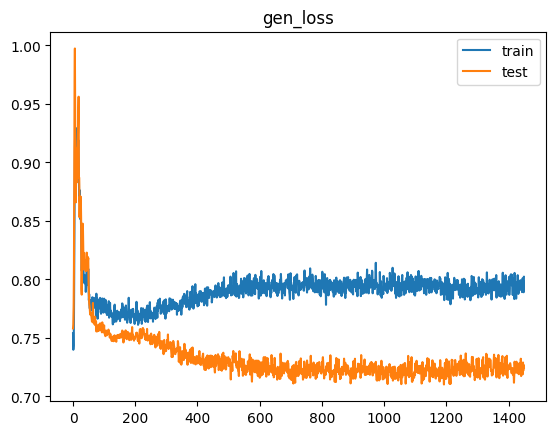

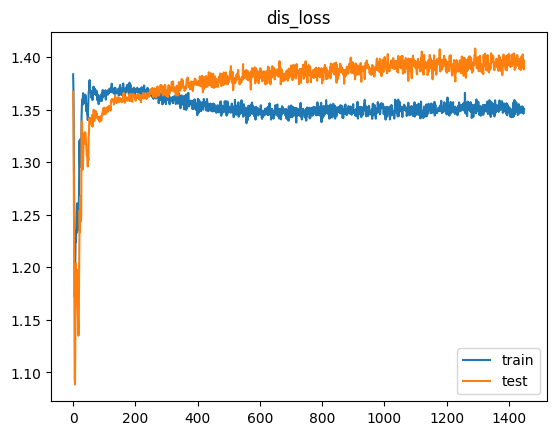

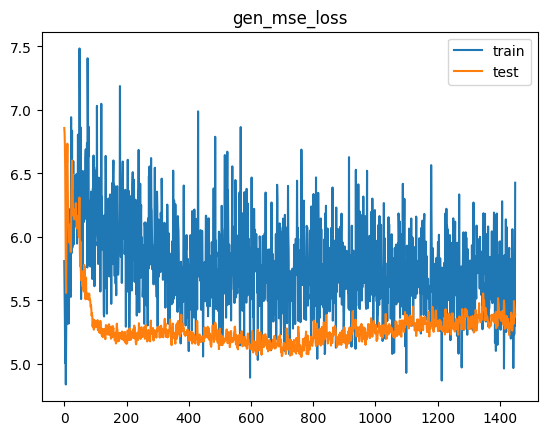

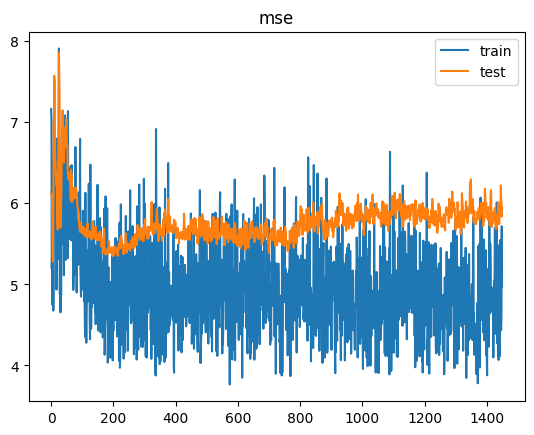

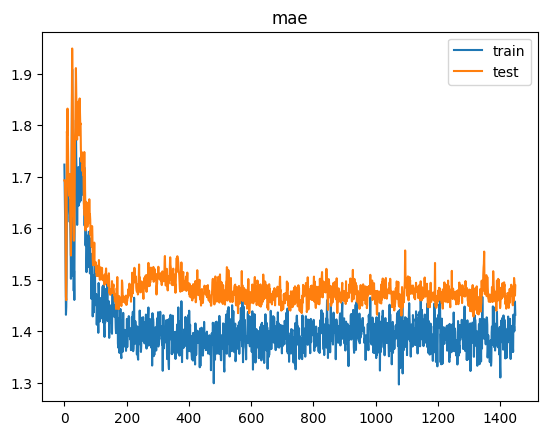

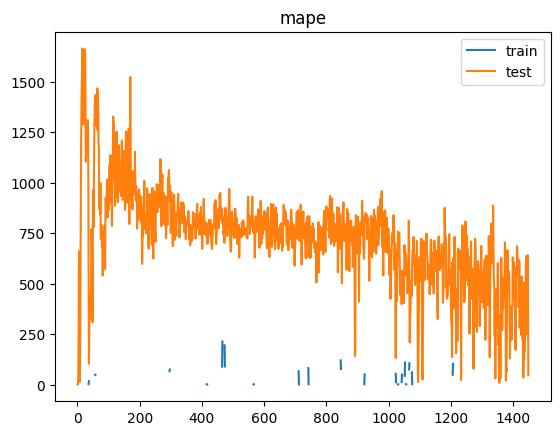

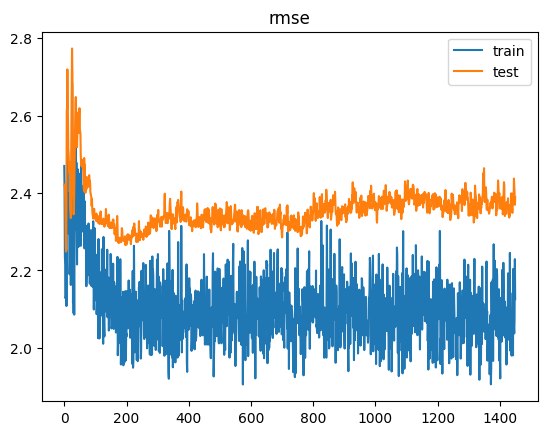

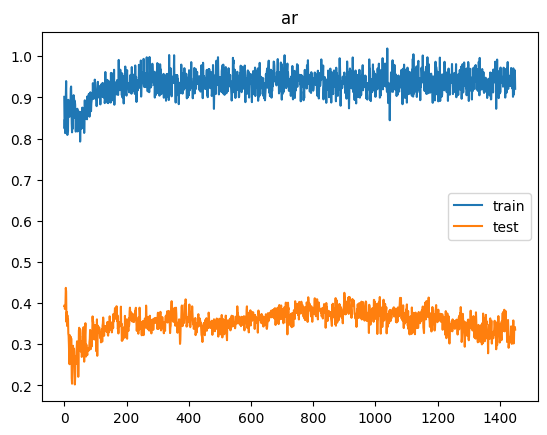

2/2 [==============================] - 1s 4ms/step


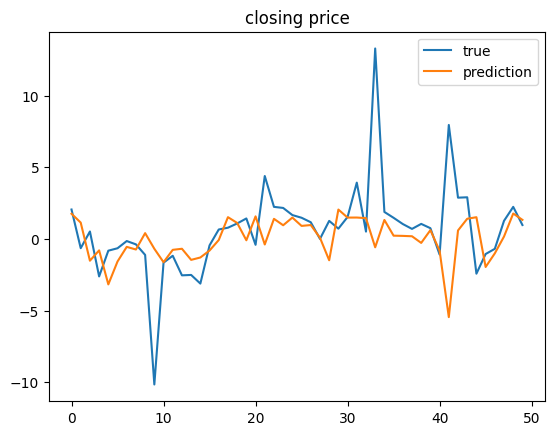

[MSE Baseline] train: 5.0302528462758325  test: 4.988566607603537
Delta time with epochs = 1450: 0:23:39.547793
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 20)             0         
             

Time for epoch 51 is 0.9179444313049316 sec Generator Loss: 0.7977701425552368,  Discriminator_loss: 1.349853754043579
Time for epoch 52 is 0.9369704723358154 sec Generator Loss: 0.808110773563385,  Discriminator_loss: 1.352583885192871
Time for epoch 53 is 0.9209718704223633 sec Generator Loss: 0.7974426746368408,  Discriminator_loss: 1.3546828031539917
Time for epoch 54 is 0.9300065040588379 sec Generator Loss: 0.7933827638626099,  Discriminator_loss: 1.3562488555908203
Time for epoch 55 is 0.9522554874420166 sec Generator Loss: 0.8040849566459656,  Discriminator_loss: 1.3571304082870483
Time for epoch 56 is 0.9238438606262207 sec Generator Loss: 0.7946502566337585,  Discriminator_loss: 1.3611862659454346
Time for epoch 57 is 0.9103536605834961 sec Generator Loss: 0.7960458397865295,  Discriminator_loss: 1.3588452339172363
Time for epoch 58 is 0.9303879737854004 sec Generator Loss: 0.7899958491325378,  Discriminator_loss: 1.363816261291504
Time for epoch 59 is 0.9474213123321533 sec 

Time for epoch 120 is 0.920060396194458 sec Generator Loss: 0.7797145843505859,  Discriminator_loss: 1.3586153984069824
Time for epoch 121 is 0.9385435581207275 sec Generator Loss: 0.7864368557929993,  Discriminator_loss: 1.3578320741653442
Time for epoch 122 is 0.9607863426208496 sec Generator Loss: 0.7832772731781006,  Discriminator_loss: 1.361593246459961
Time for epoch 123 is 0.9836118221282959 sec Generator Loss: 0.7872705459594727,  Discriminator_loss: 1.3599622249603271
Time for epoch 124 is 0.9265556335449219 sec Generator Loss: 0.7907695770263672,  Discriminator_loss: 1.3580528497695923
Time for epoch 125 is 0.9151859283447266 sec Generator Loss: 0.7814318537712097,  Discriminator_loss: 1.3641945123672485
Time for epoch 126 is 0.9099075794219971 sec Generator Loss: 0.7762437462806702,  Discriminator_loss: 1.3613325357437134
Time for epoch 127 is 0.9280247688293457 sec Generator Loss: 0.7806987762451172,  Discriminator_loss: 1.3591701984405518
Time for epoch 128 is 0.9537959098

Time for epoch 189 is 0.9230027198791504 sec Generator Loss: 0.7759459614753723,  Discriminator_loss: 1.362805724143982
Time for epoch 190 is 0.9239687919616699 sec Generator Loss: 0.777684211730957,  Discriminator_loss: 1.3580888509750366
Time for epoch 191 is 0.9476883411407471 sec Generator Loss: 0.78061443567276,  Discriminator_loss: 1.3574105501174927
Time for epoch 192 is 0.944983720779419 sec Generator Loss: 0.781728208065033,  Discriminator_loss: 1.3597710132598877
Time for epoch 193 is 0.9472208023071289 sec Generator Loss: 0.7900757193565369,  Discriminator_loss: 1.3587337732315063
Time for epoch 194 is 0.9486947059631348 sec Generator Loss: 0.7888480424880981,  Discriminator_loss: 1.3581706285476685
Time for epoch 195 is 0.9370265007019043 sec Generator Loss: 0.7747766971588135,  Discriminator_loss: 1.3647217750549316
Time for epoch 196 is 0.9647786617279053 sec Generator Loss: 0.7833492159843445,  Discriminator_loss: 1.3618290424346924
Time for epoch 197 is 0.95576214790344

Time for epoch 258 is 0.9592959880828857 sec Generator Loss: 0.7881578207015991,  Discriminator_loss: 1.3500194549560547
Time for epoch 259 is 0.9680235385894775 sec Generator Loss: 0.7866764664649963,  Discriminator_loss: 1.3547803163528442
Time for epoch 260 is 0.9582281112670898 sec Generator Loss: 0.7791386842727661,  Discriminator_loss: 1.3606988191604614
Time for epoch 261 is 0.9273586273193359 sec Generator Loss: 0.7758687734603882,  Discriminator_loss: 1.3617998361587524
Time for epoch 262 is 0.9469058513641357 sec Generator Loss: 0.774657130241394,  Discriminator_loss: 1.3649576902389526
Time for epoch 263 is 0.981903076171875 sec Generator Loss: 0.775401771068573,  Discriminator_loss: 1.3615590333938599
Time for epoch 264 is 0.9692792892456055 sec Generator Loss: 0.7805877327919006,  Discriminator_loss: 1.3602361679077148
Time for epoch 265 is 1.0173084735870361 sec Generator Loss: 0.782106876373291,  Discriminator_loss: 1.3574447631835938
Time for epoch 266 is 0.976752042770

Time for epoch 326 is 1.017934799194336 sec Generator Loss: 0.7886717319488525,  Discriminator_loss: 1.3516268730163574
Time for epoch 327 is 1.006788730621338 sec Generator Loss: 0.7887815237045288,  Discriminator_loss: 1.3556586503982544
Time for epoch 328 is 1.0212230682373047 sec Generator Loss: 0.7844873070716858,  Discriminator_loss: 1.3528635501861572
Time for epoch 329 is 1.0108561515808105 sec Generator Loss: 0.7916598320007324,  Discriminator_loss: 1.3493893146514893
Time for epoch 330 is 1.0141887664794922 sec Generator Loss: 0.7789258360862732,  Discriminator_loss: 1.3627405166625977
Time for epoch 331 is 1.0126352310180664 sec Generator Loss: 0.7809725999832153,  Discriminator_loss: 1.3566582202911377
Time for epoch 332 is 1.0234827995300293 sec Generator Loss: 0.7868173718452454,  Discriminator_loss: 1.3543641567230225
Time for epoch 333 is 1.013075351715088 sec Generator Loss: 0.7860645651817322,  Discriminator_loss: 1.355221152305603
Time for epoch 334 is 1.011916637420

Time for epoch 395 is 1.002932071685791 sec Generator Loss: 0.785369336605072,  Discriminator_loss: 1.3508645296096802
Time for epoch 396 is 1.014545202255249 sec Generator Loss: 0.7895238399505615,  Discriminator_loss: 1.3521652221679688
Time for epoch 397 is 1.0018064975738525 sec Generator Loss: 0.7969774007797241,  Discriminator_loss: 1.3449300527572632
Time for epoch 398 is 1.0033576488494873 sec Generator Loss: 0.7879540324211121,  Discriminator_loss: 1.3516085147857666
Time for epoch 399 is 1.0045511722564697 sec Generator Loss: 0.790605902671814,  Discriminator_loss: 1.3498185873031616
Time for epoch 400 is 1.005620002746582 sec Generator Loss: 0.7918843030929565,  Discriminator_loss: 1.3519587516784668
Time for epoch 401 is 0.9835505485534668 sec Generator Loss: 0.7927979230880737,  Discriminator_loss: 1.3503711223602295
Time for epoch 402 is 1.0022010803222656 sec Generator Loss: 0.791262149810791,  Discriminator_loss: 1.3521941900253296
Time for epoch 403 is 0.98395180702209

Time for epoch 464 is 0.9912724494934082 sec Generator Loss: 0.7899751663208008,  Discriminator_loss: 1.3534190654754639
Time for epoch 465 is 0.9952261447906494 sec Generator Loss: 0.7936844229698181,  Discriminator_loss: 1.3551788330078125
Time for epoch 466 is 1.0041241645812988 sec Generator Loss: 0.7862482666969299,  Discriminator_loss: 1.3487098217010498
Time for epoch 467 is 1.070852279663086 sec Generator Loss: 0.8000251054763794,  Discriminator_loss: 1.3437330722808838
Time for epoch 468 is 1.068326711654663 sec Generator Loss: 0.7935624122619629,  Discriminator_loss: 1.342464804649353
Time for epoch 469 is 0.9910461902618408 sec Generator Loss: 0.7907246947288513,  Discriminator_loss: 1.3486703634262085
Time for epoch 470 is 0.9991412162780762 sec Generator Loss: 0.7883235812187195,  Discriminator_loss: 1.3464953899383545
Time for epoch 471 is 0.934922456741333 sec Generator Loss: 0.8016192317008972,  Discriminator_loss: 1.3497095108032227
Time for epoch 472 is 0.968226432800

Time for epoch 532 is 0.9846415519714355 sec Generator Loss: 0.7927046418190002,  Discriminator_loss: 1.342186450958252
Time for epoch 533 is 0.9930636882781982 sec Generator Loss: 0.7982550859451294,  Discriminator_loss: 1.3494417667388916
Time for epoch 534 is 0.9959568977355957 sec Generator Loss: 0.7921510338783264,  Discriminator_loss: 1.349088191986084
Time for epoch 535 is 0.9815607070922852 sec Generator Loss: 0.79805588722229,  Discriminator_loss: 1.343166470527649
Time for epoch 536 is 0.9568896293640137 sec Generator Loss: 0.8000085949897766,  Discriminator_loss: 1.3447792530059814
Time for epoch 537 is 0.9400711059570312 sec Generator Loss: 0.7963922619819641,  Discriminator_loss: 1.3486987352371216
Time for epoch 538 is 0.935452938079834 sec Generator Loss: 0.7940720319747925,  Discriminator_loss: 1.3470509052276611
Time for epoch 539 is 0.9524252414703369 sec Generator Loss: 0.8046569228172302,  Discriminator_loss: 1.3427516222000122
Time for epoch 540 is 0.94877719879150

Time for epoch 601 is 0.9296450614929199 sec Generator Loss: 0.7899539470672607,  Discriminator_loss: 1.3534051179885864
Time for epoch 602 is 0.9302241802215576 sec Generator Loss: 0.7957453727722168,  Discriminator_loss: 1.3419986963272095
Time for epoch 603 is 0.9441397190093994 sec Generator Loss: 0.784728467464447,  Discriminator_loss: 1.358938217163086
Time for epoch 604 is 0.9667282104492188 sec Generator Loss: 0.79509037733078,  Discriminator_loss: 1.352156162261963
Time for epoch 605 is 0.9441244602203369 sec Generator Loss: 0.7951458692550659,  Discriminator_loss: 1.352569341659546
Time for epoch 606 is 0.9538674354553223 sec Generator Loss: 0.7979440689086914,  Discriminator_loss: 1.3479465246200562
Time for epoch 607 is 0.9365875720977783 sec Generator Loss: 0.791070818901062,  Discriminator_loss: 1.3485031127929688
Time for epoch 608 is 0.9456040859222412 sec Generator Loss: 0.793184220790863,  Discriminator_loss: 1.3472198247909546
Time for epoch 609 is 0.9593887329101562

Time for epoch 670 is 0.9510946273803711 sec Generator Loss: 0.8041102886199951,  Discriminator_loss: 1.349934458732605
Time for epoch 671 is 0.9588143825531006 sec Generator Loss: 0.7924293875694275,  Discriminator_loss: 1.3547204732894897
Time for epoch 672 is 0.9484922885894775 sec Generator Loss: 0.7894067764282227,  Discriminator_loss: 1.3491175174713135
Time for epoch 673 is 0.9719817638397217 sec Generator Loss: 0.7932759523391724,  Discriminator_loss: 1.3533477783203125
Time for epoch 674 is 0.9369082450866699 sec Generator Loss: 0.791404128074646,  Discriminator_loss: 1.351271390914917
Time for epoch 675 is 0.9482898712158203 sec Generator Loss: 0.8046004772186279,  Discriminator_loss: 1.339867115020752
Time for epoch 676 is 0.9802908897399902 sec Generator Loss: 0.7926936149597168,  Discriminator_loss: 1.3483057022094727
Time for epoch 677 is 0.9745757579803467 sec Generator Loss: 0.7963593602180481,  Discriminator_loss: 1.3496761322021484
Time for epoch 678 is 0.963198661804

In [ ]:
for epochs in [1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 20)            1440      
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 5, 20)            80        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 20)             0         
                                                                 
 dropout (Dropout)           (None, 5, 20)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480  

Time for epoch 52 is 0.7864692211151123 sec Generator Loss: 0.7850416302680969,  Discriminator_loss: 1.3583898544311523
Time for epoch 53 is 0.7826535701751709 sec Generator Loss: 0.7853289246559143,  Discriminator_loss: 1.3616094589233398
Time for epoch 54 is 0.7875761985778809 sec Generator Loss: 0.7882657647132874,  Discriminator_loss: 1.3584251403808594
Time for epoch 55 is 0.7947454452514648 sec Generator Loss: 0.7869570255279541,  Discriminator_loss: 1.352552890777588
Time for epoch 56 is 0.788121223449707 sec Generator Loss: 0.7871580719947815,  Discriminator_loss: 1.3559190034866333
Time for epoch 57 is 0.7892382144927979 sec Generator Loss: 0.7906022667884827,  Discriminator_loss: 1.3529947996139526
Time for epoch 58 is 0.788815975189209 sec Generator Loss: 0.7925193905830383,  Discriminator_loss: 1.3562815189361572
Time for epoch 59 is 0.8120956420898438 sec Generator Loss: 0.7935806512832642,  Discriminator_loss: 1.3505961894989014
Time for epoch 60 is 0.7935280799865723 sec

Time for epoch 121 is 0.9787662029266357 sec Generator Loss: 0.7725033760070801,  Discriminator_loss: 1.3669497966766357
Time for epoch 122 is 0.9213583469390869 sec Generator Loss: 0.7755182981491089,  Discriminator_loss: 1.3687160015106201
Time for epoch 123 is 0.8591413497924805 sec Generator Loss: 0.7727725505828857,  Discriminator_loss: 1.3664430379867554
Time for epoch 124 is 0.8748776912689209 sec Generator Loss: 0.774560809135437,  Discriminator_loss: 1.3642927408218384
Time for epoch 125 is 0.8646218776702881 sec Generator Loss: 0.7692974209785461,  Discriminator_loss: 1.3689968585968018
Time for epoch 126 is 0.8662264347076416 sec Generator Loss: 0.7694034576416016,  Discriminator_loss: 1.3643995523452759
Time for epoch 127 is 0.8722329139709473 sec Generator Loss: 0.7762235999107361,  Discriminator_loss: 1.3652154207229614
Time for epoch 128 is 0.8867137432098389 sec Generator Loss: 0.767372727394104,  Discriminator_loss: 1.3696728944778442
Time for epoch 129 is 0.8801441192

Time for epoch 190 is 0.9050588607788086 sec Generator Loss: 0.781899094581604,  Discriminator_loss: 1.3621476888656616
Time for epoch 191 is 0.9373698234558105 sec Generator Loss: 0.773891031742096,  Discriminator_loss: 1.3630752563476562
Time for epoch 192 is 0.9761712551116943 sec Generator Loss: 0.7821313142776489,  Discriminator_loss: 1.3624861240386963
Time for epoch 193 is 0.9972281455993652 sec Generator Loss: 0.7847904562950134,  Discriminator_loss: 1.36359703540802
Time for epoch 194 is 0.9154555797576904 sec Generator Loss: 0.7729918956756592,  Discriminator_loss: 1.3657327890396118
Time for epoch 195 is 1.0132367610931396 sec Generator Loss: 0.7779623866081238,  Discriminator_loss: 1.3566416501998901
Time for epoch 196 is 0.9876186847686768 sec Generator Loss: 0.7742974758148193,  Discriminator_loss: 1.3596720695495605
Time for epoch 197 is 0.8982911109924316 sec Generator Loss: 0.7798890471458435,  Discriminator_loss: 1.3639886379241943
Time for epoch 198 is 0.908869028091

Time for epoch 258 is 1.0889313220977783 sec Generator Loss: 0.7837012410163879,  Discriminator_loss: 1.3537524938583374
Time for epoch 259 is 1.1389923095703125 sec Generator Loss: 0.7819190621376038,  Discriminator_loss: 1.3544890880584717
Time for epoch 260 is 1.0798606872558594 sec Generator Loss: 0.7814463376998901,  Discriminator_loss: 1.3568984270095825
Time for epoch 261 is 0.9398677349090576 sec Generator Loss: 0.7909655570983887,  Discriminator_loss: 1.353062391281128
Time for epoch 262 is 0.9575216770172119 sec Generator Loss: 0.7855225801467896,  Discriminator_loss: 1.358506679534912
Time for epoch 263 is 0.9700746536254883 sec Generator Loss: 0.7920224070549011,  Discriminator_loss: 1.3533101081848145
Time for epoch 264 is 0.9103612899780273 sec Generator Loss: 0.783833920955658,  Discriminator_loss: 1.3566468954086304
Time for epoch 265 is 0.9073731899261475 sec Generator Loss: 0.7868857383728027,  Discriminator_loss: 1.3556300401687622
Time for epoch 266 is 0.96796369552

Time for epoch 327 is 0.8617160320281982 sec Generator Loss: 0.781445324420929,  Discriminator_loss: 1.3572648763656616
Time for epoch 328 is 0.8556818962097168 sec Generator Loss: 0.7862356901168823,  Discriminator_loss: 1.3552918434143066
Time for epoch 329 is 0.8544914722442627 sec Generator Loss: 0.7867909073829651,  Discriminator_loss: 1.351764440536499
Time for epoch 330 is 0.8529274463653564 sec Generator Loss: 0.7901089787483215,  Discriminator_loss: 1.3573673963546753
Time for epoch 331 is 0.8583269119262695 sec Generator Loss: 0.7867885828018188,  Discriminator_loss: 1.3560740947723389
Time for epoch 332 is 0.8821914196014404 sec Generator Loss: 0.7838624715805054,  Discriminator_loss: 1.3597980737686157
Time for epoch 333 is 0.8509395122528076 sec Generator Loss: 0.7845597863197327,  Discriminator_loss: 1.355884313583374
Time for epoch 334 is 0.861250638961792 sec Generator Loss: 0.7866085171699524,  Discriminator_loss: 1.3551979064941406
Time for epoch 335 is 0.858477354049

Time for epoch 396 is 0.8919367790222168 sec Generator Loss: 0.7920506596565247,  Discriminator_loss: 1.3472404479980469
Time for epoch 397 is 0.8939752578735352 sec Generator Loss: 0.7944065928459167,  Discriminator_loss: 1.346493124961853
Time for epoch 398 is 0.9012165069580078 sec Generator Loss: 0.7868555784225464,  Discriminator_loss: 1.351535439491272
Time for epoch 399 is 0.9058198928833008 sec Generator Loss: 0.7911708354949951,  Discriminator_loss: 1.3483567237854004
Time for epoch 400 is 0.8599703311920166 sec Generator Loss: 0.7937760949134827,  Discriminator_loss: 1.345028042793274
Time for epoch 401 is 0.8518829345703125 sec Generator Loss: 0.7874846458435059,  Discriminator_loss: 1.3496372699737549
Time for epoch 402 is 0.8685402870178223 sec Generator Loss: 0.7945982813835144,  Discriminator_loss: 1.3444902896881104
Time for epoch 403 is 0.8542900085449219 sec Generator Loss: 0.7909548282623291,  Discriminator_loss: 1.349092960357666
Time for epoch 404 is 0.849312067031

Time for epoch 464 is 0.9880633354187012 sec Generator Loss: 0.7932510375976562,  Discriminator_loss: 1.3473001718521118
Time for epoch 465 is 0.8757259845733643 sec Generator Loss: 0.7922970652580261,  Discriminator_loss: 1.35252845287323
Time for epoch 466 is 0.9389092922210693 sec Generator Loss: 0.7971042394638062,  Discriminator_loss: 1.3434443473815918
Time for epoch 467 is 0.9273617267608643 sec Generator Loss: 0.7946727275848389,  Discriminator_loss: 1.350813865661621
Time for epoch 468 is 0.9118545055389404 sec Generator Loss: 0.7985759377479553,  Discriminator_loss: 1.3397884368896484
Time for epoch 469 is 0.9224169254302979 sec Generator Loss: 0.7932565808296204,  Discriminator_loss: 1.3477332592010498
Time for epoch 470 is 0.8742578029632568 sec Generator Loss: 0.7938339114189148,  Discriminator_loss: 1.3478577136993408
Time for epoch 471 is 0.8663084506988525 sec Generator Loss: 0.7949955463409424,  Discriminator_loss: 1.3414472341537476
Time for epoch 472 is 0.87007522583

Time for epoch 532 is 0.8736164569854736 sec Generator Loss: 0.8019236922264099,  Discriminator_loss: 1.346046805381775
Time for epoch 533 is 0.8648653030395508 sec Generator Loss: 0.795228123664856,  Discriminator_loss: 1.3472565412521362
Time for epoch 534 is 0.8900833129882812 sec Generator Loss: 0.7949298024177551,  Discriminator_loss: 1.3490313291549683
Time for epoch 535 is 0.8699891567230225 sec Generator Loss: 0.8017101287841797,  Discriminator_loss: 1.3447867631912231
Time for epoch 536 is 0.8658478260040283 sec Generator Loss: 0.8032352328300476,  Discriminator_loss: 1.3433619737625122
Time for epoch 537 is 0.8618650436401367 sec Generator Loss: 0.8025814890861511,  Discriminator_loss: 1.3477191925048828
Time for epoch 538 is 0.8597147464752197 sec Generator Loss: 0.8030659556388855,  Discriminator_loss: 1.3392953872680664
Time for epoch 539 is 1.0229485034942627 sec Generator Loss: 0.802350640296936,  Discriminator_loss: 1.3402082920074463
Time for epoch 540 is 0.95968532562

Time for epoch 601 is 0.8738563060760498 sec Generator Loss: 0.7995824217796326,  Discriminator_loss: 1.340396761894226
Time for epoch 602 is 0.8915650844573975 sec Generator Loss: 0.7997664213180542,  Discriminator_loss: 1.3426073789596558
Time for epoch 603 is 0.8777093887329102 sec Generator Loss: 0.8034507036209106,  Discriminator_loss: 1.3495426177978516
Time for epoch 604 is 0.8765389919281006 sec Generator Loss: 0.7984505295753479,  Discriminator_loss: 1.342907190322876
Time for epoch 605 is 0.8779439926147461 sec Generator Loss: 0.8053497672080994,  Discriminator_loss: 1.3418068885803223
Time for epoch 606 is 0.9114024639129639 sec Generator Loss: 0.8037566542625427,  Discriminator_loss: 1.3470635414123535
Time for epoch 607 is 0.9230701923370361 sec Generator Loss: 0.8053374290466309,  Discriminator_loss: 1.3420621156692505
Time for epoch 608 is 0.9461896419525146 sec Generator Loss: 0.7986398339271545,  Discriminator_loss: 1.3473763465881348
Time for epoch 609 is 0.8791131973

Time for epoch 669 is 0.8682115077972412 sec Generator Loss: 0.8021719455718994,  Discriminator_loss: 1.3444722890853882
Time for epoch 670 is 0.8622148036956787 sec Generator Loss: 0.8021270036697388,  Discriminator_loss: 1.3409020900726318
Time for epoch 671 is 0.8592112064361572 sec Generator Loss: 0.8011319637298584,  Discriminator_loss: 1.347456455230713
Time for epoch 672 is 0.8603878021240234 sec Generator Loss: 0.7962770462036133,  Discriminator_loss: 1.3415374755859375
Time for epoch 673 is 0.8862581253051758 sec Generator Loss: 0.8039880990982056,  Discriminator_loss: 1.342872977256775
Time for epoch 674 is 0.936342716217041 sec Generator Loss: 0.7993959784507751,  Discriminator_loss: 1.3515288829803467
Time for epoch 675 is 0.9435508251190186 sec Generator Loss: 0.8043836951255798,  Discriminator_loss: 1.3449203968048096
Time for epoch 676 is 0.8922650814056396 sec Generator Loss: 0.810830295085907,  Discriminator_loss: 1.3377044200897217
Time for epoch 677 is 0.882838249206

Time for epoch 738 is 0.8755228519439697 sec Generator Loss: 0.8097742199897766,  Discriminator_loss: 1.3422595262527466
Time for epoch 739 is 0.8873698711395264 sec Generator Loss: 0.796314001083374,  Discriminator_loss: 1.3518372774124146
Time for epoch 740 is 0.868863582611084 sec Generator Loss: 0.7901500463485718,  Discriminator_loss: 1.346165657043457
Time for epoch 741 is 0.8849599361419678 sec Generator Loss: 0.8075342178344727,  Discriminator_loss: 1.3442801237106323
Time for epoch 742 is 0.9084389209747314 sec Generator Loss: 0.7874755263328552,  Discriminator_loss: 1.3459705114364624
Time for epoch 743 is 0.9114394187927246 sec Generator Loss: 0.7973994016647339,  Discriminator_loss: 1.3435609340667725
Time for epoch 744 is 0.865598201751709 sec Generator Loss: 0.7986929416656494,  Discriminator_loss: 1.3463813066482544
Time for epoch 745 is 0.8635044097900391 sec Generator Loss: 0.8008459210395813,  Discriminator_loss: 1.3490763902664185
Time for epoch 746 is 0.863800287246

Time for epoch 806 is 0.8582403659820557 sec Generator Loss: 0.7978915572166443,  Discriminator_loss: 1.3495912551879883
Time for epoch 807 is 0.8670551776885986 sec Generator Loss: 0.7940661311149597,  Discriminator_loss: 1.3551777601242065
Time for epoch 808 is 0.8859617710113525 sec Generator Loss: 0.7947511076927185,  Discriminator_loss: 1.3544212579727173
Time for epoch 809 is 0.9387407302856445 sec Generator Loss: 0.7964838147163391,  Discriminator_loss: 1.35001540184021
Time for epoch 810 is 0.8805019855499268 sec Generator Loss: 0.7933699488639832,  Discriminator_loss: 1.3492889404296875
Time for epoch 811 is 0.8652377128601074 sec Generator Loss: 0.8057171106338501,  Discriminator_loss: 1.342937707901001
Time for epoch 812 is 0.9114022254943848 sec Generator Loss: 0.7981710433959961,  Discriminator_loss: 1.3480167388916016
Time for epoch 813 is 0.8784728050231934 sec Generator Loss: 0.7943724989891052,  Discriminator_loss: 1.3479942083358765
Time for epoch 814 is 0.89837050437

Time for epoch 875 is 0.9731404781341553 sec Generator Loss: 0.8085032105445862,  Discriminator_loss: 1.3517218828201294
Time for epoch 876 is 0.9426310062408447 sec Generator Loss: 0.8016786575317383,  Discriminator_loss: 1.3499857187271118
Time for epoch 877 is 0.8844807147979736 sec Generator Loss: 0.8055996894836426,  Discriminator_loss: 1.3396341800689697
Time for epoch 878 is 0.8792343139648438 sec Generator Loss: 0.8067070841789246,  Discriminator_loss: 1.3451449871063232
Time for epoch 879 is 0.8792243003845215 sec Generator Loss: 0.7980384826660156,  Discriminator_loss: 1.343246579170227
Time for epoch 880 is 0.8809070587158203 sec Generator Loss: 0.7982709407806396,  Discriminator_loss: 1.3535696268081665
Time for epoch 881 is 0.8819515705108643 sec Generator Loss: 0.7966533899307251,  Discriminator_loss: 1.3466960191726685
Time for epoch 882 is 0.891646146774292 sec Generator Loss: 0.7981820106506348,  Discriminator_loss: 1.345669150352478
Time for epoch 883 is 0.87739038467

Time for epoch 943 is 0.882800817489624 sec Generator Loss: 0.8014680743217468,  Discriminator_loss: 1.3505088090896606
Time for epoch 944 is 0.8869078159332275 sec Generator Loss: 0.799683153629303,  Discriminator_loss: 1.3478810787200928
Time for epoch 945 is 0.9206366539001465 sec Generator Loss: 0.7972036004066467,  Discriminator_loss: 1.3465042114257812
Time for epoch 946 is 0.8820793628692627 sec Generator Loss: 0.7988095283508301,  Discriminator_loss: 1.3535386323928833
Time for epoch 947 is 0.9271042346954346 sec Generator Loss: 0.8045579195022583,  Discriminator_loss: 1.3444769382476807
Time for epoch 948 is 0.898857593536377 sec Generator Loss: 0.7922182679176331,  Discriminator_loss: 1.3534284830093384
Time for epoch 949 is 0.9212970733642578 sec Generator Loss: 0.798017680644989,  Discriminator_loss: 1.3488261699676514
Time for epoch 950 is 0.9025352001190186 sec Generator Loss: 0.8033395409584045,  Discriminator_loss: 1.3496779203414917
Time for epoch 951 is 0.893083333969

Time for epoch 1011 is 0.8706417083740234 sec Generator Loss: 0.7970684766769409,  Discriminator_loss: 1.3473025560379028
Time for epoch 1012 is 0.883171558380127 sec Generator Loss: 0.8004112839698792,  Discriminator_loss: 1.3433674573898315
Time for epoch 1013 is 0.87349534034729 sec Generator Loss: 0.7992610335350037,  Discriminator_loss: 1.3427704572677612
Time for epoch 1014 is 0.8730192184448242 sec Generator Loss: 0.7930643558502197,  Discriminator_loss: 1.3492742776870728
Time for epoch 1015 is 0.8688204288482666 sec Generator Loss: 0.7939698100090027,  Discriminator_loss: 1.3453165292739868
Time for epoch 1016 is 0.879563570022583 sec Generator Loss: 0.7981109619140625,  Discriminator_loss: 1.350426435470581
Time for epoch 1017 is 0.8774471282958984 sec Generator Loss: 0.8018206357955933,  Discriminator_loss: 1.3416799306869507
Time for epoch 1018 is 0.8739869594573975 sec Generator Loss: 0.7938897609710693,  Discriminator_loss: 1.3430012464523315
Time for epoch 1019 is 0.8742

Time for epoch 1079 is 0.8883781433105469 sec Generator Loss: 0.8014318346977234,  Discriminator_loss: 1.3529719114303589
Time for epoch 1080 is 1.0556163787841797 sec Generator Loss: 0.8098579049110413,  Discriminator_loss: 1.345584511756897
Time for epoch 1081 is 0.9358456134796143 sec Generator Loss: 0.7986388802528381,  Discriminator_loss: 1.345028281211853
Time for epoch 1082 is 0.8955998420715332 sec Generator Loss: 0.7955688238143921,  Discriminator_loss: 1.3475579023361206
Time for epoch 1083 is 0.9561891555786133 sec Generator Loss: 0.8005474209785461,  Discriminator_loss: 1.346076250076294
Time for epoch 1084 is 0.9318859577178955 sec Generator Loss: 0.8099601864814758,  Discriminator_loss: 1.3413887023925781
Time for epoch 1085 is 0.9258546829223633 sec Generator Loss: 0.7960695028305054,  Discriminator_loss: 1.345760703086853
Time for epoch 1086 is 0.923893928527832 sec Generator Loss: 0.7940815687179565,  Discriminator_loss: 1.3449658155441284
Time for epoch 1087 is 0.8969

Time for epoch 1147 is 0.9682931900024414 sec Generator Loss: 0.8010271787643433,  Discriminator_loss: 1.3452144861221313
Time for epoch 1148 is 0.9661829471588135 sec Generator Loss: 0.8111699223518372,  Discriminator_loss: 1.3448114395141602
Time for epoch 1149 is 0.9708032608032227 sec Generator Loss: 0.8040071129798889,  Discriminator_loss: 1.3518965244293213
Time for epoch 1150 is 0.96895432472229 sec Generator Loss: 0.8049264550209045,  Discriminator_loss: 1.3409677743911743
Time for epoch 1151 is 0.9854316711425781 sec Generator Loss: 0.7957685589790344,  Discriminator_loss: 1.349315881729126
Time for epoch 1152 is 0.9822561740875244 sec Generator Loss: 0.7965596318244934,  Discriminator_loss: 1.346529483795166
Time for epoch 1153 is 0.9579641819000244 sec Generator Loss: 0.7995346784591675,  Discriminator_loss: 1.3446588516235352
Time for epoch 1154 is 0.9677009582519531 sec Generator Loss: 0.8041774034500122,  Discriminator_loss: 1.3478466272354126
Time for epoch 1155 is 0.976

Time for epoch 1215 is 1.1084845066070557 sec Generator Loss: 0.8061903715133667,  Discriminator_loss: 1.3367085456848145
Time for epoch 1216 is 1.1146135330200195 sec Generator Loss: 0.7975018620491028,  Discriminator_loss: 1.3485490083694458
Time for epoch 1217 is 1.1016285419464111 sec Generator Loss: 0.7959283590316772,  Discriminator_loss: 1.3465139865875244
Time for epoch 1218 is 1.0789518356323242 sec Generator Loss: 0.8079829216003418,  Discriminator_loss: 1.3469265699386597
Time for epoch 1219 is 1.099890947341919 sec Generator Loss: 0.8066229820251465,  Discriminator_loss: 1.3494055271148682
Time for epoch 1220 is 1.0597991943359375 sec Generator Loss: 0.7963309288024902,  Discriminator_loss: 1.3484199047088623
Time for epoch 1221 is 1.0024137496948242 sec Generator Loss: 0.8055970668792725,  Discriminator_loss: 1.353135108947754
Time for epoch 1222 is 0.9862196445465088 sec Generator Loss: 0.8010983467102051,  Discriminator_loss: 1.3485385179519653
Time for epoch 1223 is 0.9

Time for epoch 1283 is 1.0066452026367188 sec Generator Loss: 0.7941035628318787,  Discriminator_loss: 1.350960373878479
Time for epoch 1284 is 0.974966287612915 sec Generator Loss: 0.7987182140350342,  Discriminator_loss: 1.344459056854248
Time for epoch 1285 is 0.9748132228851318 sec Generator Loss: 0.7973157167434692,  Discriminator_loss: 1.3440499305725098
Time for epoch 1286 is 0.9752109050750732 sec Generator Loss: 0.7947216629981995,  Discriminator_loss: 1.3475898504257202
Time for epoch 1287 is 0.9518594741821289 sec Generator Loss: 0.7962327599525452,  Discriminator_loss: 1.3506109714508057
Time for epoch 1288 is 0.9715404510498047 sec Generator Loss: 0.8083585500717163,  Discriminator_loss: 1.346100926399231
Time for epoch 1289 is 0.9686672687530518 sec Generator Loss: 0.8097244501113892,  Discriminator_loss: 1.3443011045455933
Time for epoch 1290 is 0.9632067680358887 sec Generator Loss: 0.8001980185508728,  Discriminator_loss: 1.3464856147766113
Time for epoch 1291 is 0.974

Time for epoch 1351 is 0.9518673419952393 sec Generator Loss: 0.7934905290603638,  Discriminator_loss: 1.3517563343048096
Time for epoch 1352 is 0.9763650894165039 sec Generator Loss: 0.7989965081214905,  Discriminator_loss: 1.3444421291351318
Time for epoch 1353 is 0.9293761253356934 sec Generator Loss: 0.7956603169441223,  Discriminator_loss: 1.3502569198608398
Time for epoch 1354 is 0.9536023139953613 sec Generator Loss: 0.7981998324394226,  Discriminator_loss: 1.3464279174804688
Time for epoch 1355 is 0.9271349906921387 sec Generator Loss: 0.7949970364570618,  Discriminator_loss: 1.3501375913619995
Time for epoch 1356 is 0.9333062171936035 sec Generator Loss: 0.8003591895103455,  Discriminator_loss: 1.3468397855758667
Time for epoch 1357 is 0.9512667655944824 sec Generator Loss: 0.7963500022888184,  Discriminator_loss: 1.352417230606079
Time for epoch 1358 is 0.9220397472381592 sec Generator Loss: 0.8094062209129333,  Discriminator_loss: 1.3392521142959595
Time for epoch 1359 is 0.

Time for epoch 1419 is 0.9305963516235352 sec Generator Loss: 0.8025532960891724,  Discriminator_loss: 1.3423374891281128
Time for epoch 1420 is 0.9523131847381592 sec Generator Loss: 0.8045666813850403,  Discriminator_loss: 1.3424437046051025
Time for epoch 1421 is 0.9528326988220215 sec Generator Loss: 0.7904561161994934,  Discriminator_loss: 1.3504133224487305
Time for epoch 1422 is 1.015155553817749 sec Generator Loss: 0.7943464517593384,  Discriminator_loss: 1.3534364700317383
Time for epoch 1423 is 1.1277797222137451 sec Generator Loss: 0.7943715453147888,  Discriminator_loss: 1.3526115417480469
Time for epoch 1424 is 1.1226024627685547 sec Generator Loss: 0.8045334815979004,  Discriminator_loss: 1.3431509733200073
Time for epoch 1425 is 1.109020709991455 sec Generator Loss: 0.7955542802810669,  Discriminator_loss: 1.3515666723251343
Time for epoch 1426 is 0.9376521110534668 sec Generator Loss: 0.7943455576896667,  Discriminator_loss: 1.3514750003814697
Time for epoch 1427 is 0.9

Time for epoch 1487 is 1.0227725505828857 sec Generator Loss: 0.7875922322273254,  Discriminator_loss: 1.3511635065078735
Time for epoch 1488 is 0.9716675281524658 sec Generator Loss: 0.8009675741195679,  Discriminator_loss: 1.3499701023101807
Time for epoch 1489 is 0.938368558883667 sec Generator Loss: 0.7966238856315613,  Discriminator_loss: 1.354740858078003
Time for epoch 1490 is 0.9748995304107666 sec Generator Loss: 0.7951734066009521,  Discriminator_loss: 1.35368812084198
Time for epoch 1491 is 0.9339275360107422 sec Generator Loss: 0.8015515804290771,  Discriminator_loss: 1.344677209854126
Time for epoch 1492 is 0.9340424537658691 sec Generator Loss: 0.7934401035308838,  Discriminator_loss: 1.3500818014144897
Time for epoch 1493 is 0.9890661239624023 sec Generator Loss: 0.7969476580619812,  Discriminator_loss: 1.356734275817871
Time for epoch 1494 is 0.9898800849914551 sec Generator Loss: 0.7994369864463806,  Discriminator_loss: 1.3481082916259766
Time for epoch 1495 is 0.98258

Time for epoch 1555 is 0.9366655349731445 sec Generator Loss: 0.7864287495613098,  Discriminator_loss: 1.3543857336044312
Time for epoch 1556 is 0.9492628574371338 sec Generator Loss: 0.7863883972167969,  Discriminator_loss: 1.354850172996521
Time for epoch 1557 is 0.9861395359039307 sec Generator Loss: 0.7950432896614075,  Discriminator_loss: 1.3529071807861328
Time for epoch 1558 is 0.9874475002288818 sec Generator Loss: 0.799524188041687,  Discriminator_loss: 1.346353530883789
Time for epoch 1559 is 0.952617883682251 sec Generator Loss: 0.7913963198661804,  Discriminator_loss: 1.3489089012145996
Time for epoch 1560 is 0.9488699436187744 sec Generator Loss: 0.7939454913139343,  Discriminator_loss: 1.3474500179290771
Time for epoch 1561 is 0.9573240280151367 sec Generator Loss: 0.799700140953064,  Discriminator_loss: 1.3469212055206299
Time for epoch 1562 is 0.9589805603027344 sec Generator Loss: 0.7885304093360901,  Discriminator_loss: 1.3469868898391724
Time for epoch 1563 is 0.9434

Time for epoch 1623 is 0.9316730499267578 sec Generator Loss: 0.8046553134918213,  Discriminator_loss: 1.3450957536697388
Time for epoch 1624 is 0.9205684661865234 sec Generator Loss: 0.7926054000854492,  Discriminator_loss: 1.3564414978027344
Time for epoch 1625 is 0.9296338558197021 sec Generator Loss: 0.7982901334762573,  Discriminator_loss: 1.3499246835708618
Time for epoch 1626 is 0.9012730121612549 sec Generator Loss: 0.8037288784980774,  Discriminator_loss: 1.3553179502487183
Time for epoch 1627 is 1.0408430099487305 sec Generator Loss: 0.8007915616035461,  Discriminator_loss: 1.3464632034301758
Time for epoch 1628 is 0.9915375709533691 sec Generator Loss: 0.7985551357269287,  Discriminator_loss: 1.351372480392456
Time for epoch 1629 is 0.9822945594787598 sec Generator Loss: 0.7997138500213623,  Discriminator_loss: 1.3444552421569824
Time for epoch 1630 is 1.0487589836120605 sec Generator Loss: 0.7938615679740906,  Discriminator_loss: 1.3495979309082031
Time for epoch 1631 is 1.

Time for epoch 1691 is 0.9416818618774414 sec Generator Loss: 0.7880980968475342,  Discriminator_loss: 1.3542722463607788
Time for epoch 1692 is 0.9515166282653809 sec Generator Loss: 0.7923663258552551,  Discriminator_loss: 1.3533989191055298
Time for epoch 1693 is 0.9414570331573486 sec Generator Loss: 0.7963898181915283,  Discriminator_loss: 1.3472703695297241
Time for epoch 1694 is 0.93365478515625 sec Generator Loss: 0.8015514016151428,  Discriminator_loss: 1.3516993522644043
Time for epoch 1695 is 0.9448060989379883 sec Generator Loss: 0.7905886173248291,  Discriminator_loss: 1.350681185722351
Time for epoch 1696 is 0.9583063125610352 sec Generator Loss: 0.8010627031326294,  Discriminator_loss: 1.3449088335037231
Time for epoch 1697 is 0.944007158279419 sec Generator Loss: 0.7906619906425476,  Discriminator_loss: 1.349396824836731
Time for epoch 1698 is 1.0172924995422363 sec Generator Loss: 0.7934831380844116,  Discriminator_loss: 1.352628469467163
Time for epoch 1699 is 1.14548

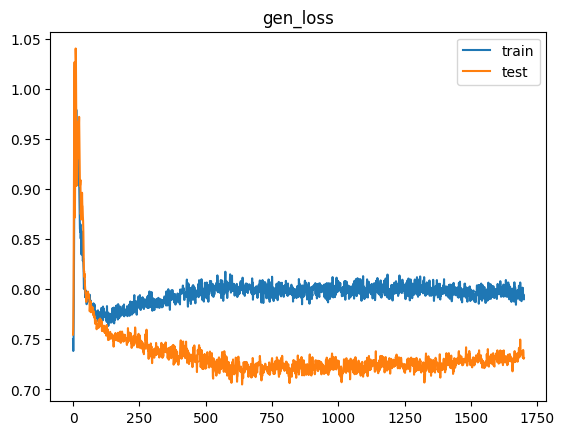

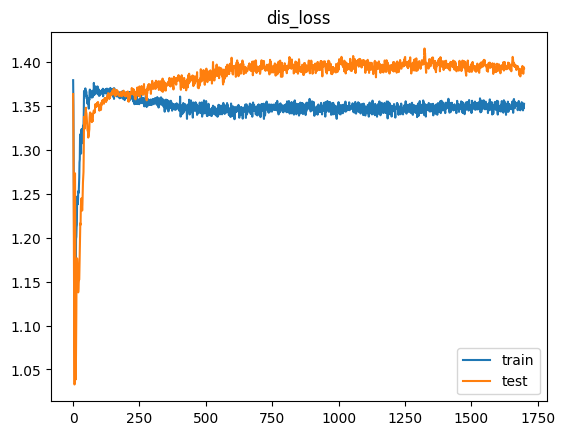

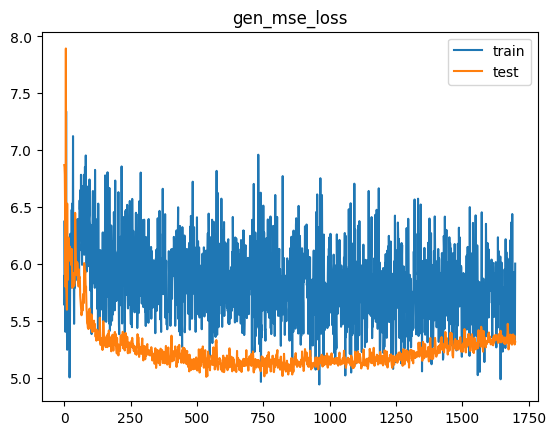

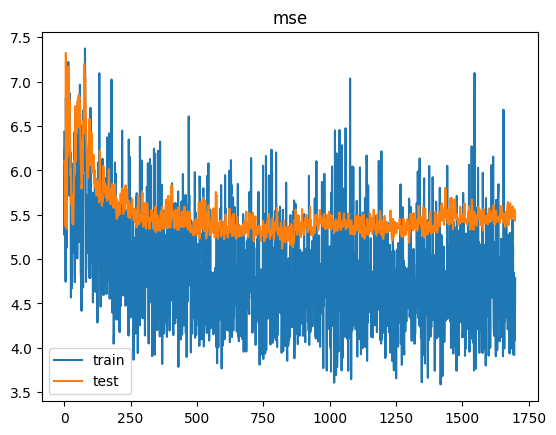

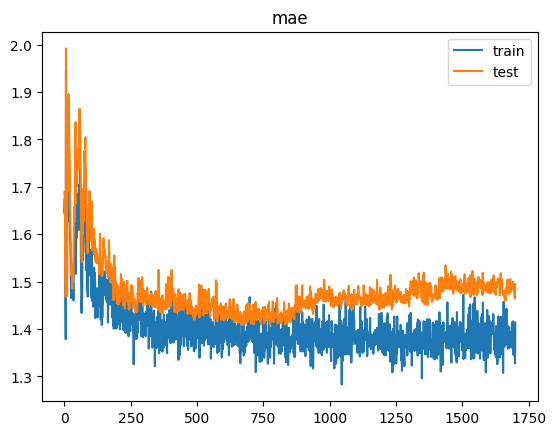

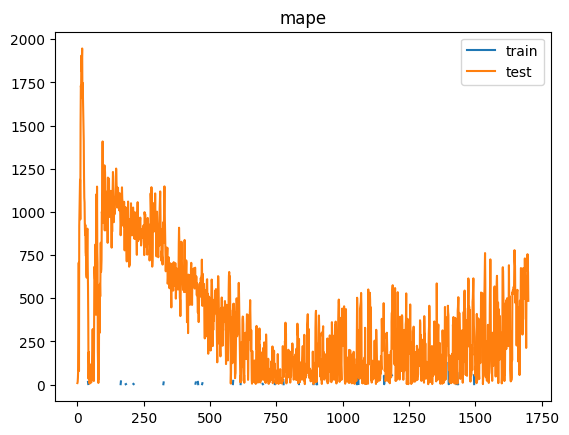

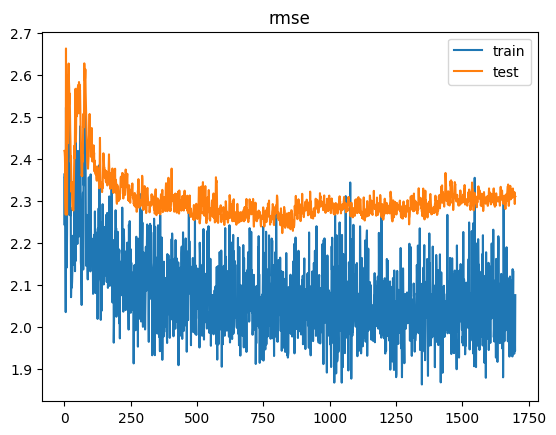

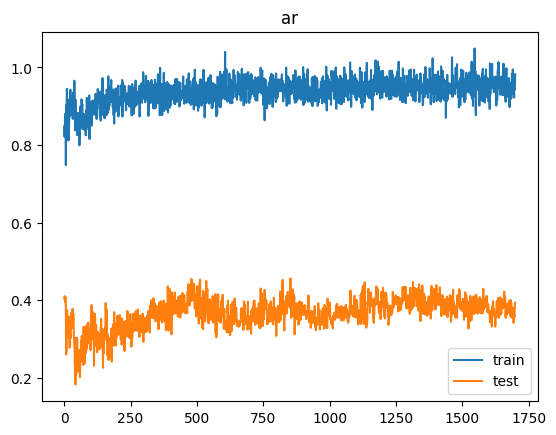

2/2 [==============================] - 1s 4ms/step


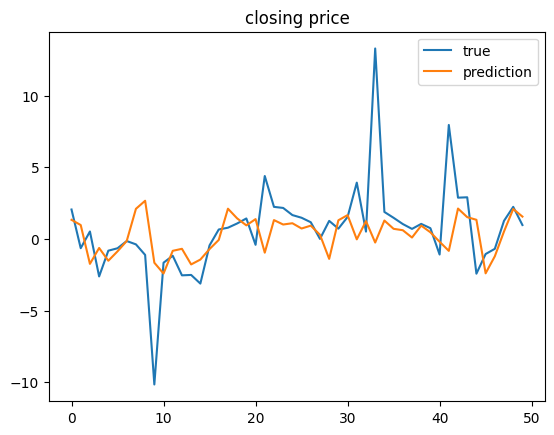

[MSE Baseline] train: 4.056440791608844  test: 4.988566607603537
Delta time with epochs = 1700: 0:27:03.429812
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 20)            1440      
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 20)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 20)             0         
              

Time for epoch 51 is 1.0239787101745605 sec Generator Loss: 0.8154631853103638,  Discriminator_loss: 1.3493661880493164
Time for epoch 52 is 1.0556657314300537 sec Generator Loss: 0.8049967885017395,  Discriminator_loss: 1.356048583984375
Time for epoch 53 is 1.0084643363952637 sec Generator Loss: 0.8000926971435547,  Discriminator_loss: 1.358201026916504
Time for epoch 54 is 0.9946184158325195 sec Generator Loss: 0.7980157732963562,  Discriminator_loss: 1.3621904850006104
Time for epoch 55 is 1.0436491966247559 sec Generator Loss: 0.7920746207237244,  Discriminator_loss: 1.360329270362854
Time for epoch 56 is 1.0617821216583252 sec Generator Loss: 0.7809405326843262,  Discriminator_loss: 1.3587273359298706
Time for epoch 57 is 1.0527455806732178 sec Generator Loss: 0.784340500831604,  Discriminator_loss: 1.3511751890182495
Time for epoch 58 is 1.0286555290222168 sec Generator Loss: 0.7879176139831543,  Discriminator_loss: 1.3550407886505127
Time for epoch 59 is 1.001103401184082 sec G

Time for epoch 120 is 1.1557295322418213 sec Generator Loss: 0.7746965289115906,  Discriminator_loss: 1.367026925086975
Time for epoch 121 is 1.1338834762573242 sec Generator Loss: 0.7800616025924683,  Discriminator_loss: 1.3694897890090942
Time for epoch 122 is 1.150667428970337 sec Generator Loss: 0.7668483853340149,  Discriminator_loss: 1.3694225549697876
Time for epoch 123 is 1.205810785293579 sec Generator Loss: 0.7671310305595398,  Discriminator_loss: 1.367030143737793
Time for epoch 124 is 1.1537752151489258 sec Generator Loss: 0.774983286857605,  Discriminator_loss: 1.3646122217178345
Time for epoch 125 is 1.1962311267852783 sec Generator Loss: 0.7727365493774414,  Discriminator_loss: 1.3663601875305176
Time for epoch 126 is 1.139148473739624 sec Generator Loss: 0.7682041525840759,  Discriminator_loss: 1.3662519454956055
Time for epoch 127 is 1.1016943454742432 sec Generator Loss: 0.7686951160430908,  Discriminator_loss: 1.3677897453308105
Time for epoch 128 is 1.16710734367370

Time for epoch 189 is 1.0758907794952393 sec Generator Loss: 0.769170880317688,  Discriminator_loss: 1.364881157875061
Time for epoch 190 is 1.0247173309326172 sec Generator Loss: 0.7697364687919617,  Discriminator_loss: 1.3663976192474365
Time for epoch 191 is 0.9908215999603271 sec Generator Loss: 0.7699959874153137,  Discriminator_loss: 1.3623396158218384
Time for epoch 192 is 1.0116426944732666 sec Generator Loss: 0.7794151902198792,  Discriminator_loss: 1.3561631441116333
Time for epoch 193 is 0.9714844226837158 sec Generator Loss: 0.7748392224311829,  Discriminator_loss: 1.3654975891113281
Time for epoch 194 is 0.9577009677886963 sec Generator Loss: 0.779985785484314,  Discriminator_loss: 1.3612335920333862
Time for epoch 195 is 0.9739372730255127 sec Generator Loss: 0.7728264331817627,  Discriminator_loss: 1.3617457151412964
Time for epoch 196 is 0.9991772174835205 sec Generator Loss: 0.7751148343086243,  Discriminator_loss: 1.3606733083724976
Time for epoch 197 is 0.99190664291

Time for epoch 258 is 0.9619600772857666 sec Generator Loss: 0.773407518863678,  Discriminator_loss: 1.3601527214050293
Time for epoch 259 is 0.9779915809631348 sec Generator Loss: 0.770904004573822,  Discriminator_loss: 1.3617157936096191
Time for epoch 260 is 0.9739325046539307 sec Generator Loss: 0.7793338894844055,  Discriminator_loss: 1.3603569269180298
Time for epoch 261 is 0.9895586967468262 sec Generator Loss: 0.7806400060653687,  Discriminator_loss: 1.360069751739502
Time for epoch 262 is 0.9764971733093262 sec Generator Loss: 0.775728166103363,  Discriminator_loss: 1.3649554252624512
Time for epoch 263 is 0.9815833568572998 sec Generator Loss: 0.7721254825592041,  Discriminator_loss: 1.3689137697219849
Time for epoch 264 is 0.9754390716552734 sec Generator Loss: 0.7659136652946472,  Discriminator_loss: 1.3619389533996582
Time for epoch 265 is 0.9838244915008545 sec Generator Loss: 0.7748234868049622,  Discriminator_loss: 1.3666532039642334
Time for epoch 266 is 1.021219968795

Time for epoch 326 is 0.8489208221435547 sec Generator Loss: 0.7795692682266235,  Discriminator_loss: 1.3576548099517822
Time for epoch 327 is 0.8483679294586182 sec Generator Loss: 0.7784828543663025,  Discriminator_loss: 1.3573540449142456
Time for epoch 328 is 0.8923549652099609 sec Generator Loss: 0.7753104567527771,  Discriminator_loss: 1.3528999090194702
Time for epoch 329 is 0.853583812713623 sec Generator Loss: 0.7800643444061279,  Discriminator_loss: 1.3553792238235474
Time for epoch 330 is 0.8420436382293701 sec Generator Loss: 0.7824020981788635,  Discriminator_loss: 1.3590694665908813
Time for epoch 331 is 0.8439896106719971 sec Generator Loss: 0.7769755125045776,  Discriminator_loss: 1.3572940826416016
Time for epoch 332 is 0.8497047424316406 sec Generator Loss: 0.7782717943191528,  Discriminator_loss: 1.3592106103897095
Time for epoch 333 is 0.840080738067627 sec Generator Loss: 0.776724636554718,  Discriminator_loss: 1.358283519744873
Time for epoch 334 is 0.855025291442

Time for epoch 394 is 0.8454089164733887 sec Generator Loss: 0.7846119999885559,  Discriminator_loss: 1.3531484603881836
Time for epoch 395 is 0.8479771614074707 sec Generator Loss: 0.7861104011535645,  Discriminator_loss: 1.3466302156448364
Time for epoch 396 is 0.8467555046081543 sec Generator Loss: 0.7835529446601868,  Discriminator_loss: 1.3545937538146973
Time for epoch 397 is 0.8553605079650879 sec Generator Loss: 0.7864035367965698,  Discriminator_loss: 1.3544647693634033
Time for epoch 398 is 0.8485889434814453 sec Generator Loss: 0.7853105664253235,  Discriminator_loss: 1.3541311025619507
Time for epoch 399 is 0.8496499061584473 sec Generator Loss: 0.7939542531967163,  Discriminator_loss: 1.3484216928482056
Time for epoch 400 is 0.8480424880981445 sec Generator Loss: 0.7945062518119812,  Discriminator_loss: 1.3455477952957153
Time for epoch 401 is 0.8537003993988037 sec Generator Loss: 0.7902749180793762,  Discriminator_loss: 1.3478175401687622
Time for epoch 402 is 0.85434246

Time for epoch 463 is 0.892512321472168 sec Generator Loss: 0.7945041656494141,  Discriminator_loss: 1.343389868736267
Time for epoch 464 is 0.8886034488677979 sec Generator Loss: 0.7879042625427246,  Discriminator_loss: 1.3526967763900757
Time for epoch 465 is 0.879767894744873 sec Generator Loss: 0.7832576036453247,  Discriminator_loss: 1.3529425859451294
Time for epoch 466 is 0.887249231338501 sec Generator Loss: 0.7958273887634277,  Discriminator_loss: 1.3402338027954102
Time for epoch 467 is 0.8813827037811279 sec Generator Loss: 0.7930797338485718,  Discriminator_loss: 1.3528270721435547
Time for epoch 468 is 0.8801991939544678 sec Generator Loss: 0.7901947498321533,  Discriminator_loss: 1.350547432899475
Time for epoch 469 is 0.9153861999511719 sec Generator Loss: 0.783586323261261,  Discriminator_loss: 1.3543967008590698
Time for epoch 470 is 0.879225492477417 sec Generator Loss: 0.8021290898323059,  Discriminator_loss: 1.3434443473815918
Time for epoch 471 is 0.878446102142334

Time for epoch 531 is 0.8897819519042969 sec Generator Loss: 0.7888138890266418,  Discriminator_loss: 1.347877025604248
Time for epoch 532 is 0.9474735260009766 sec Generator Loss: 0.7820194959640503,  Discriminator_loss: 1.358392357826233
Time for epoch 533 is 0.9603729248046875 sec Generator Loss: 0.7970797419548035,  Discriminator_loss: 1.3463574647903442
Time for epoch 534 is 0.9774961471557617 sec Generator Loss: 0.7913258671760559,  Discriminator_loss: 1.3486871719360352
Time for epoch 535 is 1.0049622058868408 sec Generator Loss: 0.7880827188491821,  Discriminator_loss: 1.3495949506759644
Time for epoch 536 is 0.9989333152770996 sec Generator Loss: 0.7959171533584595,  Discriminator_loss: 1.3436599969863892
Time for epoch 537 is 0.9626486301422119 sec Generator Loss: 0.7930021286010742,  Discriminator_loss: 1.3492450714111328
Time for epoch 538 is 0.9516687393188477 sec Generator Loss: 0.7976240515708923,  Discriminator_loss: 1.3498977422714233
Time for epoch 539 is 1.8333897590

Time for epoch 599 is 0.8480331897735596 sec Generator Loss: 0.8008068203926086,  Discriminator_loss: 1.3467905521392822
Time for epoch 600 is 0.8674471378326416 sec Generator Loss: 0.7961516380310059,  Discriminator_loss: 1.3472492694854736
Time for epoch 601 is 0.85355544090271 sec Generator Loss: 0.7949443459510803,  Discriminator_loss: 1.3437782526016235
Time for epoch 602 is 0.8456742763519287 sec Generator Loss: 0.7904729247093201,  Discriminator_loss: 1.3501715660095215
Time for epoch 603 is 0.8802282810211182 sec Generator Loss: 0.7950153350830078,  Discriminator_loss: 1.3383421897888184
Time for epoch 604 is 0.8466713428497314 sec Generator Loss: 0.7881654500961304,  Discriminator_loss: 1.3490244150161743
Time for epoch 605 is 0.866199254989624 sec Generator Loss: 0.7976055145263672,  Discriminator_loss: 1.3413842916488647
Time for epoch 606 is 0.9455125331878662 sec Generator Loss: 0.797771692276001,  Discriminator_loss: 1.346867561340332
Time for epoch 607 is 0.8491408824920

Time for epoch 667 is 0.861046314239502 sec Generator Loss: 0.7877712249755859,  Discriminator_loss: 1.3464674949645996
Time for epoch 668 is 0.8600854873657227 sec Generator Loss: 0.7946459650993347,  Discriminator_loss: 1.3478118181228638
Time for epoch 669 is 0.8550591468811035 sec Generator Loss: 0.8022215962409973,  Discriminator_loss: 1.3454192876815796
Time for epoch 670 is 0.8661761283874512 sec Generator Loss: 0.7990537285804749,  Discriminator_loss: 1.3515958786010742
Time for epoch 671 is 0.8663120269775391 sec Generator Loss: 0.8014850616455078,  Discriminator_loss: 1.3417003154754639
Time for epoch 672 is 0.8645443916320801 sec Generator Loss: 0.8029378056526184,  Discriminator_loss: 1.3458033800125122
Time for epoch 673 is 0.8781747817993164 sec Generator Loss: 0.8041591048240662,  Discriminator_loss: 1.348872184753418
Time for epoch 674 is 0.8654367923736572 sec Generator Loss: 0.8029006123542786,  Discriminator_loss: 1.343621850013733
Time for epoch 675 is 0.86439061164

Time for epoch 735 is 1.0057611465454102 sec Generator Loss: 0.7939816117286682,  Discriminator_loss: 1.3415288925170898
Time for epoch 736 is 0.9656898975372314 sec Generator Loss: 0.7936896085739136,  Discriminator_loss: 1.3416613340377808
Time for epoch 737 is 0.9472248554229736 sec Generator Loss: 0.8037732243537903,  Discriminator_loss: 1.3421443700790405
Time for epoch 738 is 0.9460313320159912 sec Generator Loss: 0.8043051362037659,  Discriminator_loss: 1.3407609462738037
Time for epoch 739 is 1.0057713985443115 sec Generator Loss: 0.805831253528595,  Discriminator_loss: 1.345984697341919
Time for epoch 740 is 1.0328474044799805 sec Generator Loss: 0.7984832525253296,  Discriminator_loss: 1.3444525003433228
Time for epoch 741 is 0.9772272109985352 sec Generator Loss: 0.8030983209609985,  Discriminator_loss: 1.3466395139694214
Time for epoch 742 is 1.025508165359497 sec Generator Loss: 0.8060700297355652,  Discriminator_loss: 1.3379383087158203
Time for epoch 743 is 1.01666879653

Time for epoch 803 is 0.958200216293335 sec Generator Loss: 0.8051368594169617,  Discriminator_loss: 1.3476101160049438
Time for epoch 804 is 0.9048810005187988 sec Generator Loss: 0.8061187267303467,  Discriminator_loss: 1.342920184135437
Time for epoch 805 is 0.9312071800231934 sec Generator Loss: 0.8008538484573364,  Discriminator_loss: 1.3443725109100342
Time for epoch 806 is 0.8911592960357666 sec Generator Loss: 0.803551971912384,  Discriminator_loss: 1.3424580097198486
Time for epoch 807 is 0.9507143497467041 sec Generator Loss: 0.8128710985183716,  Discriminator_loss: 1.3424090147018433
Time for epoch 808 is 0.9591598510742188 sec Generator Loss: 0.794478178024292,  Discriminator_loss: 1.3491113185882568
Time for epoch 809 is 0.9374485015869141 sec Generator Loss: 0.8042439222335815,  Discriminator_loss: 1.341857671737671
Time for epoch 810 is 0.8937985897064209 sec Generator Loss: 0.8039540648460388,  Discriminator_loss: 1.3447154760360718
Time for epoch 811 is 0.9453215599060

Time for epoch 871 is 0.8552002906799316 sec Generator Loss: 0.8006263375282288,  Discriminator_loss: 1.340445637702942
Time for epoch 872 is 0.908759355545044 sec Generator Loss: 0.7982221841812134,  Discriminator_loss: 1.3433223962783813
Time for epoch 873 is 0.8604302406311035 sec Generator Loss: 0.7977298498153687,  Discriminator_loss: 1.3469455242156982
Time for epoch 874 is 0.8626418113708496 sec Generator Loss: 0.8012840151786804,  Discriminator_loss: 1.3421427011489868
Time for epoch 875 is 0.8576366901397705 sec Generator Loss: 0.8042253255844116,  Discriminator_loss: 1.3479686975479126
Time for epoch 876 is 0.8541426658630371 sec Generator Loss: 0.801993191242218,  Discriminator_loss: 1.3415601253509521
Time for epoch 877 is 0.8483963012695312 sec Generator Loss: 0.7927433252334595,  Discriminator_loss: 1.3506017923355103
Time for epoch 878 is 0.8499083518981934 sec Generator Loss: 0.7953149080276489,  Discriminator_loss: 1.3500202894210815
Time for epoch 879 is 0.84555482864

Time for epoch 939 is 0.8462820053100586 sec Generator Loss: 0.7991288304328918,  Discriminator_loss: 1.3529683351516724
Time for epoch 940 is 0.8550503253936768 sec Generator Loss: 0.7984988689422607,  Discriminator_loss: 1.3482881784439087
Time for epoch 941 is 0.8874948024749756 sec Generator Loss: 0.7880523204803467,  Discriminator_loss: 1.345112681388855
Time for epoch 942 is 0.8711280822753906 sec Generator Loss: 0.8040416240692139,  Discriminator_loss: 1.343437910079956
Time for epoch 943 is 0.8618998527526855 sec Generator Loss: 0.8084951639175415,  Discriminator_loss: 1.3453876972198486
Time for epoch 944 is 0.8571157455444336 sec Generator Loss: 0.7975039482116699,  Discriminator_loss: 1.348218321800232
Time for epoch 945 is 0.8534412384033203 sec Generator Loss: 0.7997667789459229,  Discriminator_loss: 1.3484858274459839
Time for epoch 946 is 0.8560304641723633 sec Generator Loss: 0.7947911620140076,  Discriminator_loss: 1.3440619707107544
Time for epoch 947 is 0.86391425132

Time for epoch 1007 is 0.8585278987884521 sec Generator Loss: 0.8044403791427612,  Discriminator_loss: 1.3460047245025635
Time for epoch 1008 is 0.8581454753875732 sec Generator Loss: 0.8009466528892517,  Discriminator_loss: 1.3466278314590454
Time for epoch 1009 is 0.8579442501068115 sec Generator Loss: 0.8083117604255676,  Discriminator_loss: 1.3392788171768188
Time for epoch 1010 is 0.8644380569458008 sec Generator Loss: 0.8043126463890076,  Discriminator_loss: 1.3472052812576294
Time for epoch 1011 is 0.8516578674316406 sec Generator Loss: 0.8129963278770447,  Discriminator_loss: 1.3353259563446045
Time for epoch 1012 is 0.863914966583252 sec Generator Loss: 0.8099228143692017,  Discriminator_loss: 1.343884825706482
Time for epoch 1013 is 0.8567028045654297 sec Generator Loss: 0.804246187210083,  Discriminator_loss: 1.3473354578018188
Time for epoch 1014 is 0.8542993068695068 sec Generator Loss: 0.8010693192481995,  Discriminator_loss: 1.3459688425064087
Time for epoch 1015 is 0.86

Time for epoch 1075 is 0.8634443283081055 sec Generator Loss: 0.804153561592102,  Discriminator_loss: 1.3351362943649292
Time for epoch 1076 is 0.8640012741088867 sec Generator Loss: 0.8097909092903137,  Discriminator_loss: 1.339889645576477
Time for epoch 1077 is 0.8783650398254395 sec Generator Loss: 0.8066210746765137,  Discriminator_loss: 1.343184471130371
Time for epoch 1078 is 0.8857631683349609 sec Generator Loss: 0.8024684190750122,  Discriminator_loss: 1.3405646085739136
Time for epoch 1079 is 0.8587517738342285 sec Generator Loss: 0.7958155274391174,  Discriminator_loss: 1.3485989570617676
Time for epoch 1080 is 0.8639063835144043 sec Generator Loss: 0.7977808117866516,  Discriminator_loss: 1.3378214836120605
Time for epoch 1081 is 0.865342378616333 sec Generator Loss: 0.7984110116958618,  Discriminator_loss: 1.350663661956787
Time for epoch 1082 is 0.872725248336792 sec Generator Loss: 0.7980974912643433,  Discriminator_loss: 1.3389133214950562
Time for epoch 1083 is 0.85630

Time for epoch 1143 is 0.8648059368133545 sec Generator Loss: 0.8030407428741455,  Discriminator_loss: 1.3488017320632935
Time for epoch 1144 is 0.8669564723968506 sec Generator Loss: 0.8004226684570312,  Discriminator_loss: 1.3462448120117188
Time for epoch 1145 is 0.8784384727478027 sec Generator Loss: 0.7957321405410767,  Discriminator_loss: 1.3455581665039062
Time for epoch 1146 is 0.8890609741210938 sec Generator Loss: 0.7976788878440857,  Discriminator_loss: 1.3408955335617065
Time for epoch 1147 is 0.8717396259307861 sec Generator Loss: 0.8092172145843506,  Discriminator_loss: 1.3417350053787231
Time for epoch 1148 is 0.8619894981384277 sec Generator Loss: 0.7990097999572754,  Discriminator_loss: 1.344832420349121
Time for epoch 1149 is 0.8637444972991943 sec Generator Loss: 0.7927561402320862,  Discriminator_loss: 1.3512996435165405
Time for epoch 1150 is 0.889967679977417 sec Generator Loss: 0.8050602078437805,  Discriminator_loss: 1.3473153114318848
Time for epoch 1151 is 0.8

Time for epoch 1211 is 0.8674309253692627 sec Generator Loss: 0.7996354699134827,  Discriminator_loss: 1.346709966659546
Time for epoch 1212 is 0.8737888336181641 sec Generator Loss: 0.8032110333442688,  Discriminator_loss: 1.3471693992614746
Time for epoch 1213 is 0.8659296035766602 sec Generator Loss: 0.8016200661659241,  Discriminator_loss: 1.3466264009475708
Time for epoch 1214 is 0.8674442768096924 sec Generator Loss: 0.8073105216026306,  Discriminator_loss: 1.337892770767212
Time for epoch 1215 is 0.8740518093109131 sec Generator Loss: 0.8054907321929932,  Discriminator_loss: 1.346206545829773
Time for epoch 1216 is 0.8736171722412109 sec Generator Loss: 0.8090947270393372,  Discriminator_loss: 1.3431479930877686
Time for epoch 1217 is 0.8738710880279541 sec Generator Loss: 0.7998119592666626,  Discriminator_loss: 1.342655062675476
Time for epoch 1218 is 0.9043786525726318 sec Generator Loss: 0.8070615530014038,  Discriminator_loss: 1.3428980112075806
Time for epoch 1219 is 0.874

Time for epoch 1279 is 0.9055583477020264 sec Generator Loss: 0.8031275272369385,  Discriminator_loss: 1.3449302911758423
Time for epoch 1280 is 0.9881439208984375 sec Generator Loss: 0.7966469526290894,  Discriminator_loss: 1.347067952156067
Time for epoch 1281 is 0.907402515411377 sec Generator Loss: 0.8050330281257629,  Discriminator_loss: 1.3369582891464233
Time for epoch 1282 is 0.9054238796234131 sec Generator Loss: 0.8090984225273132,  Discriminator_loss: 1.3387746810913086
Time for epoch 1283 is 0.8754713535308838 sec Generator Loss: 0.79347825050354,  Discriminator_loss: 1.3417646884918213
Time for epoch 1284 is 0.8757987022399902 sec Generator Loss: 0.7934640049934387,  Discriminator_loss: 1.3470869064331055
Time for epoch 1285 is 0.8758985996246338 sec Generator Loss: 0.796550989151001,  Discriminator_loss: 1.3439242839813232
Time for epoch 1286 is 0.8710501194000244 sec Generator Loss: 0.8016913533210754,  Discriminator_loss: 1.3428798913955688
Time for epoch 1287 is 0.8757

Time for epoch 1347 is 0.8855626583099365 sec Generator Loss: 0.8062994480133057,  Discriminator_loss: 1.34933340549469
Time for epoch 1348 is 0.9228713512420654 sec Generator Loss: 0.809205174446106,  Discriminator_loss: 1.3379251956939697
Time for epoch 1349 is 0.898066520690918 sec Generator Loss: 0.7998316287994385,  Discriminator_loss: 1.3463243246078491
Time for epoch 1350 is 0.8879613876342773 sec Generator Loss: 0.7989656925201416,  Discriminator_loss: 1.3498599529266357
Time for epoch 1351 is 0.9269390106201172 sec Generator Loss: 0.8009700775146484,  Discriminator_loss: 1.3424537181854248
Time for epoch 1352 is 0.8832502365112305 sec Generator Loss: 0.8065981864929199,  Discriminator_loss: 1.340216040611267
Time for epoch 1353 is 0.878760576248169 sec Generator Loss: 0.7978501319885254,  Discriminator_loss: 1.3440327644348145
Time for epoch 1354 is 0.8780920505523682 sec Generator Loss: 0.7953557968139648,  Discriminator_loss: 1.3462964296340942
Time for epoch 1355 is 0.87398

Time for epoch 1415 is 0.8861136436462402 sec Generator Loss: 0.7910553812980652,  Discriminator_loss: 1.3452049493789673
Time for epoch 1416 is 0.887031078338623 sec Generator Loss: 0.8043724298477173,  Discriminator_loss: 1.349105715751648
Time for epoch 1417 is 0.8864450454711914 sec Generator Loss: 0.802067756652832,  Discriminator_loss: 1.3470739126205444
Time for epoch 1418 is 0.8962912559509277 sec Generator Loss: 0.8002607822418213,  Discriminator_loss: 1.3489534854888916
Time for epoch 1419 is 0.9153895378112793 sec Generator Loss: 0.7992187738418579,  Discriminator_loss: 1.3499785661697388
Time for epoch 1420 is 0.9004321098327637 sec Generator Loss: 0.7922720909118652,  Discriminator_loss: 1.3474957942962646
Time for epoch 1421 is 0.8988168239593506 sec Generator Loss: 0.7950059175491333,  Discriminator_loss: 1.3458056449890137
Time for epoch 1422 is 0.8965404033660889 sec Generator Loss: 0.7995044589042664,  Discriminator_loss: 1.3405429124832153
Time for epoch 1423 is 0.90

Time for epoch 1483 is 0.8646256923675537 sec Generator Loss: 0.8063602447509766,  Discriminator_loss: 1.347304105758667
Time for epoch 1484 is 0.8698837757110596 sec Generator Loss: 0.7969051003456116,  Discriminator_loss: 1.3512035608291626
Time for epoch 1485 is 0.8728170394897461 sec Generator Loss: 0.8035233020782471,  Discriminator_loss: 1.3490608930587769
Time for epoch 1486 is 0.8736369609832764 sec Generator Loss: 0.8038148880004883,  Discriminator_loss: 1.3464525938034058
Time for epoch 1487 is 0.8831300735473633 sec Generator Loss: 0.7968191504478455,  Discriminator_loss: 1.3444907665252686
Time for epoch 1488 is 0.8710734844207764 sec Generator Loss: 0.7974432110786438,  Discriminator_loss: 1.3467673063278198
Time for epoch 1489 is 0.8732407093048096 sec Generator Loss: 0.8011239171028137,  Discriminator_loss: 1.348742127418518
Time for epoch 1490 is 0.8804707527160645 sec Generator Loss: 0.7927507758140564,  Discriminator_loss: 1.346606969833374
Time for epoch 1491 is 0.87

Time for epoch 1551 is 0.8759598731994629 sec Generator Loss: 0.7973199486732483,  Discriminator_loss: 1.3405179977416992
Time for epoch 1552 is 0.8795204162597656 sec Generator Loss: 0.792490541934967,  Discriminator_loss: 1.3465449810028076
Time for epoch 1553 is 0.8727712631225586 sec Generator Loss: 0.8099400997161865,  Discriminator_loss: 1.3457022905349731
Time for epoch 1554 is 0.8825464248657227 sec Generator Loss: 0.8067893981933594,  Discriminator_loss: 1.3424280881881714
Time for epoch 1555 is 0.8686320781707764 sec Generator Loss: 0.803881824016571,  Discriminator_loss: 1.3486145734786987
Time for epoch 1556 is 0.8748936653137207 sec Generator Loss: 0.8070985674858093,  Discriminator_loss: 1.3427362442016602
Time for epoch 1557 is 0.8773186206817627 sec Generator Loss: 0.8088810443878174,  Discriminator_loss: 1.3471193313598633
Time for epoch 1558 is 0.8869349956512451 sec Generator Loss: 0.7920053601264954,  Discriminator_loss: 1.3428537845611572
Time for epoch 1559 is 0.8

Time for epoch 1619 is 0.8970272541046143 sec Generator Loss: 0.8021659255027771,  Discriminator_loss: 1.3425383567810059
Time for epoch 1620 is 0.8874330520629883 sec Generator Loss: 0.8057678937911987,  Discriminator_loss: 1.340774416923523
Time for epoch 1621 is 0.8946754932403564 sec Generator Loss: 0.8022791147232056,  Discriminator_loss: 1.3447240591049194
Time for epoch 1622 is 0.8966066837310791 sec Generator Loss: 0.8040756583213806,  Discriminator_loss: 1.345577359199524
Time for epoch 1623 is 0.8881194591522217 sec Generator Loss: 0.7999394536018372,  Discriminator_loss: 1.3420096635818481
Time for epoch 1624 is 0.8897483348846436 sec Generator Loss: 0.8017529249191284,  Discriminator_loss: 1.343014121055603
Time for epoch 1625 is 0.8975110054016113 sec Generator Loss: 0.79645174741745,  Discriminator_loss: 1.3507566452026367
Time for epoch 1626 is 0.8915390968322754 sec Generator Loss: 0.8073369264602661,  Discriminator_loss: 1.3411427736282349
Time for epoch 1627 is 0.9101

Time for epoch 1687 is 0.9586620330810547 sec Generator Loss: 0.7969487309455872,  Discriminator_loss: 1.346994400024414
Time for epoch 1688 is 1.0107862949371338 sec Generator Loss: 0.7956470251083374,  Discriminator_loss: 1.3427653312683105
Time for epoch 1689 is 1.1247777938842773 sec Generator Loss: 0.80225670337677,  Discriminator_loss: 1.3486359119415283
Time for epoch 1690 is 1.0584371089935303 sec Generator Loss: 0.7968573570251465,  Discriminator_loss: 1.3504807949066162
Time for epoch 1691 is 1.1828107833862305 sec Generator Loss: 0.7998164296150208,  Discriminator_loss: 1.3479351997375488
Time for epoch 1692 is 1.150991439819336 sec Generator Loss: 0.7994951605796814,  Discriminator_loss: 1.3439902067184448
Time for epoch 1693 is 1.1568577289581299 sec Generator Loss: 0.8040983080863953,  Discriminator_loss: 1.3439409732818604
Time for epoch 1694 is 1.1462397575378418 sec Generator Loss: 0.8048436641693115,  Discriminator_loss: 1.3405758142471313
Time for epoch 1695 is 1.121

Time for epoch 1755 is 1.044050693511963 sec Generator Loss: 0.8024150133132935,  Discriminator_loss: 1.3465160131454468
Time for epoch 1756 is 1.0272133350372314 sec Generator Loss: 0.8058606386184692,  Discriminator_loss: 1.3432496786117554
Time for epoch 1757 is 1.1101014614105225 sec Generator Loss: 0.7935389280319214,  Discriminator_loss: 1.3457622528076172
Time for epoch 1758 is 0.9770481586456299 sec Generator Loss: 0.8004454374313354,  Discriminator_loss: 1.3460429906845093
Time for epoch 1759 is 1.0634043216705322 sec Generator Loss: 0.7983534336090088,  Discriminator_loss: 1.3477472066879272
Time for epoch 1760 is 1.03129243850708 sec Generator Loss: 0.8032166361808777,  Discriminator_loss: 1.3398630619049072
Time for epoch 1761 is 1.0515062808990479 sec Generator Loss: 0.7952825427055359,  Discriminator_loss: 1.342413067817688
Time for epoch 1762 is 0.9703624248504639 sec Generator Loss: 0.7934536933898926,  Discriminator_loss: 1.344937801361084
Time for epoch 1763 is 0.9808

Time for epoch 1823 is 0.955557107925415 sec Generator Loss: 0.8120021820068359,  Discriminator_loss: 1.3467261791229248
Time for epoch 1824 is 1.0058715343475342 sec Generator Loss: 0.8056710362434387,  Discriminator_loss: 1.3440500497817993
Time for epoch 1825 is 0.9949624538421631 sec Generator Loss: 0.797055184841156,  Discriminator_loss: 1.3492873907089233
Time for epoch 1826 is 0.9694180488586426 sec Generator Loss: 0.7960232496261597,  Discriminator_loss: 1.3506922721862793
Time for epoch 1827 is 0.9580469131469727 sec Generator Loss: 0.7979292869567871,  Discriminator_loss: 1.3505492210388184
Time for epoch 1828 is 0.9857339859008789 sec Generator Loss: 0.7933951020240784,  Discriminator_loss: 1.3499252796173096
Time for epoch 1829 is 0.9751734733581543 sec Generator Loss: 0.7971836924552917,  Discriminator_loss: 1.3504928350448608
Time for epoch 1830 is 0.9710137844085693 sec Generator Loss: 0.7928546071052551,  Discriminator_loss: 1.3536194562911987
Time for epoch 1831 is 1.0

Time for epoch 1891 is 1.2347204685211182 sec Generator Loss: 0.8046256899833679,  Discriminator_loss: 1.3417447805404663
Time for epoch 1892 is 1.1106469631195068 sec Generator Loss: 0.8005547523498535,  Discriminator_loss: 1.345753788948059
Time for epoch 1893 is 1.1395361423492432 sec Generator Loss: 0.8016474843025208,  Discriminator_loss: 1.3417658805847168
Time for epoch 1894 is 1.118424654006958 sec Generator Loss: 0.794122576713562,  Discriminator_loss: 1.34977126121521
Time for epoch 1895 is 1.0080499649047852 sec Generator Loss: 0.7894675135612488,  Discriminator_loss: 1.3563668727874756
Time for epoch 1896 is 0.9725472927093506 sec Generator Loss: 0.8013682961463928,  Discriminator_loss: 1.3445345163345337
Time for epoch 1897 is 0.9733555316925049 sec Generator Loss: 0.8005285263061523,  Discriminator_loss: 1.3509471416473389
Time for epoch 1898 is 1.0350286960601807 sec Generator Loss: 0.8040254712104797,  Discriminator_loss: 1.3437507152557373
Time for epoch 1899 is 1.1518

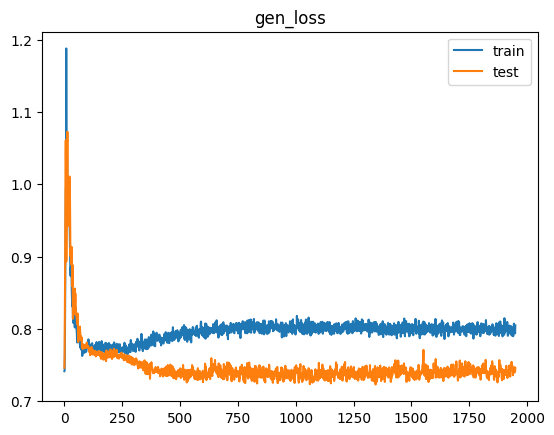

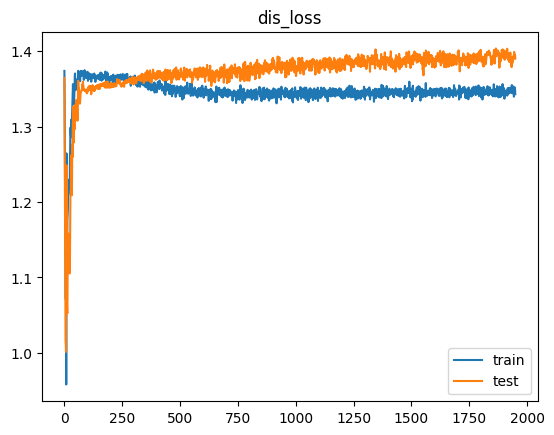

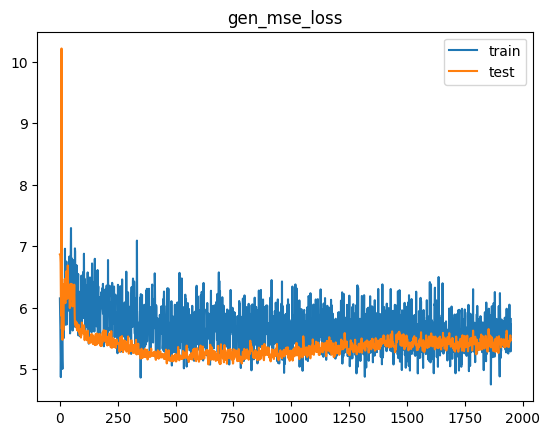

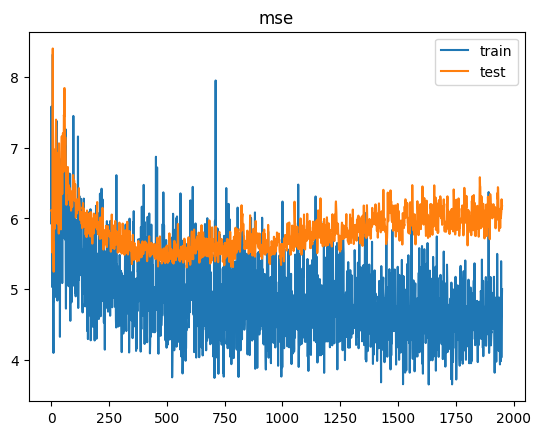

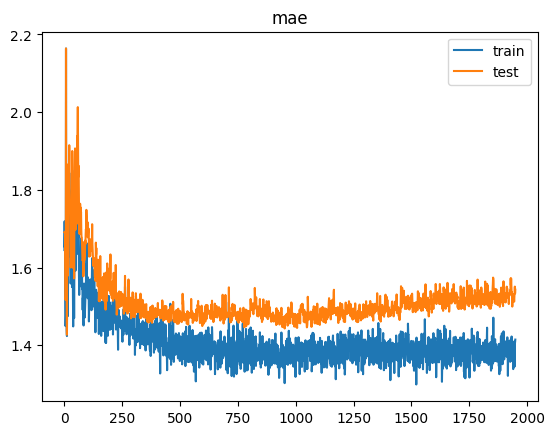

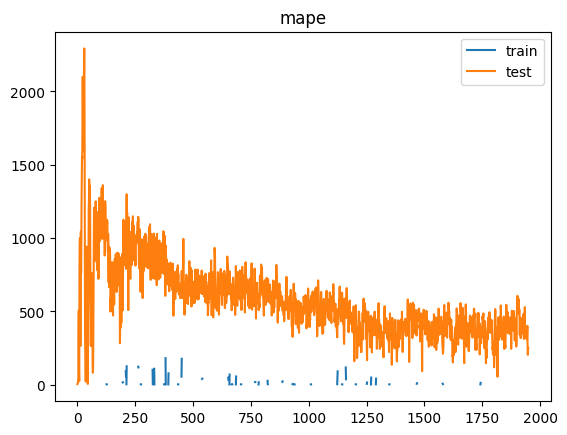

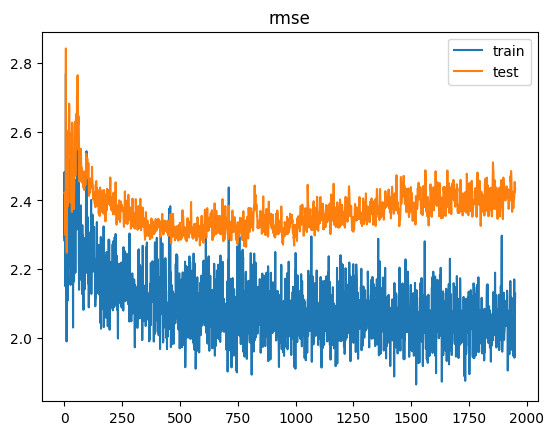

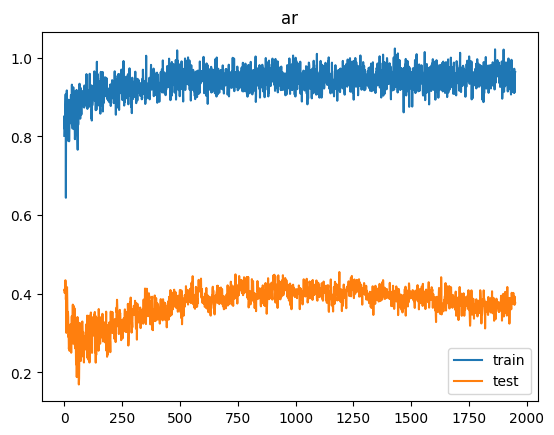

2/2 [==============================] - 0s 4ms/step


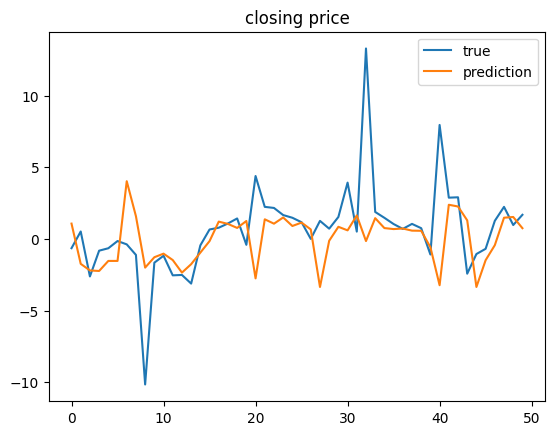

[MSE Baseline] train: 4.870273998676036  test: 5.002352560408067
Delta time with epochs = 1950: 0:30:47.306580


In [19]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("bilstm_ffnn_epochs_{0}.h5".format(epochs))